In [1]:
import os
os.chdir('..')

# IMPORTS

In [2]:
import matplotlib
from matplotlib import rcParams, cycler
from src.utils.batch_effect_removal import get_berm  # , remove_batch_effect

# matplotlib.use('Agg')
CUDA_VISIBLE_DEVICES = ""
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import pandas as pd
import numpy as np
import random
import json
import copy
import torch
import sklearn
from itertools import cycle
from torch import nn
import os
from src.utils.pool_metrics import get_PCC, get_qc_euclidean, get_batches_euclidean, get_euclidean
from scipy.spatial.distance import cdist, pdist

from sklearn.metrics import silhouette_score, adjusted_rand_score, adjusted_mutual_info_score
from sklearn.model_selection import StratifiedGroupKFold, StratifiedKFold
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import CCA
from umap.umap_ import UMAP

from src.utils.pool_metrics import log_pool_metrics
from src.dl.models.pytorch.aedann import ReverseLayerF
from src.dl.models.pytorch.aedann import Encoder2, Decoder2, Classifier, Classifier2, Classifier3, DispAct, MeanAct
from src.dl.models.pytorch.utils.loggings import TensorboardLoggingAE, log_input_ordination, \
    log_confusion_matrix, log_plots
from src.dl.models.pytorch.utils.dataset import get_loaders
from src.utils.utils import scale_data, get_unique_labels, scale_data_per_batch
from src.dl.models.pytorch.utils.utils import get_optimizer, to_categorical, get_empty_dicts, get_empty_traces, \
    log_traces, get_best_loss_from_tb, get_best_acc_from_tb, get_best_values, add_to_logger
from src.dl.models.pytorch.utils.plotting import confidence_ellipse
from src.dl.models.pytorch.utils.stochastic import GaussianSample
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA


import warnings
from datetime import datetime
from sklearn.preprocessing import OneHotEncoder
from tabulate import tabulate

warnings.filterwarnings("ignore")

random.seed(42)
torch.manual_seed(42)
np.random.seed(42)

strategy = 'CU_DEM-AD'
csv_name = 'amide_data.csv'

import argparse
parser = argparse.ArgumentParser()
args = parser.parse_args(args=[])
args.csv_file = 'unique_genes.csv'
args.remove_zeros = 0
args.bad_batches = ''
args.log1p = 1
args.zinb = 0
args.groupkfold = 1
log_stuff = True
best_correction = False
n_meta = 0
train_models = True


The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


/home/simonp/.local/lib/python3.8/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/simonp/.local/lib/python3.8/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/simonp/.local/lib/python3.8/site-packages/umap/distances.py:1086: NumbaDeprecationWarning: The '

In [3]:
from skopt.space import Real, Integer, Categorical
from sklearn.ensemble import RandomForestClassifier
rfc_space = [
    # Integer(100, 20000, 'uniform', name='features_cutoff'),
    # Real(0, 1, 'uniform', name='threshold'),
    Integer(1, 100, 'uniform', name="max_features"),
    Integer(2, 10, 'uniform', name="min_samples_split"),
    Integer(1, 10, 'uniform', name="min_samples_leaf"),
    Integer(1, 1000, 'uniform', name="n_estimators"),
    Categorical(['gini', 'entropy'], name="criterion"),
    Categorical([True, False], name="oob_score"),
    Categorical(['balanced'], name="class_weight"),
]
linsvc_space = [
    # Integer(1, 20000, 'uniform', name='features_cutoff'),
    # Real(0, 1, 'uniform', name='threshold'),
    Real(1e-4, 1, 'log-uniform', name='tol'),
    Integer(1, 1000, 'uniform', name='max_iter'),
    Categorical(['l2'], name='penalty'),
    Real(1e-3, 10000, 'uniform', name='C'),
    Categorical(['balanced'], name='class_weight'),

]
logreg_space = [
    # Integer(1, 20000, 'uniform', name='features_cutoff'),
    # Real(0, 1, 'uniform', name='threshold'),
    Integer(1, 20000, 'uniform', name='max_iter'),
    Real(1e-3, 20000, 'uniform', name='C'),
    Categorical(['saga'], name='solver'),
    Categorical(['l1', 'l2'], name='penalty'),
    Categorical([True, False], name='fit_intercept'),
    Categorical(['balanced'], name='class_weight'),
]


In [4]:
import rpy2.robjects as robjects
from rpy2.robjects import pandas2ri
from rpy2.robjects.packages import importr
from rpy2.robjects.conversion import localconverter
def pyGPCA(data, group, name, metrics):
    gPCA = importr('gPCA')

    newdata = robjects.r.matrix(robjects.FloatVector(np.array(data['inputs'][group]).reshape(-1)), nrow=data['inputs'][group].shape[0])
    new_batches = robjects.r.matrix(robjects.IntVector(data['batches'][group]), nrow=data['inputs'][group].shape[0])

    results = gPCA.gPCA_batchdetect(newdata, new_batches)
    # print(results)
    # with localconverter(robjects.default_converter + pandas2ri.converter):
    #     results = np.array(robjects.conversion.rpy2py(results))
    # print(results)
    with localconverter(robjects.default_converter + pandas2ri.converter):
        results = { key : np.array(robjects.conversion.rpy2py(results.rx2(key))) for key in results.names }
        # metrics['raw']['delta'] = metrics['raw']['delta']))

    if 'pool' in name:
        delta_name = 'delta_pool'
        name = name.split('_')[1]
    else:
        delta_name = 'delta'
    if name not in metrics:
        metrics[name] = {}
        # print(results)
    metrics[name][delta_name] = results['delta'][0]
    # metrics[name]['delta.pval'] = results[1]
    return metrics, results

In [5]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.pipeline import Pipeline
minmax_scaler = MinMaxScaler()
standard_scaler = StandardScaler()
robust_scaler = RobustScaler()
standard_minmax_scaler = Pipeline([('standard', StandardScaler()), ('minmax', MinMaxScaler())])
robust_minmax_scaler = Pipeline([('robust', RobustScaler()), ('minmax', MinMaxScaler())])


In [6]:
def log_ORD(ordin, data, uniques, epoch, transductive=False):
    transductive = True

    model = ordin['model']
    model.fit(data['inputs']['all'])
    pcs_all = model.transform(data['inputs']['all'])

    # fig, ax = plt.subplots()
    # fig = plt.figure(figsize=(12, 12))
    pcs_all_df = pd.DataFrame(data=pcs_all, columns=['PC 1', 'PC 2'])
    for name, subnum in list(zip(uniques.keys(), [321, 322, 323, 324, 325, 326])):
        fig = plt.figure(figsize=(8, 8))
        ax = fig.add_subplot(111)
        try:
            ev = model.explained_variance_ratio_
            pc1 = 'Component_1 : ' + str(np.round(ev[0] * 100, decimals=2)) + "%"
            pc2 = 'Component_2 : ' + str(np.round(ev[1] * 100, decimals=2)) + "%"
        except:
            pc1 = 'Component_1'
            pc2 = 'Component_2'

        ax.set_xlabel(pc1, fontsize=15)
        ax.set_ylabel(pc2, fontsize=15)
        ax.set_title(f"2 component {ordin['name']}", fontsize=20)

        num_targets = len(uniques[name])
        cmap = plt.cm.tab20

        cols = cmap(np.linspace(0, 1, len(uniques[name]) + 1))
        colors = rcParams['axes.prop_cycle'] = cycler(color=cols)
        colors_list = {name: [] for name in ['all']}
        data1_list = {name: [] for name in ['all']}
        data2_list = {name: [] for name in ['all']}
        new_labels = {name: [] for name in ['all']}
        new_cats = {name: [] for name in ['all']}

        ellipses = []
        unique_cats_train = np.array([])
        for df_name, df, labels in zip(['all'],
                                       [pcs_all_df],
                                       [data[name]['all']]):
            for t, target in enumerate(uniques[name]):
                # final_labels = list(train_labels)
                indices_to_keep = [True if x == target else False for x in list(labels)]
                data1 = list(df.loc[indices_to_keep, 'PC 1'])
                new_labels[df_name] += [target for _ in range(len(data1))]
                new_cats[df_name] += [target for _ in range(len(data1))]

                data2 = list(df.loc[indices_to_keep, 'PC 2'])
                data1_list[df_name] += [data1]
                data2_list[df_name] += [data2]
                colors_list[df_name] += [np.array([[cols[t]] * len(data1)])]
                if len(indices_to_keep) > 1 and df_name == 'train_data' or target not in unique_cats_train:
                    unique_cats_train = np.unique(np.concatenate((new_labels[df_name], unique_cats_train)))
                    try:
                        confidence_ellipses = confidence_ellipse(np.array(data1), np.array(data2), ax, 1.5,
                                                                 edgecolor=cols[t],
                                                                 train_set=True)
                        ellipses += [confidence_ellipses[1]]
                    except:
                        pass

        for df_name, marker in zip(list(data1_list.keys()), ['o']):
            data1_vector = np.hstack([d for d in data1_list[df_name] if len(d) > 0]).reshape(-1, 1)
            colors_vector = np.hstack([d for d in colors_list[df_name] if d.shape[1] > 0]).squeeze()
            data2_vector = np.hstack(data2_list[df_name]).reshape(-1, 1)
            data_colors_vector = np.concatenate((data1_vector, data2_vector, colors_vector), axis=1)
            data2 = data_colors_vector[:, 1]
            col = data_colors_vector[:, 2:]
            data1 = data_colors_vector[:, 0]

            ax.scatter(data1, data2, s=50, alpha=1.0, c=col, label=new_labels[df_name], marker=marker)
            custom_lines = [Line2D([0], [0], color=cmap(x), lw=4) for x in np.linspace(0, 1, len(uniques[name]) + 1)]
            ax.legend(custom_lines, uniques[name].tolist())

        plt.show()
        plt.close()


In [7]:
def log_ORD(ordin, data, uniques, epoch, transductive=True):
    model = ordin['model']
    for f in ['inputs', 'batches', 'labels']:
        # for g in ['train', 'valid', 'test']:
        data[f]['train'] = np.concatenate((data[f]['train'], data[f][f'valid_pool']))
        data[f]['valid'] = np.concatenate((data[f]['valid'], data[f][f'test_pool']))
        data[f]['test'] = np.concatenate((data[f]['test'], data[f][f'train_pool']))
    if transductive:
        model.fit(np.concatenate((data['inputs']['train'], data['inputs']['valid'], data['inputs']['test'])))
        pcs_train = model.transform(data['inputs']['train'])
        if "transductive" not in ordin['name']:
            ordin['name'] += "_transductive"
    else:
        pcs_train = model.fit_transform(data['inputs']['train'])
    if data['inputs']['valid'] is not None:
        pcs_valid = model.transform(data['inputs']['valid'])
    else:
        pcs_valid = np.array([])
    if data['inputs']['test'] is not None:
        pcs_test = model.transform(data['inputs']['test'])
    else:
        pcs_test = np.array([])
        test_labels = np.array([])
    pcs_train_df = pd.DataFrame(data=pcs_train, columns=['PC 1', 'PC 2'])
    pcs_valid_df = pd.DataFrame(data=pcs_valid, columns=['PC 1', 'PC 2'])
    pcs_test_df = pd.DataFrame(data=pcs_test, columns=['PC 1', 'PC 2'])
    try:
        ev = model.explained_variance_ratio_
        pc1 = 'Component_1 : ' + str(np.round(ev[0] * 100, decimals=2)) + "%"
        pc2 = 'Component_2 : ' + str(np.round(ev[1] * 100, decimals=2)) + "%"
    except:
        pc1 = 'Component_1'
        pc2 = 'Component_2'

    for name in list(uniques.keys()):
        print(name)
        fig = plt.figure(figsize=(12, 12))
        ax = fig.add_subplot(111)
        ax.set_xlabel(pc1, fontsize=15)
        ax.set_ylabel(pc2, fontsize=15)
        ax.set_title(f"2 component {ordin['name']} {name}", fontsize=20)

        # plt.show()

        num_targets = len(uniques[name])
        cmap = plt.cm.tab20

        cols = cmap(np.linspace(0, 1, len(uniques[name]) + 1))
        colors = rcParams['axes.prop_cycle'] = cycler(color=cols)
        colors_list = {name: [] for name in ['train', 'valid', 'test']}
        data1_list = {name: [] for name in ['train', 'valid', 'test']}
        data2_list = {name: [] for name in ['train', 'valid', 'test']}
        new_labels = {name: [] for name in ['train', 'valid', 'test']}
        new_cats = {name: [] for name in ['train', 'valid', 'test']}
        new_pools = {name: [] for name in ['train', 'valid', 'test']}

        ellipses = []
        unique_cats_train = np.array([])
        for df_name, df, labels, plabels in zip(['train', 'valid', 'test'],
                                       [pcs_train_df, pcs_valid_df, pcs_test_df],
                                       [data[name]['train'], data[name]['valid'], data[name]['test']],
                                       [data['labels']['train'], data[name]['valid'], data['labels']['test']],
                                      ):
            new_pools[df_name] = [1 if plabel == 'pool' else 0 for plabel in plabels]
            for t, target in enumerate(uniques[name]):
                indices_to_keep = [True if x == target else False for x in list(labels)]
                data1 = list(df.loc[indices_to_keep, 'PC 1'])
                new_labels[df_name] += [target for _ in range(len(data1))]
                new_cats[df_name] += [target for _ in range(len(data1))]

                data2 = list(df.loc[indices_to_keep, 'PC 2'])
                data1_list[df_name] += [data1]
                data2_list[df_name] += [data2]
                colors_list[df_name] += [np.array([[cols[t]] * len(data1)])]
                if len(indices_to_keep) > 1 and df_name == 'train_data' or target not in unique_cats_train:
                    unique_cats_train = np.unique(np.concatenate((new_labels[df_name], unique_cats_train)))
                    try:
                        confidence_ellipses = confidence_ellipse(np.array(data1), np.array(data2), ax, 1.5,
                                                                 edgecolor=cols[t],
                                                                 train_set=True)
                        ellipses += [confidence_ellipses[1]]
                    except:
                        pass

        for df_name, marker in zip(list(data1_list.keys()), ['o', 'x', '*']):
            data1_vector = np.hstack([d for d in data1_list[df_name] if len(d) > 0]).reshape(-1, 1)
            colors_vector = np.hstack([d for d in colors_list[df_name] if d.shape[1] > 0]).squeeze()
            data2_vector = np.hstack(data2_list[df_name]).reshape(-1, 1)
            data_colors_vector = np.concatenate((data1_vector, data2_vector, colors_vector), axis=1)
            data2 = data_colors_vector[:, 1]
            col = data_colors_vector[:, 2:]
            data1 = data_colors_vector[:, 0]

            ax.scatter(data1, data2, s=50, alpha=1.0, c=col, label=new_labels[df_name], marker=marker)
            custom_lines = [Line2D([0], [0], color=cmap(x), lw=4) for x in np.linspace(0, 1, len(uniques[name]) + 1)]
            ax.legend(custom_lines, uniques[name].tolist())
            # print(data1)

            
        plt.show()
        plt.close()



In [8]:
    
def log_LDA(ordin, data, uniques, epoch, metrics, model_name):
    for name in list(uniques.keys()):
        skf = sklearn.model_selection.StratifiedKFold(n_splits=5, shuffle=False, random_state=None)
        train_nums = np.arange(0, len(data['labels']['all']))
        scores = []
        # Remove samples from unwanted batches
        for i, (train_inds, valid_inds) in enumerate(skf.split(train_nums, data['labels']['all'], data['batches']['all'])):

            if len(uniques[name]) > 2:
                n_comp = 2
            else:
                n_comp = 1
            model = ordin(n_components=n_comp)
            
            pcs_train = model.fit_transform(data['inputs']['all'].iloc[train_inds], data[name]['all'].iloc[train_inds])
            pcs_valid = model.transform(data['inputs']['all'].iloc[valid_inds])
            scores += [model.score(data['inputs']['all'].iloc[valid_inds], data[name]['all'].iloc[valid_inds])]
            print(i)
            if i == 0:
                fig = plt.figure(figsize=(12, 12))
                ax = fig.add_subplot(111)
                # pcs_train = model.transform(np.concatenate((data['inputs']['train'], data['inputs']['train_pool']), 0))
                # pcs_valid = model.transform(np.concatenate((data['inputs']['valid'], data['inputs']['valid_pool']), 0))
                # pcs_test = model.transform(np.concatenate((data['inputs']['test'], data['inputs']['test_pool']), 0))

                if n_comp > 1:
                    pcs_train_df = pd.DataFrame(data=pcs_train, columns=['LD1', 'LD2'])
                    pcs_valid_df = pd.DataFrame(data=pcs_valid, columns=['LD1', 'LD2'])
                    # pcs_test_df = pd.DataFrame(data=pcs_test, columns=['LD1', 'LD2'])
                else:
                    pcs_train_df = pd.DataFrame(data=pcs_train, columns=['LD1'])
                    pcs_valid_df = pd.DataFrame(data=pcs_valid, columns=['LD1'])
                    # pcs_test_df = pd.DataFrame(data=pcs_test, columns=['LD1'])

                try:
                    ev = model.explained_variance_ratio_
                    pc1 = 'Component_1 : ' + str(np.round(ev[0] * 100, decimals=2)) + "%"
                    pc2 = 'Component_2 : ' + str(np.round(ev[1] * 100, decimals=2)) + "%"
                except:
                    pc1 = 'Component_1'
                    pc2 = 'Component_2'

                ax.set_xlabel(pc1, fontsize=15)
                ax.set_ylabel(pc2, fontsize=15)
                ax.set_title(f"2 component LDA", fontsize=20)

                num_targets = len(uniques[name])
                cmap = plt.cm.tab20

                cols = cmap(np.linspace(0, 1, len(uniques[name]) + 1))
                colors = rcParams['axes.prop_cycle'] = cycler(color=cols)
                colors_list = {name: [] for name in ['train_data', 'valid_data']}
                data1_list = {name: [] for name in ['train_data', 'valid_data']}
                data2_list = {name: [] for name in ['train_data', 'valid_data']}
                new_labels = {name: [] for name in ['train_data', 'valid_data']}
                new_cats = {name: [] for name in ['train_data', 'valid_data']}

                ellipses = []
                unique_cats_train = np.array([])

                for df_name, df, labels in zip(['train_data', 'valid_data'],
                                               [pcs_train_df, pcs_valid_df],
                                               [data[name]['all'][train_inds], data[name]['all'][valid_inds]]):
                    for t, target in enumerate(uniques[name]):
                        indices_to_keep = [True if x == target else False for x in
                                           list(labels)]  # 0 is the name of the column with target values
                        data1 = list(df.loc[indices_to_keep, 'LD1'])
                        new_labels[df_name] += [target for _ in range(len(data1))]
                        new_cats[df_name] += [target for _ in range(len(data1))]

                        data1_list[df_name] += [data1]
                        colors_list[df_name] += [np.array([[cols[t]] * len(data1)])]
                        if n_comp > 1:
                            data2 = list(df.loc[indices_to_keep, 'LD2'])
                            data2_list[df_name] += [data2]
                        # if len(indices_to_keep) > 1 and df_name == 'all_data' or target not in unique_cats_train:
                        unique_cats_train = np.unique(np.concatenate((new_labels[df_name], unique_cats_train)))
                        if n_comp > 1:
                            try:
                                confidence_ellipses = confidence_ellipse(np.array(data1), np.array(data2), ax, 1.5,
                                                                         edgecolor=cols[t],
                                                                         train_set=True)
                                ellipses += [confidence_ellipses[1]]
                            except:
                                pass

                for df_name, marker in zip(list(data1_list.keys()), ['o', '*']):
                    data1_vector = np.hstack([d for d in data1_list[df_name] if len(d) > 0]).reshape(-1, 1)
                    colors_vector = np.hstack([d for d in colors_list[df_name] if d.shape[1] > 0]).squeeze()
                    if n_comp > 1:
                        data2_vector = np.hstack(data2_list[df_name]).reshape(-1, 1)
                        data_colors_vector = np.concatenate((data1_vector, data2_vector, colors_vector), axis=1)
                        data1 = data_colors_vector[:, 0]
                        data2 = data_colors_vector[:, 1]
                        col = data_colors_vector[:, 2:]
                        ax.scatter(data1, data2, s=50, alpha=1.0, c=col, label=new_labels[df_name], marker=marker)
                    else:
                        data_colors_vector = np.concatenate((data1_vector, colors_vector), axis=1)
                        data1 = data_colors_vector[:, 0]
                        col = data_colors_vector[:, 1:]
                        ax.scatter(data1, np.random.random(len(data1)), s=50, alpha=1.0, c=col, label=new_labels[df_name],
                                   marker=marker)

                    custom_lines = [Line2D([0], [0], color=cmap(x), lw=4) for x in np.linspace(0, 1, len(uniques[name]) + 1)]
                    ax.legend(custom_lines, uniques[name].tolist())

                plt.show()
                plt.close()
                plt.close()
        metrics[model_name]['valid'][f'LDA_score_{name}'] = np.mean(scores)

    return metrics


In [9]:
def log_CCA(ordin, data, unique_cats, epoch):
    fig = plt.figure(figsize=(12, 12))
    ax = fig.add_subplot(111)

    model = ordin['model']

    try:
        train_cats = OneHotEncoder().fit_transform(np.stack([np.argwhere(unique_cats == x) for x in train_labels]).reshape(-1, 1)).toarray()
    except:
        pass
    # test_cats = [np.argwhere(unique_cats == x) for x in test_labels]
    # inference_cats = [np.argwhere(unique_cats == x) for x in inference_labels]

    pcs_train, _ = model.fit_transform(data['inputs']['train'], data['cats']['train'])
    pcs_test = model.transform(data['inputs']['valid'])
    pcs_inference = model.transform(data['inputs']['test'])

    pcs_train_df = pd.DataFrame(data=pcs_train, columns=['PC 1', 'PC 2'])
    pcs_test_df = pd.DataFrame(data=pcs_test, columns=['PC 1', 'PC 2'])
    pcs_inference_df = pd.DataFrame(data=pcs_inference, columns=['PC 1', 'PC 2'])
    try:
        ev = model.explained_variance_ratio_
        pc1 = 'Component_1 : ' + str(np.round(ev[0] * 100, decimals=2)) + "%"
        pc2 = 'Component_2 : ' + str(np.round(ev[1] * 100, decimals=2)) + "%"
    except:
        pc1 = 'Component_1'
        pc2 = 'Component_2'

    ax.set_xlabel(pc1, fontsize=15)
    ax.set_ylabel(pc2, fontsize=15)
    ax.set_title(f"2 component {ordin['name']}", fontsize=20)

    num_targets = len(unique_cats)
    cmap = plt.cm.tab20

    cols = cmap(np.linspace(0, 1, len(unique_cats) + 1))
    colors = rcParams['axes.prop_cycle'] = cycler(color=cols)
    colors_list = {name: [] for name in ['train_data', 'valid_data', 'test_data']}
    data1_list = {name: [] for name in ['train_data', 'valid_data', 'test_data']}
    data2_list = {name: [] for name in ['train_data', 'valid_data', 'test_data']}
    new_labels = {name: [] for name in ['train_data', 'valid_data', 'test_data']}
    new_cats = {name: [] for name in ['train_data', 'valid_data', 'test_data']}

    ellipses = []
    unique_cats_train = np.array([])
    for df_name, df, labels in zip(['train_data', 'valid_data', 'test_data'],
                                   [pcs_train_df, pcs_test_df, pcs_inference_df],
                                   [data['labels']['train'], data['labels']['valid'], data['labels']['test']]):
        for t, target in enumerate(unique_cats):
            # final_labels = list(train_labels)
            indices_to_keep = [True if x == target else False for x in
                               list(labels)]  # 0 is the name of the column with target values
            data1 = list(df.loc[indices_to_keep, 'PC 1'])
            new_labels[df_name] += [target for _ in range(len(data1))]
            new_cats[df_name] += [target for _ in range(len(data1))]

            data2 = list(df.loc[indices_to_keep, 'PC 2'])
            data1_list[df_name] += [data1]
            data2_list[df_name] += [data2]
            colors_list[df_name] += [np.array([[cols[t]] * len(data1)])]
            if len(indices_to_keep) > 1 and df_name == 'train_data' or target not in unique_cats_train:
                unique_cats_train = np.unique(np.concatenate((new_labels[df_name], unique_cats_train)))
                try:
                    confidence_ellipses = confidence_ellipse(np.array(data1), np.array(data2), ax, 1.5,
                                                             edgecolor=cols[t],
                                                             train_set=True)
                    ellipses += [confidence_ellipses[1]]
                except:
                    pass

    for df_name, marker in zip(list(data1_list.keys()), ['o', 'x', '*']):
        data1_vector = np.hstack([d for d in data1_list[df_name] if len(d) > 0]).reshape(-1, 1)
        colors_vector = np.hstack([d for d in colors_list[df_name] if d.shape[1] > 0]).squeeze()
        data2_vector = np.hstack(data2_list[df_name]).reshape(-1, 1)
        data_colors_vector = np.concatenate((data1_vector, data2_vector, colors_vector), axis=1)
        data2 = data_colors_vector[:, 1]
        col = data_colors_vector[:, 2:]
        data1 = data_colors_vector[:, 0]

        ax.scatter(data1, data2, s=50, alpha=1.0, c=col, label=new_labels[df_name], marker=marker)
        custom_lines = [Line2D([0], [0], color=cmap(x), lw=4) for x in np.linspace(0, 1, len(unique_cats) + 1)]
        ax.legend(custom_lines, unique_cats.tolist())

    fig.savefig(f'{ordin["name"]}.png')
    plt.close()



In [10]:
class BaseData(torch.utils.data.Dataset):
    ''' Base Data Class '''
    def __init__(self, X_df, Y_df, qc, pre_transfer=None):
        '''
        X_df: samples x peakes, dataframe;
        Y_df：samples x 4, the colnames are injection.order, batch, group and
        class, group is the representation for CRC(1) and CE(0), class is the
        representation for Subject(1) and QCs(0), -1 represeents None.
        '''
        super(BaseData, self).__init__()
        self.x_df, self.y_df = X_df, Y_df
        self.pre_transfer = pre_transfer
        if self.pre_transfer is not None:
            self.x_df, self.y_df = self.pre_transfer(self.x_df, self.y_df)
        self.labels_data = None
        self.batches_data = None
        self.n_labels = None
        self.n_batches = None
        self.qc = qc

    def make_inds(self, labels_inds, batches_inds):
        self.labels_data = {label: self.x_df.iloc[labels_inds[label]].to_numpy() for label in labels_inds.keys()}
        self.batches_data = {batch: self.x_df.iloc[batches_inds[batch]].to_numpy() for batch in batches_inds.keys()}
        self.n_labels = {label: len(self.labels_data[label]) for label in labels_inds.keys()}
        self.n_batches = {batch: len(self.batches_data[batch]) for batch in batches_inds.keys()}

    def __len__(self):
        return len(self.x_df)

    def __getitem__(self, indx):
        sample_x, sample_y = self.x_df.values[indx], self.y_df.values[indx]
        if self.labels_data is not None:
            same_batch_sample = self.batches_data[sample_y[1]][np.random.randint(0, self.n_batches[sample_y[1]])]
            not_batch = None
            while not_batch == sample_y[1] or not_batch is None:
                not_batch = list(self.n_batches.keys())[np.random.randint(0, len(self.n_batches))]
            not_same_batch_sample = self.batches_data[not_batch][np.random.randint(0, self.n_batches[not_batch])]
        else:
            same_batch_sample, not_same_batch_sample = [], []
        if self.qc:
            same_label_sample = self.labels_data[sample_y[2]][np.random.randint(0, self.n_labels[sample_y[2]])]
        else:
            same_label_sample = sample_x

        return sample_x, sample_y, same_batch_sample, not_same_batch_sample, same_label_sample

    def transform(self, trans):
        ''' transform X and Y '''
        self.x_df, self.x_df = trans(self.x_df, self.x_df)
        return self

    @property
    def num_features(self):
        ''' the number of peaks '''
        return self.x_df.shape[1]

    @property
    def num_batch_labels(self):
        ''' the number of batches '''
        return len(self.y_df['batch'].unique())

    @property
    def batch_labels(self):
        ''' the number of batches '''
        return self.y_df['batch'].unique()


class ConcatData(BaseData):
    ''' concatenate two BaseData objects '''
    def __init__(self, *datas):
        x_dfs = pd.concat([d.x_df for d in datas], axis=0)
        y_dfs = pd.concat([d.y_df for d in datas], axis=0)
        super(ConcatData, self).__init__(x_dfs, y_dfs, None)




In [11]:
from sklearn.feature_selection import VarianceThreshold
def get_data(
    y_file, pre_transfer=None, sub_qc_split=True, use_log=True,
    use_batch=None, use_samples_size=None, random_seed=None,
):
    '''
    Read metabolic data file and get dataframes
    metabolic data (x_file) example:
        name,mz,rt,QC1,A1,A2,A3,QC2,A4\n
        M64T32,64,32,1000,2000,3000,4000,5000,6000\n
        M65T33,65,33,10000,20000,30000,40000,50000,60000\n
        ...
    sample information data (y_file) example:
        sample.name,injection.order,batch,group,class\n
        QC1,1,1,QC,QC\n
        A1,2,1,0,Subject\n
        A2,3,1,1,Subject\n
        A3,4,1,1,Subject\n
        QC2,5,2,QC,QC\n
        A4,6,2,0,Subject\n
        A5,7,2,1,Subject\n
        A6,8,2,1,Subject\n
        ...
    '''
    # read y_file
    all_df = pd.read_csv(y_file, index_col=0)
    all_df = all_df.dropna()
    # read x_file

    # remove peaks that has most zero values in all samples
    meta_df, y_df = all_df.iloc[:, 3:], all_df.iloc[:, :3]
    mask1 = (meta_df == 0).mean(axis=0) < 0.2
    meta_df = meta_df.loc[:, mask1]
    # remove peaks that has most zero values in QCs
    qc_mask = y_df['group'] == 'QC'
    qc_meta_df = meta_df.loc[qc_mask, :]
    mask2 = (qc_meta_df == 0).mean(axis=0) < 0.2
    meta_df = meta_df.loc[:, mask2]

    # for each peak, impute the zero values with the half of minimum values
    def impute_zero(peak):
        zero_mask = peak == 0
        if zero_mask.any():
            new_x = peak.copy()
            impute_value = peak.loc[~zero_mask].min()
            new_x[zero_mask] = impute_value / 2
            return new_x
        return peak

    meta_df = meta_df.apply(impute_zero, axis=0)

    # extract the useful information from y_file
    y_df = y_df.loc[:, ['Injection_order', 'batch', 'group']]
    # batch labels are transform to beginning from zero
    y_df.loc[:, 'batch'] -= 1
    # digitize group
    y_df['group'].replace('QC', '-1', inplace=True)
    y_df['group'] = y_df['group'].astype('int')
    # digitize class
    # y_df['class'].replace({'Subject': 1, 'QC': 0}, inplace=True)
    # inverse injection.order
    # y_df['injection.order'] = y_df['injection.order'].max(
    # ) - y_df['injection.order']

    if use_batch is not None:
        bool_ind = (y_df.loc[:, "batch"] < use_batch).values
        meta_df, y_df = meta_df.loc[bool_ind, :], y_df.loc[bool_ind, :]
    if use_samples_size is not None:
        meta_df, _, y_df, _ = train_test_split(
            meta_df, y_df, train_size=use_samples_size,
            stratify=y_df.loc[:, "batch"].values,
            random_state=random_seed
        )
    if use_log:
        meta_df = meta_df.applymap(np.log1p)
    if sub_qc_split:
        qc_index = y_df['group'] == -1
        return BaseData(meta_df[~qc_index], y_df[~qc_index], False), \
            BaseData(meta_df[qc_index], y_df[qc_index], True)
    return BaseData(meta_df, y_df, None, False)




In [12]:
def get_euclidean(data, fun, group, metric):
    # indx = [i for i, x in enumerate(labels[group]) if 'pool' not in x and x in unique_labels]
    metric[group]['euclidean'] = np.median(fun(data[group]))

    return metric

def log_pool_metrics(data, batches, metrics, form):
    metric = {}
    data = data.copy()
    for group in list(['all']):
        if 'pool' not in group:
            try:
                data[group] = data[group].to_numpy()
                data[f'{group}_pool'] = data[f'{group}_pool'].to_numpy()
            except:
                pass

            metric[group] = {}
            metric[f'{group}_pool'] = {}
            batch_train_samples = [[i for i, batch in enumerate(batches[group].tolist()) if batch == b] for b in
                                   np.unique(batches[group])]
            batch_pool_samples = [[i for i, batch in enumerate(batches[f"{group}_pool"].tolist()) if batch == b] for b in
                                  np.unique(batches[f"{group}_pool"])]

            batches_sample_indices = {
                group: batch_train_samples,
                f'{group}_pool': batch_pool_samples,
            }
            # Average Pearson's Correlation Coefficients
            try:
                metric = get_PCC(data, batches, group, metric)
            except:
                pass

            # QC euclidean distance
            try:
                metric = get_qc_euclidean(data[f'{group}_pool'], group, metric)
            except:
               pass

            # Batch avg distance
            try:
                metric = get_batches_euclidean(data, batches_sample_indices, cdist, group, metric)
            except:
                pass

            # avg distance
            metric = get_euclidean(data, pdist, group, metric)

        for group in metric:
            if 'pool' not in group:
                metric[group]['[qc_dist/tot_eucl]'] = metric[group]['qc_dist'] / metric[group]['euclidean']
                # metric[group]['[b_euclidean/tot_eucl]'] = metric[group]['b_euclidean'] / metric[group]['euclidean']

        # metrics[f'pool_metrics_{form}'] = metric
    if form not in metrics:
        metrics[form] = {}
    for m in metric:
        metrics[form][m] = metric[m]

    return metrics


In [13]:
def batch_entropy(proba):
    prob_list = []
    for prob in proba:
        loc = 0
        for p in prob:
            loc -= p * np.log(p + 1e-8)
        prob_list += [loc]
    return np.mean(prob_list)

In [14]:
from scipy.stats import entropy
def get_metrics(data, metrics, form):
    # sets are grouped togheter for a single metric
    knns = {repres: KNeighborsClassifier(n_neighbors=10) for repres in ['domains', 'labels']}
    # values = {group: {m : {'labels': [], 'domains': []} for m in ['lisi', 'kbet', 'silhouette', 'adjusted_rand_score', 'adjusted_mutual_info_score']} 
    #           for group in ['train', 'valid', 'test', 'all', 'all_pool', 'train_pool', 'valid_pool', 'test_pool']}

    if form not in metrics:
        metrics[form] = {}
    for group in ['all']:
        # metrics[group] = {m : {'labels': [], 'domains': []} for m in ['lisi', 'kbet', 'silhouette', 'adjusted_rand_score', 'adjusted_mutual_info_score']} 
        # print(group)
        if group not in metrics[form]:
            metrics[form][group] = {}

        if group == 'all':
            knns['domains'].fit(data['inputs'][group], data['batches'][group])
            knns['labels'].fit(data['inputs'][group], data['cats'][group])
        if 'pool' not in group or 'all_pool' == group:
            for metric, funct in zip(['lisi', 'silhouette', 'kbet'], [rLISI, silhouette_score, rKBET]):
                metrics[form][group][metric] = {'labels': None, 'domains': None}
                metrics[form][group][metric]['domains'] = funct(data['inputs'][group], data['batches'][group])
                if 'pool' not in group:
                    metrics[form][group][metric]['labels'] = funct(data['inputs'][group], data['cats'][group])

            domain_preds = knns['domains'].predict(data['inputs'][group].values)
            metrics[form][group]['shannon'] = {'labels': None, 'domains': None}
            # print(knns['domains'].predict_proba(data['inputs'][group]))
            metrics[form][group]['shannon']['domains'] = batch_entropy(knns['domains'].predict_proba(data['inputs'][group].values))
            if 'pool' not in group:
                labels_preds = knns['labels'].predict(data['inputs'][group].values)
                metrics[form][group]['shannon']['labels'] = batch_entropy(knns['labels'].predict_proba(data['inputs'][group].values))

            for metric, funct in zip(
                    ['adjusted_rand_score', 'adjusted_mutual_info_score'],
                    [adjusted_rand_score, adjusted_mutual_info_score]):
                metrics[form][group][metric] = {'labels': None, 'domains': None}
                metrics[form][group][metric]['domains'] = funct(data['batches'][group], domain_preds)
                if 'pool' not in group:
                    metrics[form][group][metric]['labels'] = funct(data['batches'][group], labels_preds)

    return metrics


In [15]:
from sklearn.neighbors import KNeighborsClassifier
def batch_f1_score(batch_score, class_score):
    return 2 * (1 - batch_score) * (class_score) / (1 - batch_score + class_score)

def log_metrics(data, unique_labels, batches, metrics, form, device='cuda'):
    unique_batches = set(batches['all'])
    if len(unique_labels) > 2:
        bout = 0
    else:
        bout = 1
    if form not in metrics:
        metrics[form] = {}
    metrics = get_metrics(data, metrics, form)
    for repres in ['inputs']:
        for metric in ['silhouette', 'kbet', 'lisi']:
            for group in ['all']:

                if metric == 'lisi':
                    try:
                        metrics[form][group][metric]['F1'] = batch_f1_score(
                            batch_score=metrics[form][group][metric]['domains'][0] / len(unique_batches),
                            class_score=metrics[form][group][metric]['labels'][0] / len(unique_labels),
                        )
                    except:
                        metrics[form][group][metric]['F1'] = batch_f1_score(
                            batch_score=metrics[form][group][metric]['domains'] / len(unique_batches),
                            class_score=metrics[form][group][metric]['labels'] / len(unique_labels),
                        )

                elif metric == 'silhouette':
                    metrics[form][group][metric]['F1'] = batch_f1_score(
                        batch_score=(metrics[form][group][metric]['domains'] + 1) / 2,
                        class_score=(metrics[form][group][metric]['labels'] + 1) / 2,
                    )
                elif metric == 'kbet':
                    try:
                        metrics[form][group][metric]['F1'] = batch_f1_score(
                            batch_score=metrics[form][group][metric]['domains'] / len(unique_batches),
                            class_score=metrics[form][group][metric]['labels'] / len(unique_labels),
                        )
                    except:
                        pass

    for repres in ['inputs']:
        for metric in ['adjusted_rand_score', 'adjusted_mutual_info_score']:
            for group in ['all']:  # , 'set'
                try:
                    metrics[form][group][metric]['F1'] = batch_f1_score(
                        batch_score=metrics[form][group][metric]['domains'],
                        class_score=metrics[form][group][metric]['labels'],
                    )
                except:
                    metrics[form][group][metric]['F1'] = -1

    return metrics




In [16]:
def use_pycombat(berm, data):
    df = pd.concat((
        data['inputs']['train'].copy(),  data['inputs']['valid'].copy(), data['inputs']['test'].copy(), 
        data['inputs']['train_pool'].copy(),  data['inputs']['valid_pool'].copy(), data['inputs']['test_pool'].copy(), 
    ))
    all_batches = np.concatenate((
        data['batches']['train'], data['batches']['valid'], data['batches']['test'],
        data['batches']['train_pool'], data['batches']['valid_pool'], data['batches']['test_pool'],
        
    ))
    # assert np.sum(all_batches != np.concatenate((data['batches']['train'], data['batches']['valid'], data['batches']['test']))) == 0
    tmp = berm(df.T, all_batches).T
    tmp = np.nan_to_num(tmp, 0)
    previous_len = 0
    for g in ['train', 'valid', 'test', 'train_pool', 'valid_pool', 'test_pool']:
        # print(g, previous_len, data['inputs'][g].shape[0])
        data['inputs'][g] = pd.DataFrame(
            tmp[previous_len:previous_len + data['inputs'][g].shape[0]],
            index=data['inputs'][g].index)
        previous_len += data['inputs'][g].shape[0]
        # print(g, previous_len, data['inputs'][g].shape[0])
    data['inputs']['all'] = pd.concat((
        data['inputs']['train'], data['inputs']['valid'], data['inputs']['test'],
        # data[key]['train_pool'], data[key]['valid_pool'], data[key]['test_pool'],
    ), 0)
    data['inputs']['all_pool'] = pd.concat((
        data['inputs']['train_pool'], data['inputs']['valid_pool'], data['inputs']['test_pool'],
    ), 0)

    return data

def remove_batch_effect(berm, data):
    """
    All dataframes have a shape of N samples (rows) x M features (columns)

    Args:
        berm: Batch effect removal method
        all_data: Pandas dataframe containing all data (train, valid and test data)
        data: list of Pandas dataframe containing the training data. Used only to get
        valid_data: Pandas dataframe containing the validation data
        test_data: Pandas dataframe containing the test data
        all_batches: A list containing the batch ids corresponding to all_data

    Returns:
        Returns:
        A dictionary of pandas datasets corrected for batch effect with keys:
            'all': Pandas dataframe containing all data (train, valid and test data)
            'train': Pandas dataframe containing the training data
            'valid': Pandas dataframe containing the validation data
            'test: Pandas dataframe containing the test data

    """
    if berm is not None:  # Look if has 20 before and after
        df = pd.concat((
            data['inputs']['train'].copy(),  data['inputs']['valid'].copy(), data['inputs']['test'].copy(), 
            data['inputs']['train_pool'].copy(),  data['inputs']['valid_pool'].copy(), data['inputs']['test_pool'].copy(), 
        ))
        all_batches = np.concatenate((
            data['batches']['train'], data['batches']['valid'], data['batches']['test'],
            data['batches']['train_pool'], data['batches']['valid_pool'], data['batches']['test_pool'],

        ))
        # assert np.sum(all_batches != np.concatenate((data['batches']['train'], data['batches']['valid'], data['batches']['test']))) == 0
        tmp = berm(df, all_batches)
        inputs_len = data['inputs']['train'].shape[0] + data['inputs']['train'].shape[0] + data['inputs']['valid'].shape[0] + \
                        data['inputs']['valid'].shape[0] + data['inputs']['test'].shape[0] + data['inputs']['test'].shape[0]
        previous_len = 0
        for g in ['train', 'valid', 'test', 'train_pool', 'valid_pool', 'test_pool']:
            if 'all' in g:
                continue
            print(g, previous_len)
            data['inputs'][g] = pd.DataFrame(
                tmp[previous_len:previous_len + data['inputs'][g].shape[0]],
                index=data['inputs'][g].index)
            previous_len += data['inputs'][g].shape[0]
        data['inputs']['all'] = pd.concat((
            data['inputs']['train'], data['inputs']['valid'], data['inputs']['test'],
            # data[key]['train_pool'], data[key]['valid_pool'], data[key]['test_pool'],
        ), 0)
        data['inputs']['all_pool'] = pd.concat((
            data['inputs']['train_pool'], data['inputs']['valid_pool'], data['inputs']['test_pool'],
        ), 0)

    return data

def remove_batch_effect_with_classes(berm, data, classes):
    """
    All dataframes have a shape of N samples (rows) x M features (columns)

    Args:
        berm: Batch effect removal method
        all_data: Pandas dataframe containing all data (train, valid and test data)
        data: list of Pandas dataframe containing the training data. Used only to get
        valid_data: Pandas dataframe containing the validation data
        test_data: Pandas dataframe containing the test data
        all_batches: A list containing the batch ids corresponding to all_data

    Returns:
        Returns:
        A dictionary of pandas datasets corrected for batch effect with keys:
            'all': Pandas dataframe containing all data (train, valid and test data)
            'train': Pandas dataframe containing the training data
            'valid': Pandas dataframe containing the validation data
            'test: Pandas dataframe containing the test data

    """
    if berm is not None:  # Look if has 20 before and after
        df = pd.concat((
            data['inputs']['train'].copy(), data['inputs']['valid'].copy(), data['inputs']['test'].copy()
        ))
        all_batches = np.concatenate((
            data['batches']['train'], data['batches']['valid'], data['batches']['test']
        ))
        # assert np.sum(all_batches != np.concatenate((data['batches']['train'], data['batches']['valid'], data['batches']['test']))) == 0
        tmp = berm(df, all_batches, classes)
        inputs_len = data['inputs']['train'].shape[0] + data['inputs']['valid'].shape[0] + data['inputs']['test'].shape[0]
        previous_len = 0
        for g in list(data['inputs'].keys()):
            if 'all' in g:
                continue
            print(g, previous_len)
            data['inputs'][g] = pd.DataFrame(
                tmp[previous_len:previous_len + data['inputs'][g].shape[0]],
                index=data['inputs'][g].index)
            previous_len += data['inputs'][g].shape[0]
        try:
            data['inputs']['all'] = pd.DataFrame(tmp, index=df.index, columns=df.columns)
        except:
            data['inputs']['all'] = pd.DataFrame(tmp, index=df.index)

    return data



In [17]:
def save_confusion_matrix(fig, name, acc, mcc, group):
    # sns_plot = sns.heatmap(df, annot=True, square=True, cmap="YlGnBu",
    #                        annot_kws={"size": 35 / np.sqrt(len(df))})
    # fig = sns_plot.get_figure()
    dirs = '/'.join(name.split('/')[:-1])
    name = name.split('/')[-1]
    plt.title(f'Confusion Matrix (acc={np.round(np.mean(acc), 2)} +- {np.round(np.std(acc), 2)}, mcc={np.round(np.mean(mcc), 2)} +- {np.round(np.std(mcc), 2)})')
    os.makedirs(f'{dirs}/', exist_ok=True)
    stuck = True
    while stuck:
        try:
            fig.savefig(f"{dirs}/cm_{name}_{group}.png")
            stuck = False
        except:
            print('stuck...')
    plt.close()



In [18]:
from skopt import gp_minimize
from src.ml.train.sklearn_train_nocv import count_labels, get_confusion_matrix, save_roc_curve
import matplotlib.pyplot as plt
from sklearn.metrics import matthews_corrcoef as MCC
from sklearn.multiclass import OneVsRestClassifier
# from sklearn import metrics
from sklearn.metrics import roc_auc_score
from src.utils.utils import plot_confusion_matrix

class Train:
    def __init__(self, name, model, data, hparams_names, log_path, args, logger, ovr, model_name='RF', binary=True, mlops='None'):
        self.best_roc_score = -1
        self.ovr = ovr
        self.binary = binary
        self.args = args
        self.log_path = log_path
        self.model = model
        self.model_name = model_name
        self.data = data
        self.logger = logger
        self.hparams_names = hparams_names
        # self.train_indices, self.test_indices, _ = split_train_test(self.labels)
        # self.n_splits = args.n_splits
        # self.n_repeats = args.n_repeats
        # self.jackknife = args.jackknife
        self.best_scores_train = -1
        self.best_scores_valid = -1
        self.best_mccs_train = -1
        self.best_mccs_valid = -1
        self.scores_train = None
        self.scores_valid = None
        self.mccs_train = None
        self.mccs_valid = None
        self.y_preds = np.array([])
        self.y_valids = np.array([])
        self.iter = 0
        self.model = model
        self.name = name
        self.mlops = mlops
        self.best_params_dict = {}
        self.best_params_dict_values = {}

    def train(self, h_params, groupkfold=1):
        self.iter += 1
        features_cutoff = None
        param_grid = {}
        for name, param in zip(self.hparams_names, h_params):
            if name == 'features_cutoff':
                features_cutoff = param
            elif name == 'threshold':
                threshold = param
            else:
                param_grid[name] = param
        scores_valid = []
        scores_train = []
        scores_test = []
        y_preds_train = []
        y_preds_valid = []
        y_preds_test = []

        train_classes = []
        valid_classes = []
        test_classes = []
        
        mccs_train = []
        mccs_valid = []
        mccs_test = []
        all_data = data['inputs']['all']
        all_meta = data['meta']['all']
        all_labels = data['labels']['all']
        # all_names = data['names']['all']
        all_batches = data['batches']['all']
        all_cats = data['cats']['all']
        print(f'Iteration: {self.iter}')
        for h in range(3):
            if groupkfold:
                skf = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=h)
                train_nums = np.arange(0, len(all_labels))
                # Remove samples from unwanted batches
                train_inds, valid_inds = skf.split(train_nums, all_labels, all_batches).__next__()
            else:
                skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=14)
                train_nums = np.arange(0, len(all_labels))
                train_inds, valid_inds = skf.split(train_nums, all_labels).__next__()
            train_data, valid_data = all_data.iloc[train_inds], all_data.iloc[valid_inds]
            train_meta, valid_meta = all_meta.iloc[train_inds], all_meta.iloc[valid_inds]
            train_labels, valid_labels = all_labels[train_inds], all_labels[valid_inds]
            # train_names, valid_names = all_names[train_inds], all_names[valid_inds]
            train_batches, valid_batches = all_batches[train_inds], all_batches[valid_inds]
            train_cats, valid_cats = all_cats[train_inds], all_cats[valid_inds]

            if groupkfold:
                skf = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=h)
                train_nums = np.arange(0, len(train_labels))
                # Remove samples from unwanted batches
                train_inds, test_inds = skf.split(train_nums, train_labels, train_batches).__next__()
            else:
                skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=14)
                train_nums = np.arange(0, len(train_labels))
                train_inds, test_inds = skf.split(train_nums, train_labels).__next__()
            train_data, test_data = train_data.iloc[train_inds], train_data.iloc[test_inds]
            train_meta, test_meta = train_meta.iloc[train_inds], train_meta.iloc[test_inds]
            train_labels, test_labels = train_labels[train_inds], train_labels[test_inds]
            # train_names, test_names = train_names[train_inds], train_names[test_inds]
            train_batches, test_batches = train_batches[train_inds], train_batches[test_inds]
            train_cats, test_cats = train_cats[train_inds], train_cats[test_inds]

            unique_labels = []
            for l in train_labels:
                if l not in unique_labels:
                    unique_labels += [l]

            unique_labels = np.array(unique_labels)
            train_classes += [np.array([np.argwhere(l == unique_labels)[0][0] for l in train_labels])]
            valid_classes += [np.array([np.argwhere(l == unique_labels)[0][0] for l in valid_labels])]
            test_classes += [np.array([np.argwhere(l == unique_labels)[0][0] for l in test_labels])]


            m = self.model()
            m.set_params(**param_grid)
            if self.ovr:
                m = OneVsRestClassifier(m)
            # try:
            m.fit(train_data, train_classes[-1])
            # except:
            #     return 1

            scores_valid += [m.score(valid_data, valid_classes[-1])]
            scores_train += [m.score(train_data, train_classes[-1])]
            scores_test += [m.score(test_data, test_classes[-1])]
            # scores_train = score_train
            # scores_valid = score_valid

            y_preds_train += [m.predict(train_data)]
            y_preds_valid += [m.predict(valid_data)]
            y_preds_test += [m.predict(test_data)]

            mccs_train += [MCC(train_classes[-1], y_preds_train[-1])]
            mccs_valid += [MCC(valid_classes[-1], y_preds_valid[-1])]
            mccs_test += [MCC(test_classes[-1], y_preds_test[-1])]
            if self.best_scores_valid is None:
                self.best_scores_valid = 0
        print(self.best_mccs_valid)
        print('valid_score:', np.mean(mccs_valid), 'h_params:', param_grid)
        if np.mean(mccs_valid) > np.mean(self.best_mccs_valid):
            self.best_scores_train = scores_train
            self.best_scores_valid = scores_valid
            self.best_scores_test = scores_test
            self.best_mccs_train = mccs_train
            self.best_mccs_valid = mccs_valid
            self.best_mccs_test = mccs_test
            fig = get_confusion_matrix(np.concatenate(train_classes), np.concatenate(y_preds_train), unique_labels)
            save_confusion_matrix(fig, f"{self.log_path}/confusion_matrices/{self.name}_{self.model_name}_train", 
                                  acc=scores_train, mcc=mccs_train, group='train')
            fig = get_confusion_matrix(np.concatenate(valid_classes), np.concatenate(y_preds_valid), unique_labels)
            save_confusion_matrix(fig, f"{self.log_path}/confusion_matrices/{self.name}_{self.model_name}_valid", 
                                  acc=scores_valid, mcc=mccs_valid, group='valid')
            fig = get_confusion_matrix(np.concatenate(test_classes), np.concatenate(y_preds_test), unique_labels)
            save_confusion_matrix(fig, f"{self.log_path}/confusion_matrices/{self.name}_{self.model_name}_test", 
                                  acc=scores_test, mcc=mccs_test, group='test')
            try:
                self.best_roc_train = save_roc_curve(m, train_data, train_classes, unique_labels,
                                                     f"{self.log_path}/ROC/{self.name}_{self.model_name}_train", binary=0,
                                                     acc=score_train)
            except:
                pass
            try:
                self.best_roc_valid = save_roc_curve(m, valid_data, valid_classes, unique_labels,
                                                     f"{self.log_path}/ROC/{self.name}_{self.model_name}_valid", binary=0,
                                                     acc=score_valid)
            except:
                pass
            try:
                self.best_roc_test = save_roc_curve(m, test_data, test_classes, unique_labels,
                                                     f"{self.log_path}/ROC/{self.name}_{self.model_name}_test", binary=0,
                                                     acc=score_test)
            except:
                pass
            self.save_best_model_hparams(self.hparams_names, param_grid)

        return 1 - np.mean(scores_valid)

    def save_best_model_hparams(self, hparams_names, params):
        param_grid = {}
        for name, param in zip(hparams_names, params):
            param_grid[name] = param
        self.best_params_dict = param_grid

        self.best_params_dict_values['train_acc'] = self.best_scores_train
        self.best_params_dict_values['valid_acc'] = self.best_scores_valid
        self.best_params_dict_values['test_acc'] = self.best_scores_test
        self.best_params_dict_values['train_acc'] = self.best_scores_train
        self.best_params_dict_values['valid_acc'] = self.best_scores_valid
        self.best_params_dict_values['test_acc'] = self.best_scores_test

        self.best_params_dict_values['train_mcc'] = self.best_mccs_train
        self.best_params_dict_values['valid_mcc'] = self.best_mccs_valid
        self.best_params_dict_values['test_mcc'] = self.best_mccs_test
        self.best_params_dict_values['train_mcc'] = self.best_mccs_train
        self.best_params_dict_values['valid_mcc'] = self.best_mccs_valid
        self.best_params_dict_values['test_mcc'] = self.best_mccs_test
        
        self.best_params_dict['train_acc_mean'] = np.mean(self.best_scores_train)
        self.best_params_dict['valid_acc_mean'] = np.mean(self.best_scores_valid)
        self.best_params_dict['test_acc_mean'] = np.mean(self.best_scores_test)
        self.best_params_dict['train_acc_std'] = np.std(self.best_scores_train)
        self.best_params_dict['valid_acc_std'] = np.std(self.best_scores_valid)
        self.best_params_dict['test_acc_std'] = np.std(self.best_scores_test)

        self.best_params_dict['train_mcc_mean'] = np.mean(self.best_mccs_train)
        self.best_params_dict['valid_mcc_mean'] = np.mean(self.best_mccs_valid)
        self.best_params_dict['test_mcc_mean'] = np.mean(self.best_mccs_test)
        self.best_params_dict['train_mcc_std'] = np.std(self.best_mccs_train)
        self.best_params_dict['valid_mcc_std'] = np.std(self.best_mccs_valid)
        self.best_params_dict['test_mcc_std'] = np.std(self.best_mccs_test)

        print(self.log_path)
        os.makedirs(f'{self.log_path}/saved_models/', exist_ok=True)
        with open(f'{self.log_path}/saved_models/best_params_{self.name}_{self.model_name}.json', "w") as read_file:
            json.dump(self.best_params_dict, read_file)
        with open(f'{self.log_path}/saved_models/best_params_{self.name}_{self.model_name}_values.json', "w") as read_file:
            json.dump(self.best_params_dict_values, read_file)



In [19]:
def train_rfc(data, name, n_meta):
    hparams_names = [x.name for x in rfc_space]
    train = Train("inputs", RandomForestClassifier, data, hparams_names,
                  f'results/amide/{name}/rfc/{n_meta}', None, None, ovr=0, binary=False, mlops='None')
    res = gp_minimize(train.train, rfc_space, n_calls=20, random_state=1)


In [20]:
def train_linsvc(data, name, n_meta):
    hparams_names = [x.name for x in linsvc_space]
    train = Train("inputs", sklearn.svm.LinearSVC, data, hparams_names,
                  f'results/amide/{name}/linsvc/{n_meta}', None, None, ovr=0, binary=False, mlops='None')
    res = gp_minimize(train.train, linsvc_space, n_calls=20, random_state=1)


In [21]:
from sklearn.linear_model import LogisticRegression
def train_logreg(data, name, n_meta):
    hparams_names = [x.name for x in logreg_space]
    train = Train("inputs", LogisticRegression, data, hparams_names,
                  f'results/mice/{name}/logreg/{n_meta}', None, None, ovr=0, binary=False, mlops='None')
    res = gp_minimize(train.train, linsvc_space, n_calls=20, random_state=1)


In [22]:
path = 'data'
def get_data(path, remove_zeros=0, groupkfold=1, zinb=0, seed=1):
    """

    Args:
        path: Path where the csvs can be loaded. The folder designated by path needs to contain at least
                   one file named train_inputs.csv (when using --use_valid=0 and --use_test=0). When using
                   --use_valid=1 and --use_test=1, it must also contain valid_inputs.csv and test_inputs.csv.

    Returns:
        Nothing. The data is stored in self.data
    """
    not_zero_cols = []
    unique_labels = np.array([])
    data = {}
    for info in ['inputs', 'meta', 'names', 'labels', 'cats', 'batches', 'orders']:
        data[info] = {}
        for group in ['all', 'train', 'test', 'valid']:
            data[info][group] = np.array([])
    for group in ['all']:
        matrix = pd.read_csv(
            f"{path}/amide_data.csv", sep=",", index_col=0
        )
        names = pd.DataFrame(matrix.index).loc[:, 0]
        batches = matrix.loc[:, 'batch']
        labels = matrix.loc[:, 'group']
        orders = matrix.loc[:, 'Injection_order']
        matrix = matrix.iloc[:, 3:].fillna(0)
        if remove_zeros:
            mask1 = (matrix == 0).mean(axis=0) < 0.2
            matrix = matrix.loc[:, mask1]
        matrix.iloc[:] = np.log1p(matrix.values)
        if remove_zeros:
            mask1 = (matrix == 0).mean(axis=0) < 0.2
            matrix = matrix.loc[:, mask1]
        def impute_zero(peak):
            zero_mask = peak == 0
            if zero_mask.any():
                new_x = peak.copy()
                impute_value = peak.loc[~zero_mask].min()
                new_x[zero_mask] = impute_value / 2
                return new_x
            return peak

        if not zinb:
            print('Imputing zeros.')
            matrix = matrix.apply(impute_zero, axis=0)
        data['inputs'][group] = matrix
        data['names'][group] = names  # .iloc[meta_pos]
        data['labels'][group] = labels # .iloc[meta_pos].to_numpy()
        data['batches'][group] = batches
        data['orders'][group] = orders
        data['meta'][group] = data['inputs'][group].iloc[:, :2]

        pool_pos = [i for i, name in enumerate(names.values.flatten()) if 'QC' in name]
        pos = [i for i, name in enumerate(names.values.flatten()) if 'QC' not in name]
        data['inputs'][group] = matrix.iloc[pos]
        data['names'][group] = names
        data['labels'][group] = labels.to_numpy()[pos]
        data['batches'][group] = batches[pos]
        # This is juste to make the pipeline work. Meta should be 0 for the amide dataset
        data['meta'][group] = data['inputs'][group].iloc[:, :2]
        data['orders'][group] = orders[pos]

        data['inputs'][f"{group}_pool"] = matrix.iloc[pool_pos]
        data['names'][f"{group}_pool"] = np.array([f'pool_{i}' for i, _ in enumerate(pool_pos)])
        data['labels'][f"{group}_pool"] = np.array([f'pool' for _ in pool_pos])
        data['batches'][f"{group}_pool"] = batches[pool_pos]

        # This is juste to make the pipeline work. Meta should be 0 for the amide dataset
        data['meta'][f"{group}_pool"] = data['inputs'][f"{group}_pool"].iloc[:, :2]
        data['orders'][f"{group}_pool"] = orders[pool_pos]
        data['cats'][f"{group}_pool"] = np.array(
            [len(np.unique(data['labels'][group])) for _ in batches[pool_pos]])

        data['labels'][group] = np.array([x.split('-')[0] for i, x in enumerate(data['labels'][group])])
        unique_labels = np.concatenate((get_unique_labels(data['labels'][group]), np.array(['pool'])))
        data['cats'][group] = np.array(
            [np.where(x == unique_labels)[0][0] for i, x in enumerate(data['labels'][group])])
        # unique_batches = meta_batch.unique()
        unique_labels = get_unique_labels(data['labels'][group])
        # data['cats'][group] = data['labels'][group]
        data['cats'][group] = np.array(
            [np.where(x == unique_labels)[0][0] for i, x in enumerate(data['labels'][group])])

    unique_batches = np.unique(data['batches']['all'])
    for group in ['train', 'valid', 'test', 'all']:
        data['batches'][group] = np.array([np.argwhere(unique_batches == x)[0][0] for x in data['batches'][group]])

    return data, unique_labels


In [23]:
def get_amide(path, args, seed=42):
    """

    Args:
        path: Path where the csvs can be loaded. The folder designated by path needs to contain at least
                   one file named train_inputs.csv (when using --use_valid=0 and --use_test=0). When using
                   --use_valid=1 and --use_test=1, it must also contain valid_inputs.csv and test_inputs.csv.

    Returns:
        data
    """
    data = {}
    unique_labels = np.array([])
    for info in ['inputs', 'meta', 'names', 'labels', 'cats', 'batches', 'orders']:
        data[info] = {}
        for group in ['all', 'train', 'test', 'valid']:
            data[info][group] = np.array([])
    for group in ['train', 'test', 'valid']:
        if group == 'valid':
            if args.groupkfold:
                skf = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=seed)
                train_nums = np.arange(0, len(data['labels']['train']))
                # Remove samples from unwanted batches
                train_inds, valid_inds = skf.split(train_nums, data['labels']['train'],
                                                   data['batches']['train']).__next__()
            else:
                skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
                train_nums = np.arange(0, len(data['labels']['train']))
                train_inds, valid_inds = skf.split(train_nums, data['labels']['train']).__next__()
            data['inputs']['train'], data['inputs']['valid'] = data['inputs']['train'].iloc[train_inds], \
                data['inputs']['train'].iloc[valid_inds]
            data['meta']['train'], data['meta']['valid'] = data['meta']['train'].iloc[train_inds], \
                data['meta']['train'].iloc[valid_inds]
            data['labels']['train'], data['labels']['valid'] = data['labels']['train'][train_inds], \
                data['labels']['train'][valid_inds]
            data['names']['train'], data['names']['valid'] = data['names']['train'].iloc[train_inds], \
                data['names']['train'].iloc[valid_inds]
            data['batches']['train'], data['batches']['valid'] = data['batches']['train'][train_inds], \
                data['batches']['train'][valid_inds]
            data['orders']['train'], data['orders']['valid'] = data['orders']['train'][train_inds], \
                data['orders']['train'][valid_inds]
            data['cats']['train'], data['cats']['valid'] = data['cats']['train'][train_inds], data['cats']['train'][
                valid_inds]

            if args.groupkfold:
                skf = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=seed)
                train_nums = np.arange(0, len(data['labels']['train_pool']))
                train_inds, valid_inds = skf.split(train_nums, data['labels']['train_pool'],
                                                   data['batches']['train_pool']).__next__()
            else:
                skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
                train_nums = np.arange(0, len(data['labels']['train_pool']))
                train_inds, valid_inds = skf.split(train_nums, data['labels']['train_pool']).__next__()
            data['inputs']['train_pool'], data['inputs']['valid_pool'] = data['inputs']['train_pool'].iloc[
                train_inds], \
                data['inputs']['train_pool'].iloc[
                    valid_inds]
            data['meta']['train_pool'], data['meta']['valid_pool'] = data['meta']['train_pool'].iloc[
                train_inds], \
                data['meta']['train_pool'].iloc[
                    valid_inds]
            data['labels']['train_pool'], data['labels']['valid_pool'] = data['labels']['train_pool'][train_inds], \
                data['labels']['train_pool'][valid_inds]
            data['names']['train_pool'], data['names']['valid_pool'] = data['names']['train_pool'][train_inds], \
                data['names']['train_pool'][valid_inds]
            data['batches']['train_pool'], data['batches']['valid_pool'] = data['batches']['train_pool'][
                train_inds], \
                data['batches']['train_pool'][valid_inds]
            data['orders']['train_pool'], data['orders']['valid_pool'] = data['orders']['train_pool'][
                train_inds], \
                data['orders']['train_pool'][valid_inds]
            data['cats']['train_pool'], data['cats']['valid_pool'] = data['cats']['train_pool'][train_inds], \
                data['cats']['train_pool'][
                    valid_inds]

        elif group == 'test':
            if args.groupkfold:
                skf = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=seed)
                train_nums = np.arange(0, len(data['labels']['train']))
                train_inds, test_inds = skf.split(train_nums, data['labels']['train'],
                                                  data['batches']['train']).__next__()
            else:
                skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
                train_nums = np.arange(0, len(data['labels']['train']))
                train_inds, test_inds = skf.split(train_nums, data['labels']['train']).__next__()
            data['inputs']['train'], data['inputs']['test'] = data['inputs']['train'].iloc[train_inds], \
                data['inputs']['train'].iloc[test_inds]
            data['meta']['train'], data['meta']['test'] = data['meta']['train'].iloc[train_inds], \
                data['meta']['train'].iloc[test_inds]
            data['names']['train'], data['names']['test'] = data['names']['train'].iloc[train_inds], \
                data['names']['train'].iloc[test_inds]
            data['labels']['train'], data['labels']['test'] = data['labels']['train'][train_inds], \
                data['labels']['train'][test_inds]
            data['batches']['train'], data['batches']['test'] = data['batches']['train'][train_inds], \
                data['batches']['train'][test_inds]
            data['orders']['train'], data['orders']['test'] = data['orders']['train'][train_inds], \
                data['orders']['train'][test_inds]
            data['cats']['train'], data['cats']['test'] = \
                data['cats']['train'][train_inds], data['cats']['train'][test_inds]

            if args.groupkfold:
                skf = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=seed)
                train_nums = np.arange(0, len(data['labels']['train_pool']))
                train_inds, test_inds = skf.split(train_nums, data['labels']['train_pool'],
                                                  data['batches']['train_pool']).__next__()
            else:
                skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
                train_nums = np.arange(0, len(data['labels']['train_pool']))
                train_inds, test_inds = skf.split(train_nums, data['labels']['train_pool']).__next__()
            data['inputs']['train_pool'], data['inputs']['test_pool'] = data['inputs']['train_pool'].iloc[
                train_inds], \
                data['inputs']['train_pool'].iloc[test_inds]
            data['meta']['train_pool'], data['meta']['test_pool'] = data['meta']['train_pool'].iloc[train_inds], \
                data['meta']['train_pool'].iloc[test_inds]
            data['names']['train_pool'], data['names']['test_pool'] = data['names']['train_pool'][train_inds], \
                data['names']['train_pool'][test_inds]
            data['orders']['train_pool'], data['orders']['test_pool'] = data['orders']['train_pool'][train_inds], \
                data['orders']['train_pool'][test_inds]
            data['labels']['train_pool'], data['labels']['test_pool'] = data['labels']['train_pool'][train_inds], \
                data['labels']['train_pool'][test_inds]
            data['batches']['train_pool'], data['batches']['test_pool'] = data['batches']['train_pool'][train_inds], \
                data['batches']['train_pool'][test_inds]
            data['cats']['train_pool'], data['cats']['test_pool'] = \
                data['cats']['train_pool'][train_inds], data['cats']['train_pool'][test_inds]

        else:
            matrix = pd.read_csv(
                f"{path}/amide_data.csv", sep=",", index_col=0
            )
            names = pd.DataFrame(matrix.index).loc[:, 0]
            batches = matrix.loc[:, 'batch']
            labels = matrix.loc[:, 'group']
            orders = matrix.loc[:, 'Injection_order']
            matrix = matrix.iloc[:, 3:].fillna(0)
            if args.remove_zeros:
                mask1 = (matrix == 0).mean(axis=0) < 0.2
                matrix = matrix.loc[:, mask1]
            matrix.iloc[:] = np.log1p(matrix.values)

            def impute_zero(peak):
                zero_mask = peak == 0
                if zero_mask.any():
                    new_x = peak.copy()
                    impute_value = peak.loc[~zero_mask].min()
                    new_x[zero_mask] = impute_value / 2
                    return new_x
                return peak

            if not args.zinb:
                print('Imputing zeros.')
                matrix = matrix.apply(impute_zero, axis=0)
            pool_pos = [i for i, name in enumerate(names.values.flatten()) if 'QC' in name]
            pos = [i for i, name in enumerate(names.values.flatten()) if 'QC' not in name]
            data['inputs'][group] = matrix.iloc[pos]
            data['names'][group] = names
            data['labels'][group] = labels.to_numpy()[pos]
            data['batches'][group] = batches[pos]
            # This is juste to make the pipeline work. Meta should be 0 for the amide dataset
            data['meta'][group] = data['inputs'][group].iloc[:, :2]
            data['orders'][group] = orders[pos]

            data['inputs'][f"{group}_pool"] = matrix.iloc[pool_pos]
            data['names'][f"{group}_pool"] = np.array([f'pool_{i}' for i, _ in enumerate(pool_pos)])
            data['labels'][f"{group}_pool"] = np.array([f'pool' for _ in pool_pos])
            data['batches'][f"{group}_pool"] = batches[pool_pos]

            # This is juste to make the pipeline work. Meta should be 0 for the amide dataset
            data['meta'][f"{group}_pool"] = data['inputs'][f"{group}_pool"].iloc[:, :2]
            data['orders'][f"{group}_pool"] = orders[pool_pos]
            data['cats'][f"{group}_pool"] = np.array(
                [len(np.unique(data['labels'][group])) for _ in batches[pool_pos]])

            data['labels'][group] = np.array([x.split('-')[0] for i, x in enumerate(data['labels'][group])])
            unique_labels = np.concatenate((get_unique_labels(data['labels'][group]), np.array(['pool'])))
            data['cats'][group] = np.array(
                [np.where(x == unique_labels)[0][0] for i, x in enumerate(data['labels'][group])])
            data['labels'][group] = np.array(['CE' if x == '0' else 'CRC' for x in data['labels'][group]])

    for key in list(data.keys()):
        if key in ['inputs', 'meta']:
            data[key]['all'] = pd.concat((
                data[key]['train'], data[key]['valid'], data[key]['test'],
                # data[key]['train_pool'], data[key]['valid_pool'], data[key]['test_pool'],
            ), 0)
            data[key]['all_pool'] = pd.concat((
                data[key]['train_pool'], data[key]['valid_pool'], data[key]['test_pool'],
            ), 0)
        else:
            data[key]['all'] = np.concatenate((
                data[key]['train'], data[key]['valid'], data[key]['test'],
                # data[key]['train_pool'], data[key]['valid_pool'], data[key]['test_pool'],
            ), 0)
            data[key]['all_pool'] = np.concatenate((
                data[key]['train_pool'], data[key]['valid_pool'], data[key]['test_pool'],
            ), 0)

    unique_batches = np.unique(data['batches']['all'])
    for group in ['train', 'valid', 'test', 'train_pool', 'valid_pool', 'test_pool', 'all', 'all_pool']:
        data['batches'][group] = np.array([np.argwhere(unique_batches == x)[0][0] for x in data['batches'][group]])

    return data, unique_labels, unique_batches



In [24]:
from scipy import stats
from statsmodels.stats.multitest import multipletests
def make_pval_table(data, unique_labels):
    print("Mann      pval min    n pvals < 0.05")
    table = pd.DataFrame(columns=['pval', 'n'])
    i = 0
    for i, label in enumerate(unique_labels[:-1]):
        for label2 in unique_labels[i+1:]:
            if label != label2 and label != 'pool' and label2 != 'pool':
                pvals = stats.mannwhitneyu(
                    data['inputs']['all'].iloc[np.argwhere(data['labels']['all'] == label).squeeze()], 
                    data['inputs']['all'].iloc[np.argwhere(data['labels']['all'] == label2).squeeze()]
                )
                tmp = multipletests(pvals[1], 0.05, 'fdr_bh')[1]
                table.loc[f'{label}_{label2}', 'pval'] = tmp.min()
                table.loc[f'{label}_{label2}', 'n'] = len([x for x in tmp if x < 0.05])
                i += 1
    print(tabulate(table))

    print('ttests')
    table = pd.DataFrame(columns=['pval'])
    i = 0
    for i, label in enumerate(unique_labels[:-1]):
        for label2 in unique_labels[i+1:]:
            if label != label2 and label != 'pool' and label2 != 'pool':
                pvals = stats.ttest_ind(
                    data['inputs']['all'].iloc[np.argwhere(data['labels']['all'] == label).squeeze()], 
                    data['inputs']['all'].iloc[np.argwhere(data['labels']['all'] == label2).squeeze()]
                )
                tmp = multipletests(pvals[1], 0.05, 'fdr_bh')[1]
                table.loc[f'{label}_{label2}', 'pval'] = tmp.min()
                table.loc[f'{label}_{label2}', 'n'] = len([x for x in tmp if x < 0.05])
                i += 1
    print(tabulate(table))


In [25]:
%matplotlib inline
# from src.dl.models.pytorch.utils.metrics import rLISI
# logger, lists, values, model, unique_labels, unique_batches, epoch, mlops, metrics, n_meta_emb=0, device='cuda'
def log_fct(data, unique_labels, form, metrics):
    make_pval_table(data, unique_labels)
    if log_stuff:
        # metrics, _ = pyGPCA(data, 'all_pool', 'pool_raw', metrics)
        # metrics, _ = pyGPCA(data, 'all', 'raw', metrics)
        metrics = log_pool_metrics(data['inputs'], data['batches'], metrics, form)
        metrics = log_metrics(data, unique_labels, data['batches'], metrics, form, device='cuda')
        # for group in data['inputs']:
        #     data['inputs'][group] = pd.DataFrame(data['inputs'][group])
        # metrics = log_LDA(LDA, data, {'batches': unique_batches, 'labels': unique_labels}, 0, metrics, 'raw')
    return metrics

def log_ord(data, unique_labels, unique_batches):
    log_ORD({'model': PCA(n_components=2), 'name': f'PCA_inputs'}, data, 
            {'batches': unique_batches, 'labels': unique_labels, 
            #'gender': unique_genders, 'age': unique_ages
            }, 0)
    log_ORD({'model': UMAP(n_components=2), 'name': f'UMAP_inputs'}, data, 
            {'batches': unique_batches, 'labels': unique_labels, 
            #'gender': unique_genders, 'age': unique_ages
            }, 0)


def train_fct(data, n_meta, train_models, form):
    if train_models:
        train_linsvc(data, form, n_meta)
        # train_rfc(data, form, n_meta)
        # train_logreg(data, form, n_meta)
    

In [26]:
def rLISI(data, meta_data, perplexity=10):
    import rpy2.robjects as robjects
    from rpy2.robjects import pandas2ri
    from rpy2.robjects.packages import importr
    from rpy2.robjects.conversion import localconverter
    lisi = importr('lisi')
    # all_batches_r = robjects.IntVector(all_batches[all_ranks])
    # all_data_r.colnames = robjects.StrVector([str(x) for x in range(df.shape[1])])
    # labels = ['label1', 'label2']
    labels = robjects.StrVector(['label1'])
    new_meta_data = robjects.r.matrix(robjects.IntVector(meta_data), nrow=data.shape[0])
    newdata = robjects.r.matrix(robjects.FloatVector(data.values.reshape(-1)), nrow=data.shape[0])

    new_meta_data.colnames = labels
    results = lisi.compute_lisi(newdata, new_meta_data, labels, perplexity)
    with localconverter(robjects.default_converter + pandas2ri.converter):
        results = np.array(robjects.conversion.rpy2py(results))
    mean = np.mean(results)
    return mean  # , np.std(results), results


In [27]:
def rKBET(inputs, cats):
    kbet = importr('kBET')
    # all_batches_r = robjects.IntVector(all_batches[all_ranks])
    # all_data_r.colnames = robjects.StrVector([str(x) for x in range(df.shape[1])])
    # labels = ['label1', 'label2']
    labels = robjects.StrVector(['label1'])
    new_meta_data = robjects.IntVector(cats)
    newdata = robjects.r.matrix(robjects.FloatVector(inputs.values.reshape(-1)), nrow=inputs.shape[0])

    new_meta_data.colnames = labels
    results = kbet.kBET(newdata, new_meta_data, do_pca=False, plot=False)
    with localconverter(robjects.default_converter + pandas2ri.converter):
        results = robjects.conversion.rpy2py(results[0])
    try:
        mean = results['kBET.signif'][0]
    except:
        mean = 0

    return mean

In [28]:
metrics = {}

# RAW

In [29]:
path = 'data'
csv_name = 'amide_data.csv'
data, _, _ = get_amide(path, args)
unique_labels = get_unique_labels(data['labels']['all'])
unique_batches = np.unique(data['batches']['all'])
unique_cats = np.unique(data['cats']['all'])
n_cats = len(unique_labels)
n_batches = len(unique_batches)

data, _ = scale_data('raw', data, device='cpu')

Imputing zeros.


Mann      pval min    n pvals < 0.05
------  -  -
CE_CRC  0  1
------  -  -
ttests
------  -----------  ---
CE_CRC  3.38244e-07  239
------  -----------  ---
batches


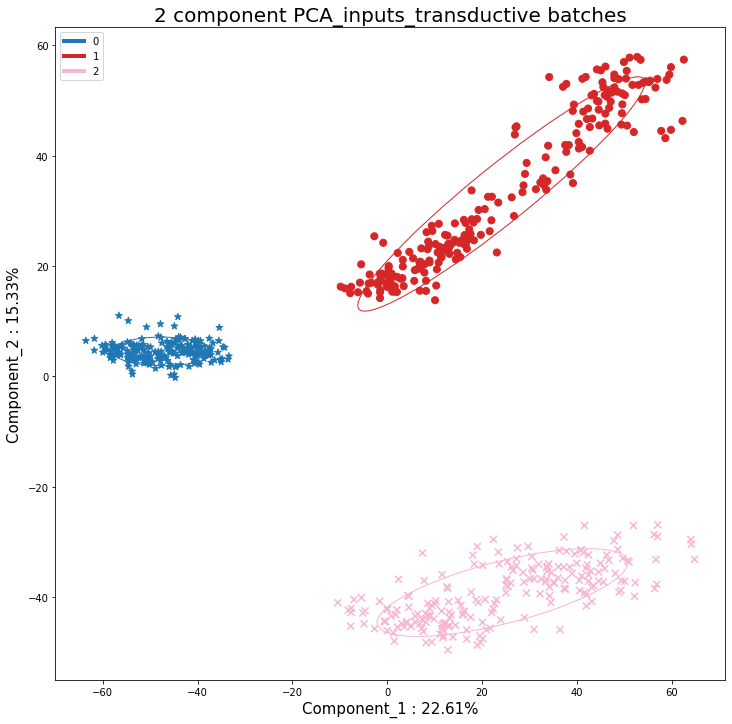

labels


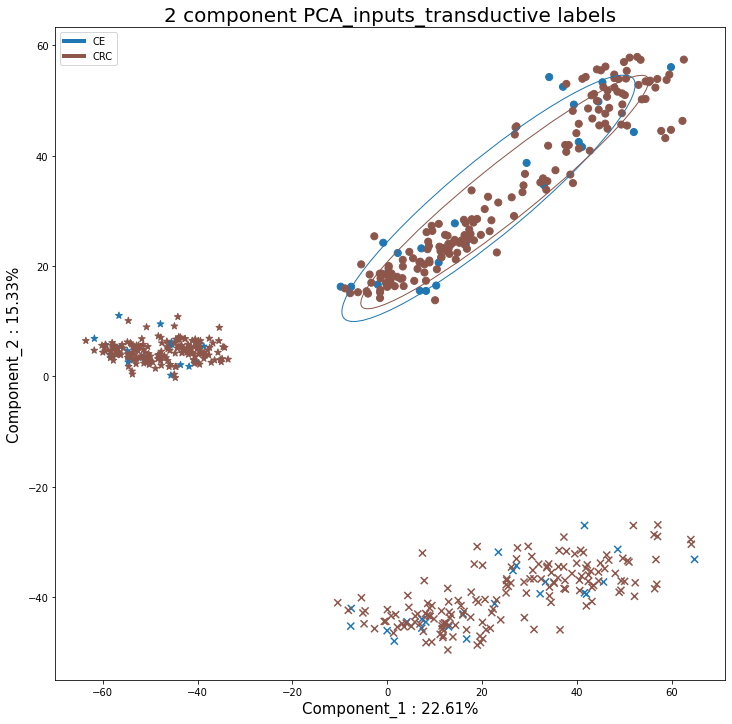

batches


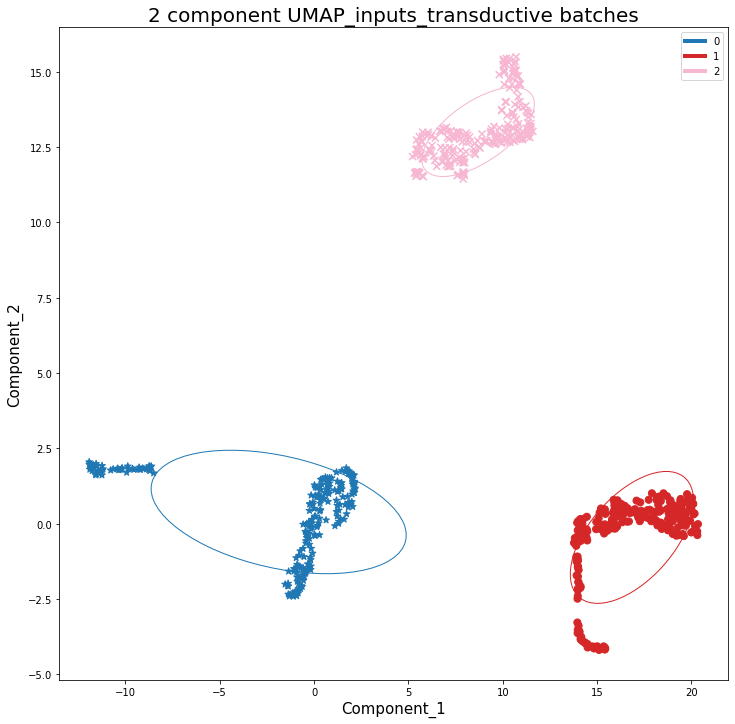

labels


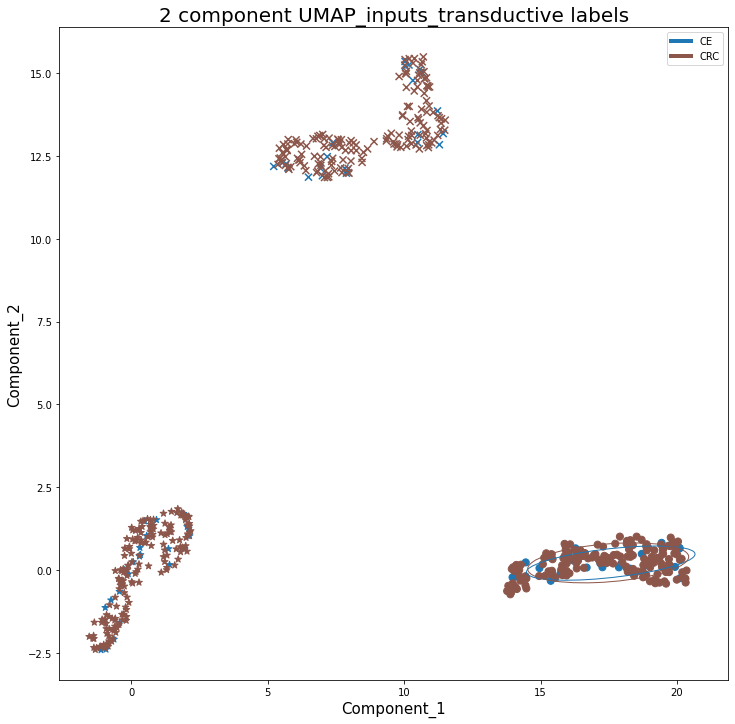

Iteration: 1
-1
valid_score: 0.03675452309466475 h_params: {'tol': 0.9744044165384433, 'max_iter': 933, 'penalty': 'l2', 'C': 9990.405154200935, 'class_weight': 'balanced'}
results/amide/raw/linsvc/0
Iteration: 2
[0.055131784641997125, 0.0, 0.055131784641997125]
valid_score: -0.009116183145740324 h_params: {'tol': 0.0038576507737700483, 'max_iter': 389, 'penalty': 'l2', 'C': 9355.39077252125, 'class_weight': 'balanced'}
Iteration: 3
[0.055131784641997125, 0.0, 0.055131784641997125]
valid_score: 0.09569276552650917 h_params: {'tol': 0.0017909937393907646, 'max_iter': 525, 'penalty': 'l2', 'C': 2295.7729077210424, 'class_weight': 'balanced'}
results/amide/raw/linsvc/0
Iteration: 4
[0.11633501014942219, -0.038778336716474064, 0.20952162314657938]
valid_score: 0.12762656404036454 h_params: {'tol': 0.4527391991788818, 'max_iter': 458, 'penalty': 'l2', 'C': 9391.27795510847, 'class_weight': 'balanced'}
results/amide/raw/linsvc/0
Iteration: 5
[0.19143984606054681, 0.0, 0.19143984606054681]
va

In [30]:
%matplotlib inline
metrics = log_fct(copy.deepcopy(data), unique_labels, 'raw', metrics)
log_ord(copy.deepcopy(data), unique_labels, unique_batches)
train_fct(copy.deepcopy(data), n_meta, train_models, 'raw')


In [31]:
if log_stuff:
    # table = pd.DataFrame(columns=list(metrics['raw']['all'].keys()) + ['delta', 'delta_pool'], index=list(metrics.keys()))
    cols = ['qc_aPCC', '[qc_dist/tot_eucl]', 'lisi', 'silhouette', 'kbet', 'shannon', 'adjusted_rand_score', 'adjusted_mutual_info_score']
    cols_pool = ['pool lisi', 'pool silhouette', 'pool kbet', 'pool shannon', 'pool adjusted_rand_score', 'pool adjusted_mutual_info_score',]
    table = pd.DataFrame(columns=cols + cols_pool, index=list(metrics.keys()))
    # table = table.drop(['qc_dist', 'b_euclidean', 'euclidean', "[b_euclidean/tot_eucl]"], 1)
    for col in cols:
        for row in list(table.index):
            # if 'delta' in col:
            #     table[col][row] = metrics[row][col]
            # else:
            try:
                if isinstance(metrics[row]['all'][col], dict):
                    table[col][row] = metrics[row]['all'][col]["domains"]
                    try:
                        table[f'pool {col}'][row] = metrics[row]['all_pool'][col]["domains"]
                    except:
                        pass
                    # table[col][row]["domains"] = metrics[row]['all'][col]["domains"]
                    # table[col][row]["labels"] = metrics[row]['all'][col]["labels"]
                else:
                    try:
                        table[col][row] = metrics[row]['valid'][col]
                    except:
                        table[col][row] = metrics[row]['all'][col]

            except:
                try:
                    table[col][row] = metrics[row]['all_pool'][col]
                except:
                    table[col][row] = metrics[row]['valid'][col]

table

qc_aPCC [qc_dist/tot_eucl]      lisi silhouette kbet shannon  \
raw  0.815415           0.838954  1.825332   0.232852  0.0    -0.0   

    adjusted_rand_score adjusted_mutual_info_score pool lisi pool silhouette  \
raw                 1.0                        1.0       NaN             NaN   

    pool kbet pool shannon pool adjusted_rand_score  \
raw       NaN          NaN                      NaN   

    pool adjusted_mutual_info_score  
raw                             NaN

# Minmax

In [32]:
path = 'data'
data, _, _ = get_amide(path, args)
unique_labels = get_unique_labels(data['labels']['all'])
unique_batches = np.unique(data['batches']['all'])
unique_cats = np.unique(data['cats']['all'])
n_cats = len(unique_labels)
n_batches = len(unique_batches)

data, _ = scale_data('minmax', data, device='cpu')

Imputing zeros.


Mann      pval min    n pvals < 0.05
------  -  -
CE_CRC  0  1
------  -  -
ttests
------  -----------  ---
CE_CRC  3.38244e-07  239
------  -----------  ---


batches


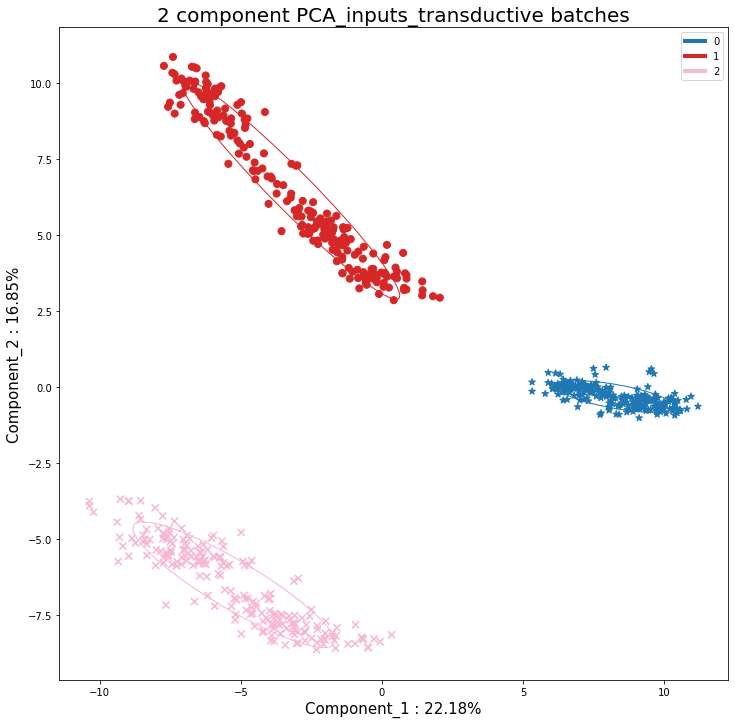

labels


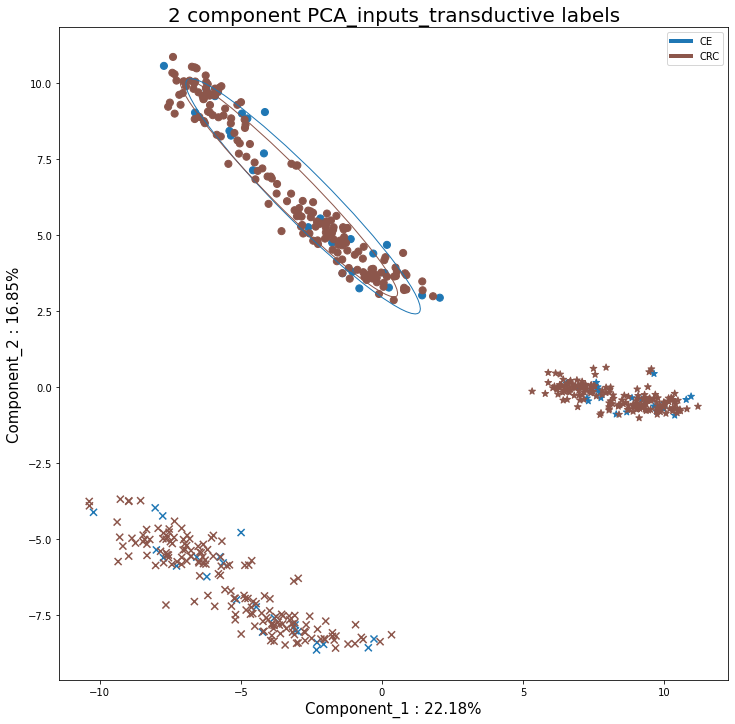

batches


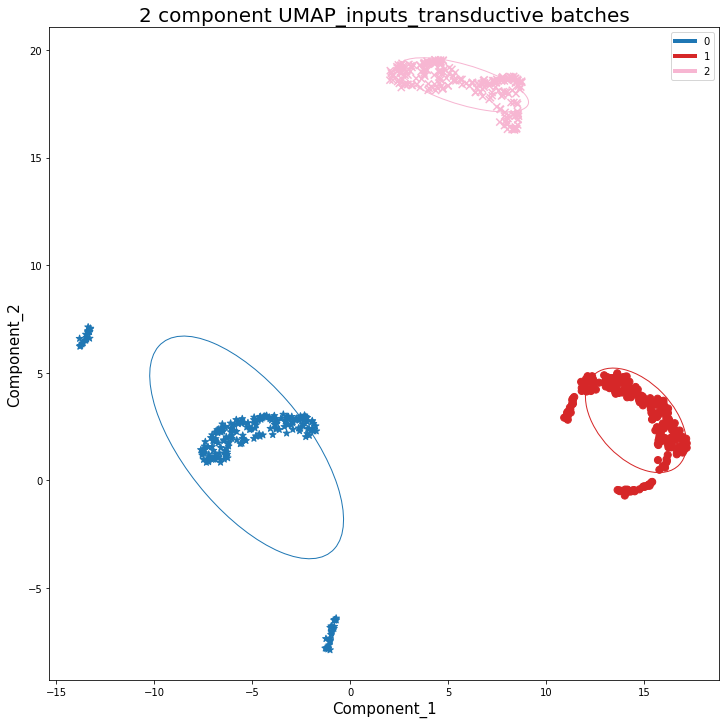

labels


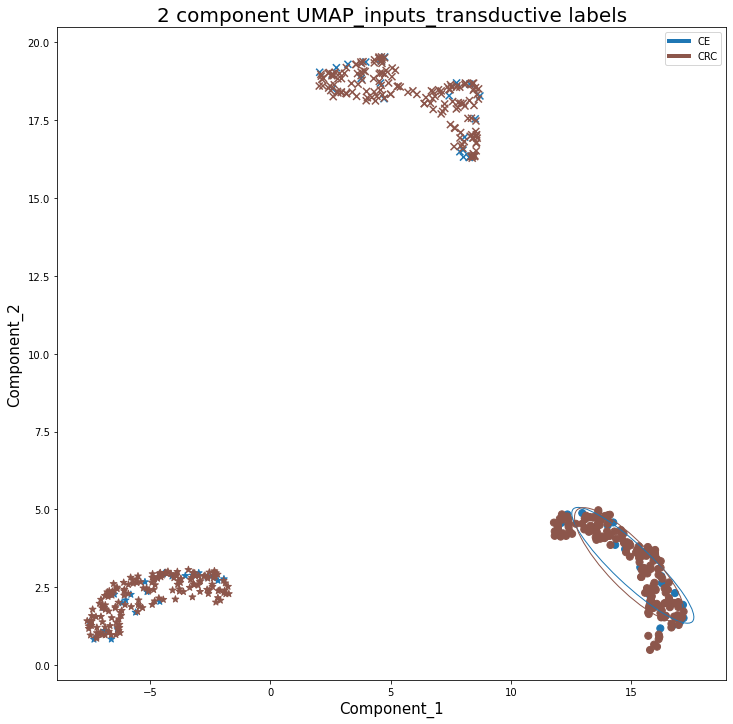

Iteration: 1
-1
valid_score: 0.029662153570733735 h_params: {'tol': 0.9744044165384433, 'max_iter': 933, 'penalty': 'l2', 'C': 9990.405154200935, 'class_weight': 'balanced'}
results/amide/minmax/linsvc/0
Iteration: 2
[0.0, -0.027348549437220974, 0.11633501014942219]
valid_score: 0.07755667343294813 h_params: {'tol': 0.0038576507737700483, 'max_iter': 389, 'penalty': 'l2', 'C': 9355.39077252125, 'class_weight': 'balanced'}
results/amide/minmax/linsvc/0
Iteration: 3
[0.11633501014942219, 0.0, 0.11633501014942219]
valid_score: 0.07755667343294813 h_params: {'tol': 0.0017909937393907646, 'max_iter': 525, 'penalty': 'l2', 'C': 2295.7729077210424, 'class_weight': 'balanced'}
Iteration: 4
[0.11633501014942219, 0.0, 0.11633501014942219]
valid_score: 0.07755667343294813 h_params: {'tol': 0.4527391991788818, 'max_iter': 458, 'penalty': 'l2', 'C': 9391.27795510847, 'class_weight': 'balanced'}
Iteration: 5
[0.11633501014942219, 0.0, 0.11633501014942219]
valid_score: 0.07755667343294813 h_params: {

In [33]:
%matplotlib inline
metrics = log_fct(copy.deepcopy(data), unique_labels, 'minmax', metrics)
log_ord(copy.deepcopy(data), unique_labels, unique_batches)
train_fct(copy.deepcopy(data), n_meta, train_models, 'minmax')


# Minmax per batch

In [34]:
path = 'data'
data, _, _ = get_amide(path, args)
unique_labels = get_unique_labels(data['labels']['all'])
unique_batches = np.unique(data['batches']['all'])
unique_cats = np.unique(data['cats']['all'])
n_cats = len(unique_labels)
n_batches = len(unique_batches)

data, _ = scale_data('minmax_per_batch', data, device='cpu')

Imputing zeros.


Mann      pval min    n pvals < 0.05
------  -  -
CE_CRC  0  1
------  -  -
ttests
------  -----------  ---
CE_CRC  6.36696e-05  226
------  -----------  ---


batches


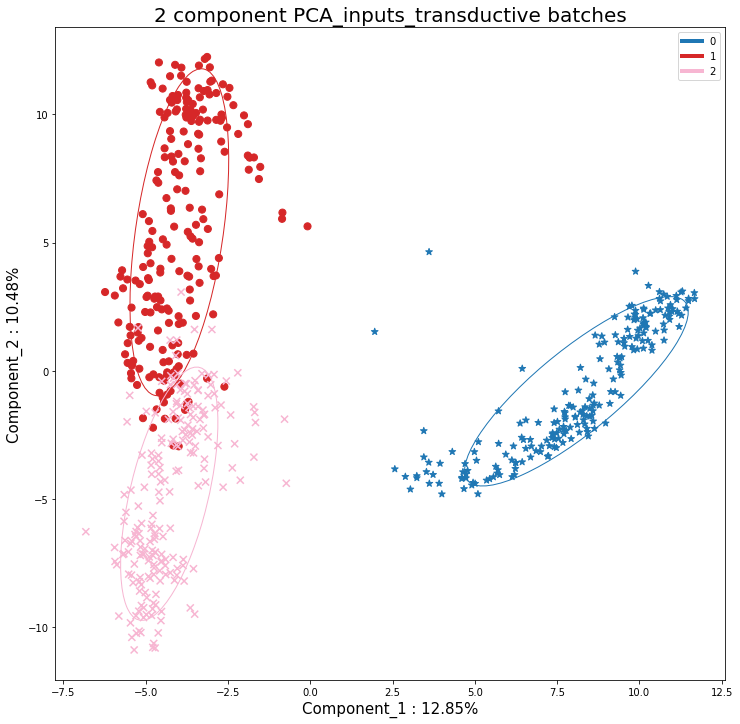

labels


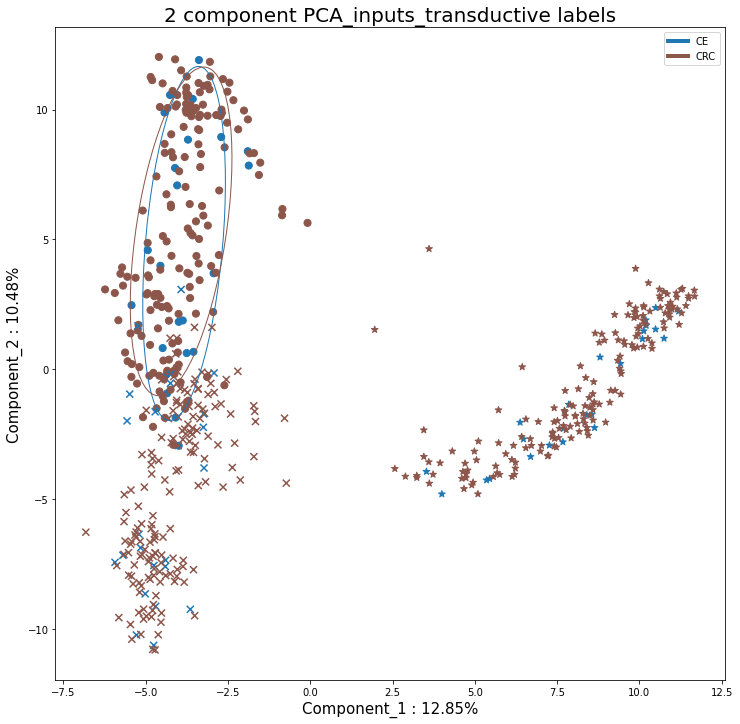

batches


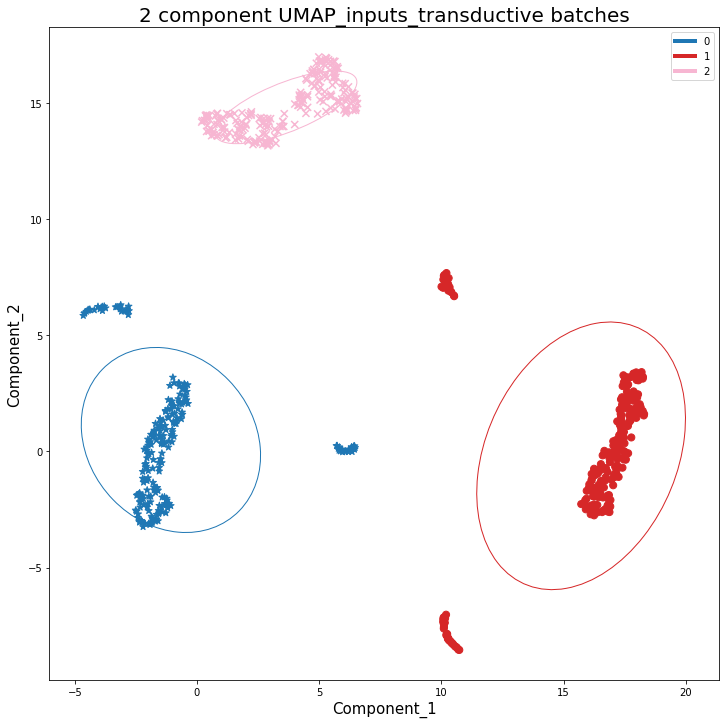

labels


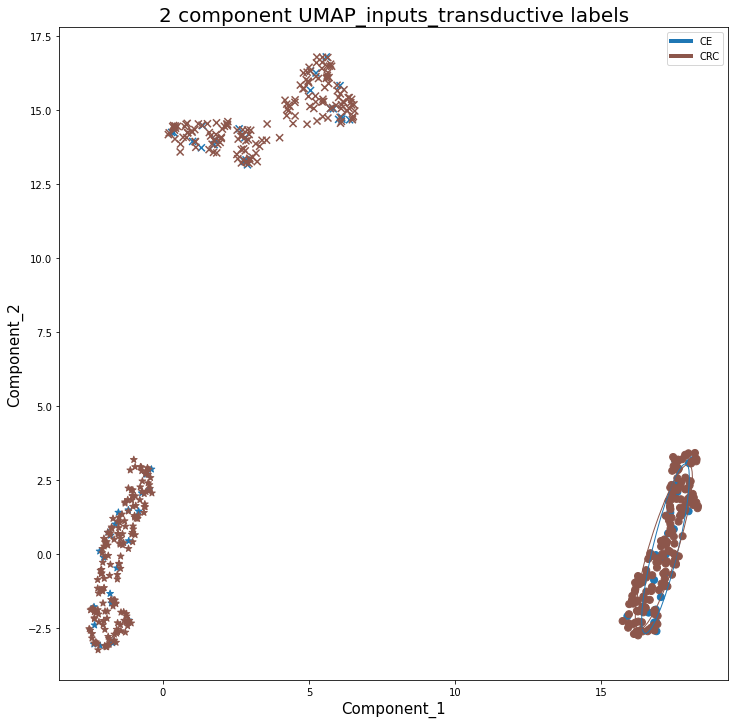

Iteration: 1
-1
valid_score: -0.01823236629148065 h_params: {'tol': 0.9744044165384433, 'max_iter': 933, 'penalty': 'l2', 'C': 9990.405154200935, 'class_weight': 'balanced'}
results/amide/minmax_per_batch/linsvc/0
Iteration: 2
[0.0, -0.027348549437220974, -0.027348549437220974]
valid_score: -0.01823236629148065 h_params: {'tol': 0.0038576507737700483, 'max_iter': 389, 'penalty': 'l2', 'C': 9355.39077252125, 'class_weight': 'balanced'}
Iteration: 3
[0.0, -0.027348549437220974, -0.027348549437220974]
valid_score: -0.01823236629148065 h_params: {'tol': 0.0017909937393907646, 'max_iter': 525, 'penalty': 'l2', 'C': 2295.7729077210424, 'class_weight': 'balanced'}
Iteration: 4
[0.0, -0.027348549437220974, -0.027348549437220974]
valid_score: 0.0 h_params: {'tol': 0.4527391991788818, 'max_iter': 458, 'penalty': 'l2', 'C': 9391.27795510847, 'class_weight': 'balanced'}
results/amide/minmax_per_batch/linsvc/0
Iteration: 5
[0.0, 0.0, 0.0]
valid_score: -0.01823236629148065 h_params: {'tol': 0.073094

In [35]:
%matplotlib inline
metrics = log_fct(copy.deepcopy(data), unique_labels, 'minmax_per_batch', metrics)
log_ord(copy.deepcopy(data), unique_labels, unique_batches)
train_fct(copy.deepcopy(data), n_meta, train_models, 'minmax_per_batch')


# Standard

In [36]:
path = 'data'
data, _, _ = get_amide(path, args)
unique_labels = get_unique_labels(data['labels']['all'])
unique_batches = np.unique(data['batches']['all'])
unique_cats = np.unique(data['cats']['all'])
n_cats = len(unique_labels)
n_batches = len(unique_batches)

data, _ = scale_data('standard', data, device='cpu')

Imputing zeros.


Mann      pval min    n pvals < 0.05
------  -  -
CE_CRC  0  1
------  -  -
ttests
------  -----------  ---
CE_CRC  3.38244e-07  239
------  -----------  ---
batches


labels


batches


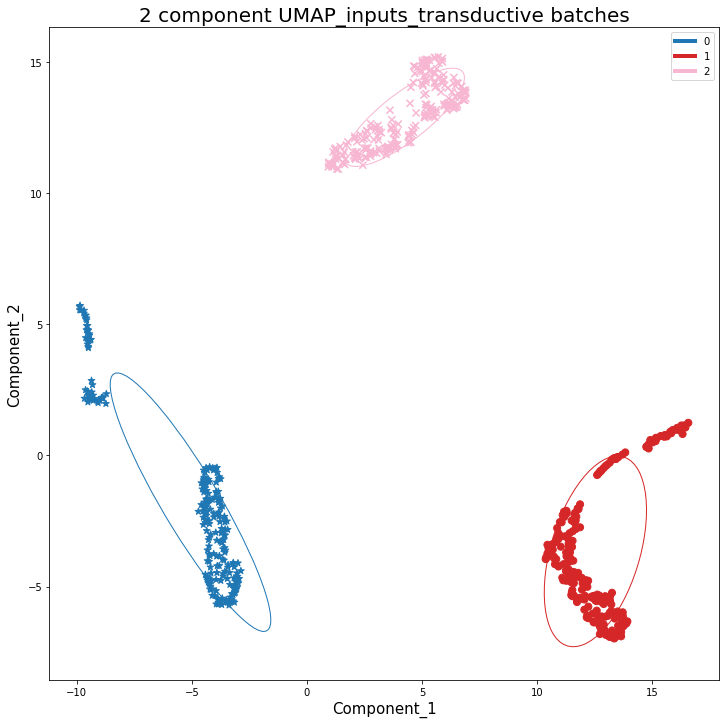

labels


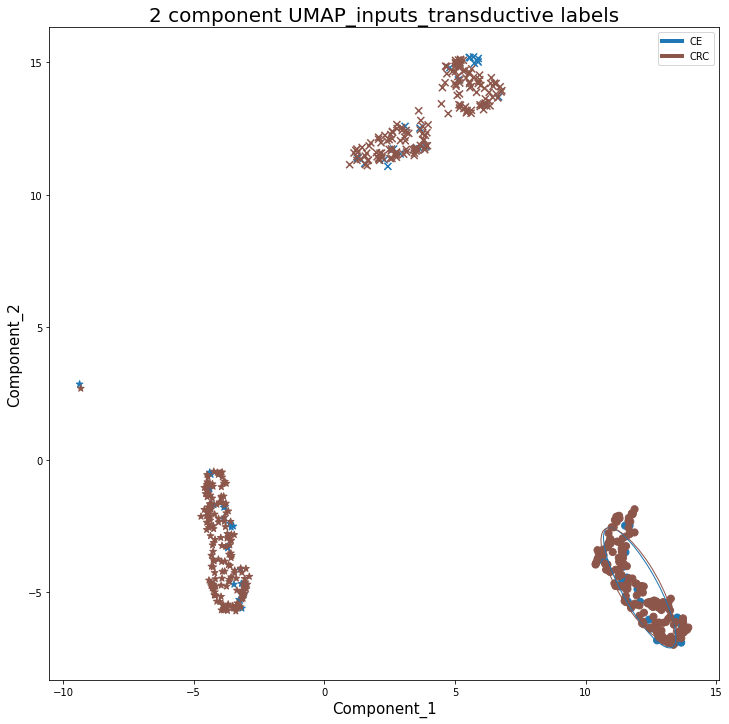

Iteration: 1
-1
valid_score: 0.09714318459358234 h_params: {'tol': 0.9744044165384433, 'max_iter': 933, 'penalty': 'l2', 'C': 9990.405154200935, 'class_weight': 'balanced'}
results/amide/standard/linsvc/0
Iteration: 2
[0.08571428571428572, 0.09317685232394167, 0.11253841574251965]
valid_score: 0.11554353225282743 h_params: {'tol': 0.0038576507737700483, 'max_iter': 389, 'penalty': 'l2', 'C': 9355.39077252125, 'class_weight': 'balanced'}
results/amide/standard/linsvc/0
Iteration: 3
[0.11633501014942219, 0.11396057645963795, 0.11633501014942219]
valid_score: 0.11554353225282743 h_params: {'tol': 0.0017909937393907646, 'max_iter': 525, 'penalty': 'l2', 'C': 2295.7729077210424, 'class_weight': 'balanced'}
Iteration: 4
[0.11633501014942219, 0.11396057645963795, 0.11633501014942219]
valid_score: 0.095983299353598 h_params: {'tol': 0.4527391991788818, 'max_iter': 458, 'penalty': 'l2', 'C': 9391.27795510847, 'class_weight': 'balanced'}
Iteration: 5
[0.11633501014942219, 0.11396057645963795, 0.

In [37]:
%matplotlib inline
metrics = log_fct(copy.deepcopy(data), unique_labels, 'standard', metrics)
log_ord(copy.deepcopy(data), unique_labels, unique_batches)
train_fct(copy.deepcopy(data), n_meta, train_models, 'standard')


# Standard per batch

In [38]:
path = 'data'
data, _, _ = get_amide(path, args)
unique_labels = get_unique_labels(data['labels']['all'])
unique_batches = np.unique(data['batches']['all'])
unique_cats = np.unique(data['cats']['all'])
n_cats = len(unique_labels)
n_batches = len(unique_batches)

data, _ = scale_data('standard_per_batch', data, device='cpu')

Imputing zeros.


Mann      pval min    n pvals < 0.05
------  -  -
CE_CRC  0  1
------  -  -
ttests
------  -----------  ---
CE_CRC  1.24152e-07  370
------  -----------  ---
batches


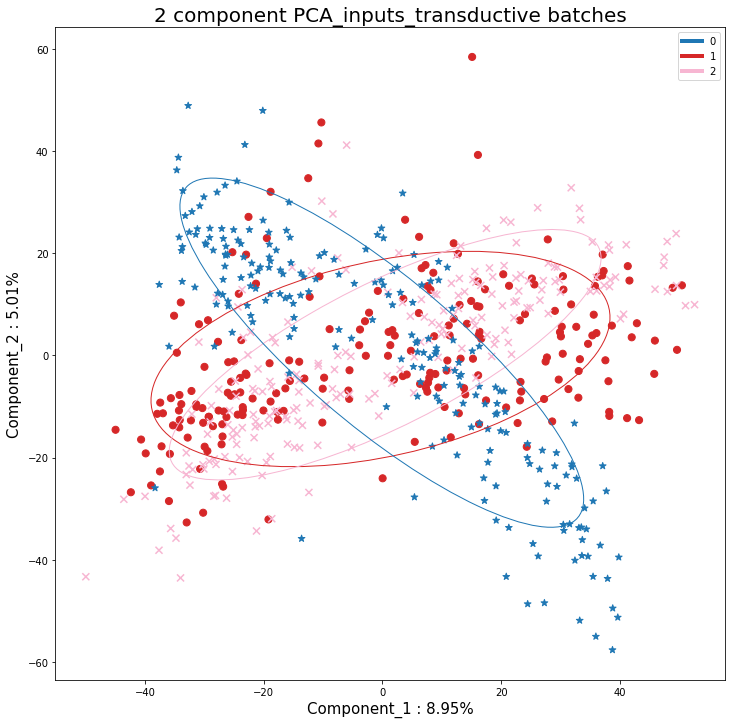

labels


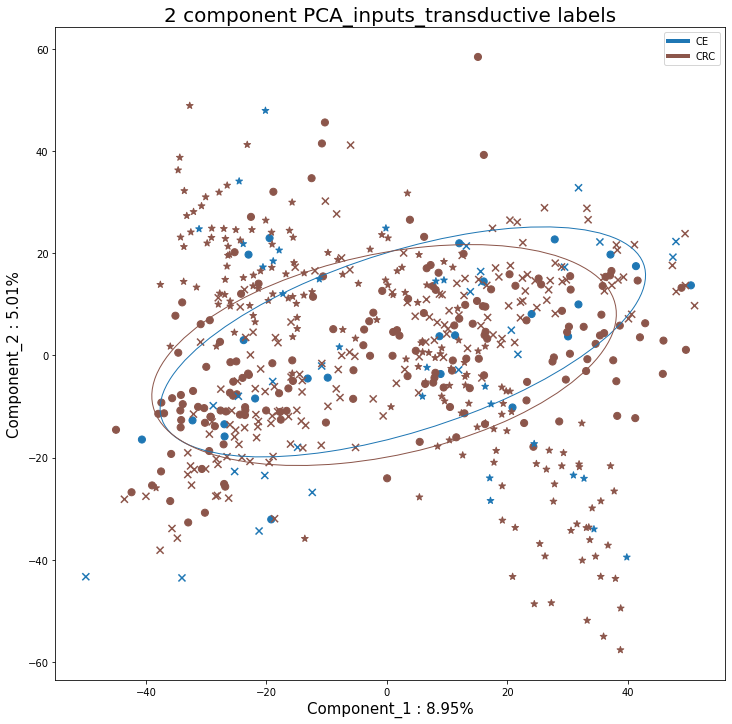

batches


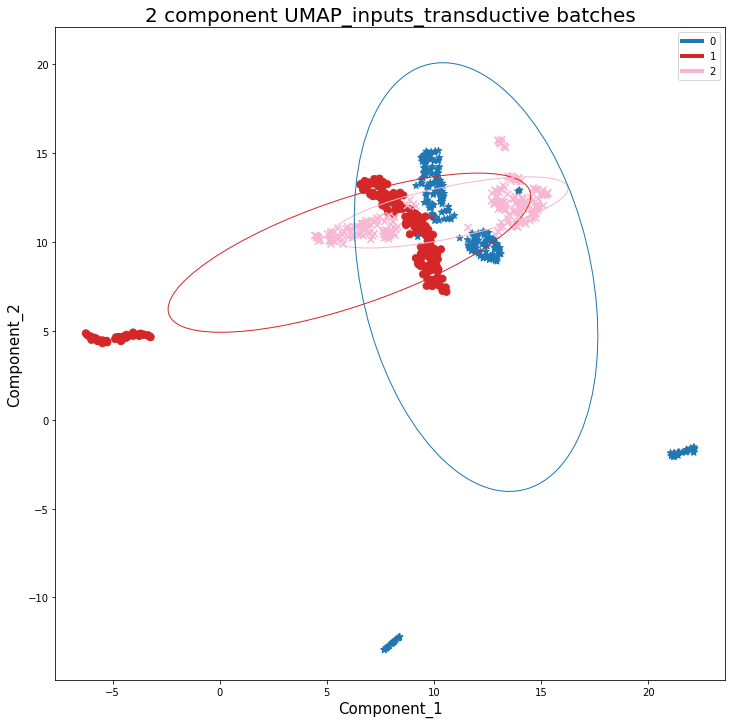

labels


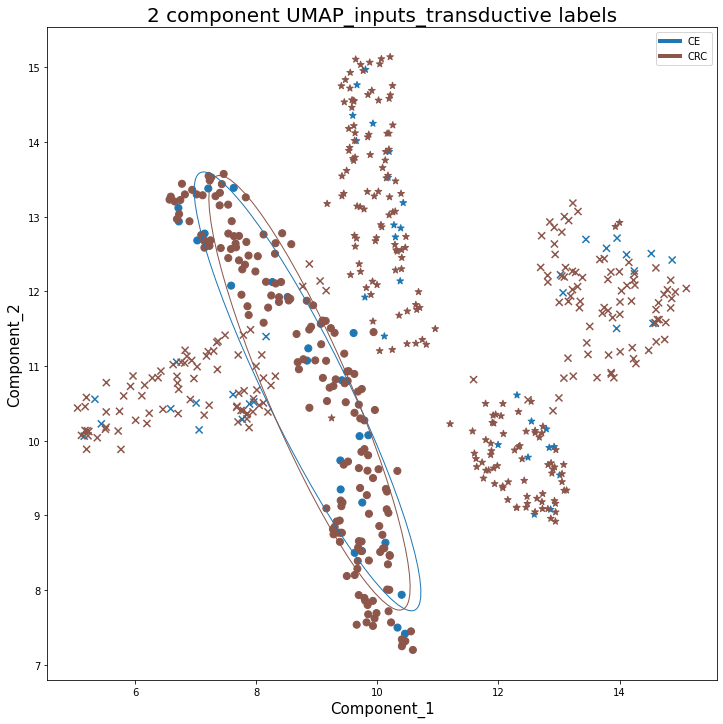

Iteration: 1
-1
valid_score: 0.09983331317324451 h_params: {'tol': 0.9744044165384433, 'max_iter': 933, 'penalty': 'l2', 'C': 9990.405154200935, 'class_weight': 'balanced'}
results/amide/standard_per_batch/linsvc/0
Iteration: 2
[0.1107739502333261, 0.07795203905308133, 0.1107739502333261]
valid_score: 0.09983331317324451 h_params: {'tol': 0.0038576507737700483, 'max_iter': 389, 'penalty': 'l2', 'C': 9355.39077252125, 'class_weight': 'balanced'}
Iteration: 3
[0.1107739502333261, 0.07795203905308133, 0.1107739502333261]
valid_score: 0.09983331317324451 h_params: {'tol': 0.0017909937393907646, 'max_iter': 525, 'penalty': 'l2', 'C': 2295.7729077210424, 'class_weight': 'balanced'}
Iteration: 4
[0.1107739502333261, 0.07795203905308133, 0.1107739502333261]
valid_score: 0.09037514588598089 h_params: {'tol': 0.4527391991788818, 'max_iter': 458, 'penalty': 'l2', 'C': 9391.27795510847, 'class_weight': 'balanced'}
Iteration: 5
[0.1107739502333261, 0.07795203905308133, 0.1107739502333261]
valid_sco

In [39]:
%matplotlib inline
metrics = log_fct(copy.deepcopy(data), unique_labels, 'standard_per_batch', metrics)
log_ord(copy.deepcopy(data), unique_labels, unique_batches)
train_fct(copy.deepcopy(data), n_meta, train_models, 'standard_per_batch')


# Robust

In [40]:
path = 'data'
data, _, _ = get_amide(path, args)
unique_labels = get_unique_labels(data['labels']['all'])
unique_batches = np.unique(data['batches']['all'])
unique_cats = np.unique(data['cats']['all'])
n_cats = len(unique_labels)
n_batches = len(unique_batches)

data, _ = scale_data('robust', data, device='cpu')

Imputing zeros.


sel = VarianceThreshold(threshold=0.16)
sel.fit(data['inputs']['all'])
features = np.array([int(x.split('x')[1]) for x in sel.get_feature_names_out()])
data['inputs']['all'] = data['inputs']['all'].iloc[:, features]
data['inputs']['all_pool'] = data['inputs']['all_pool'].iloc[:, features]
data['inputs']['train'] = data['inputs']['train'].iloc[:, features]
data['inputs']['train_pool'] = data['inputs']['train_pool'].iloc[:, features]
data['inputs']['valid'] = data['inputs']['valid'].iloc[:, features]
data['inputs']['valid_pool'] = data['inputs']['valid_pool'].iloc[:, features]
data['inputs']['test'] = data['inputs']['test'].iloc[:, features]
data['inputs']['test_pool'] = data['inputs']['test_pool'].iloc[:, features]

Mann      pval min    n pvals < 0.05
------  -  -
CE_CRC  0  1
------  -  -
ttests
------  -----------  ---
CE_CRC  3.38244e-07  239
------  -----------  ---
batches


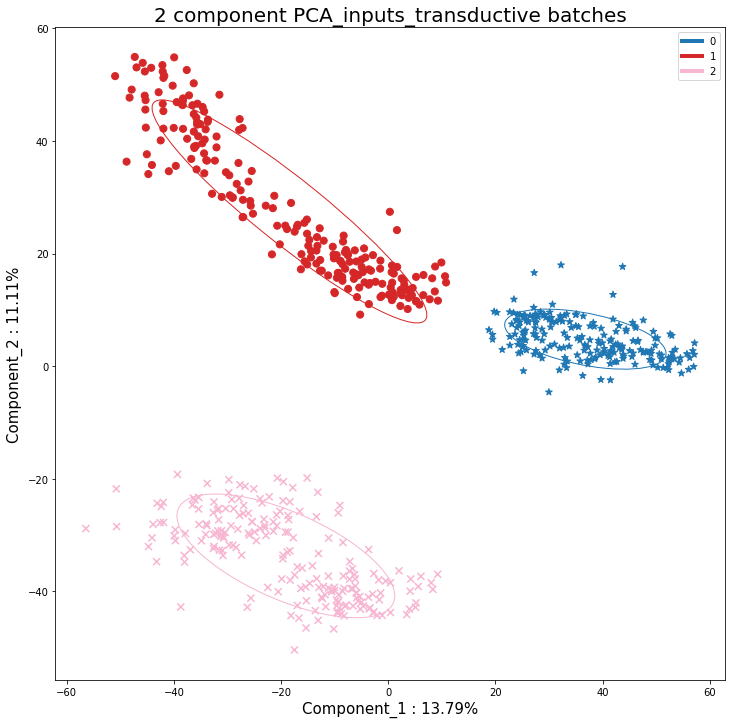

labels


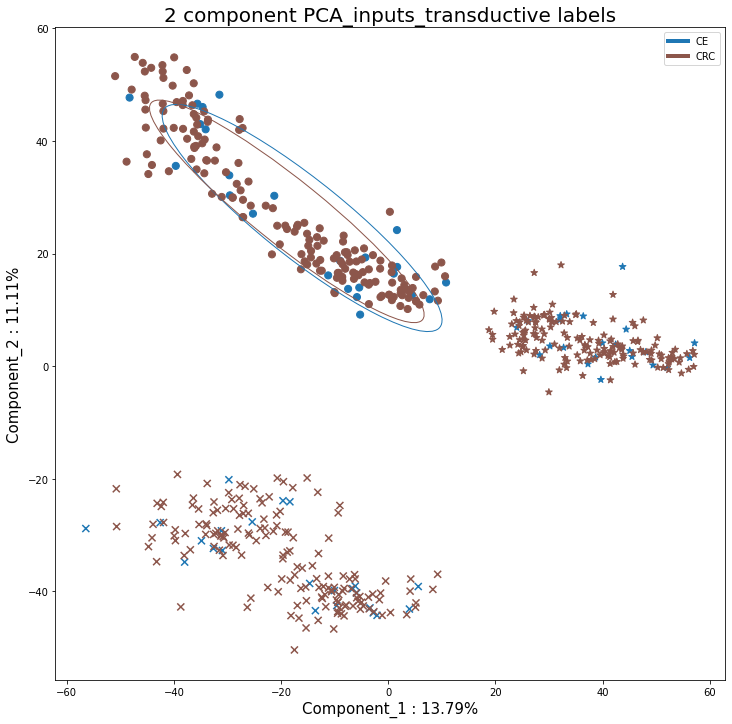

batches


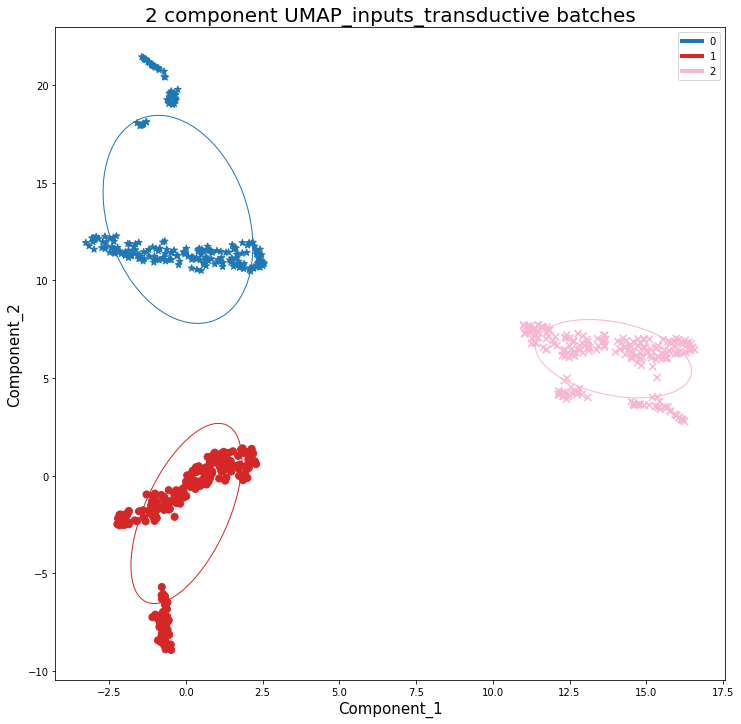

labels


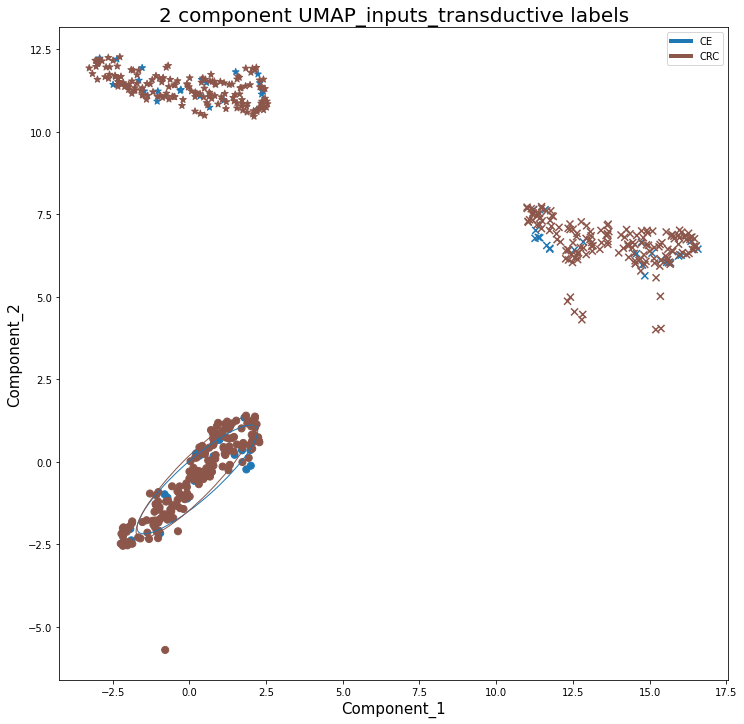

Iteration: 1
-1
valid_score: 0.05940853790185963 h_params: {'tol': 0.9744044165384433, 'max_iter': 933, 'penalty': 'l2', 'C': 9990.405154200935, 'class_weight': 'balanced'}
results/amide/robust/linsvc/0
Iteration: 2
[0.02964490559426034, 0.1721905795545492, -0.023609871443230616]
valid_score: 0.062284003839459735 h_params: {'tol': 0.0038576507737700483, 'max_iter': 389, 'penalty': 'l2', 'C': 9355.39077252125, 'class_weight': 'balanced'}
results/amide/robust/linsvc/0
Iteration: 3
[0.01416592286593837, 0.15852016578650246, 0.01416592286593837]
valid_score: 0.062284003839459735 h_params: {'tol': 0.0017909937393907646, 'max_iter': 525, 'penalty': 'l2', 'C': 2295.7729077210424, 'class_weight': 'balanced'}
Iteration: 4
[0.01416592286593837, 0.15852016578650246, 0.01416592286593837]
valid_score: 0.06247228910162992 h_params: {'tol': 0.4527391991788818, 'max_iter': 458, 'penalty': 'l2', 'C': 9391.27795510847, 'class_weight': 'balanced'}
results/amide/robust/linsvc/0
Iteration: 5
[0.03877833671

In [41]:
%matplotlib inline
metrics = log_fct(copy.deepcopy(data), unique_labels, 'robust', metrics)
log_ord(copy.deepcopy(data), unique_labels, unique_batches)
train_fct(copy.deepcopy(data), n_meta, train_models, 'robust')


# Robust per batch

In [42]:
path = 'data'
data, _, _ = get_amide(path, args)
unique_labels = get_unique_labels(data['labels']['all'])
unique_batches = np.unique(data['batches']['all'])
unique_cats = np.unique(data['cats']['all'])
n_cats = len(unique_labels)
n_batches = len(unique_batches)

data, _ = scale_data('robust_per_batch', data, device='cpu')

Imputing zeros.


sel = VarianceThreshold(threshold=0.16)
sel.fit(data['inputs']['all'])
features = np.array([int(x.split('x')[1]) for x in sel.get_feature_names_out()])
data['inputs']['all'] = data['inputs']['all'].iloc[:, features]
data['inputs']['all_pool'] = data['inputs']['all_pool'].iloc[:, features]
data['inputs']['train'] = data['inputs']['train'].iloc[:, features]
data['inputs']['train_pool'] = data['inputs']['train_pool'].iloc[:, features]
data['inputs']['valid'] = data['inputs']['valid'].iloc[:, features]
data['inputs']['valid_pool'] = data['inputs']['valid_pool'].iloc[:, features]
data['inputs']['test'] = data['inputs']['test'].iloc[:, features]
data['inputs']['test_pool'] = data['inputs']['test_pool'].iloc[:, features]

Mann      pval min    n pvals < 0.05
------  -  -
CE_CRC  0  1
------  -  -
ttests
------  -----------  ---
CE_CRC  1.44731e-07  392
------  -----------  ---
batches


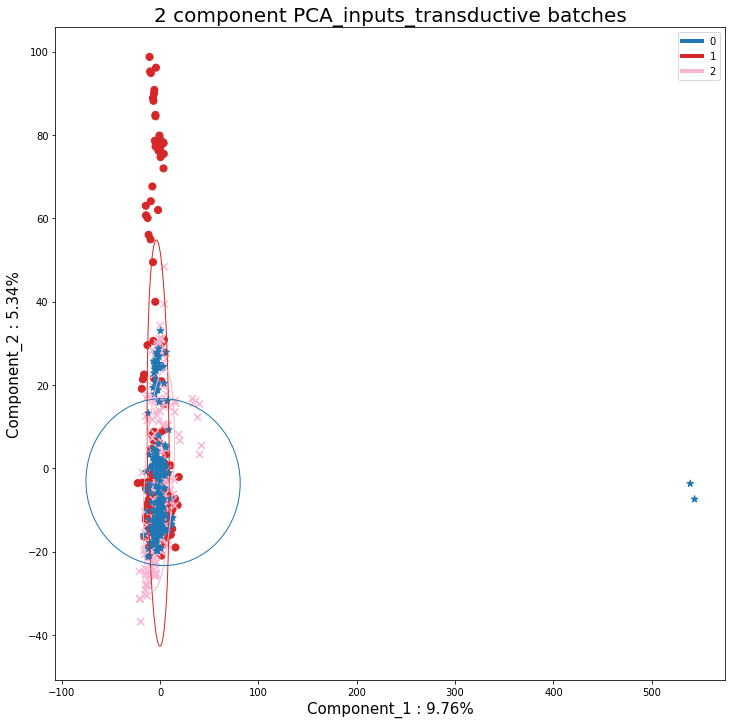

labels


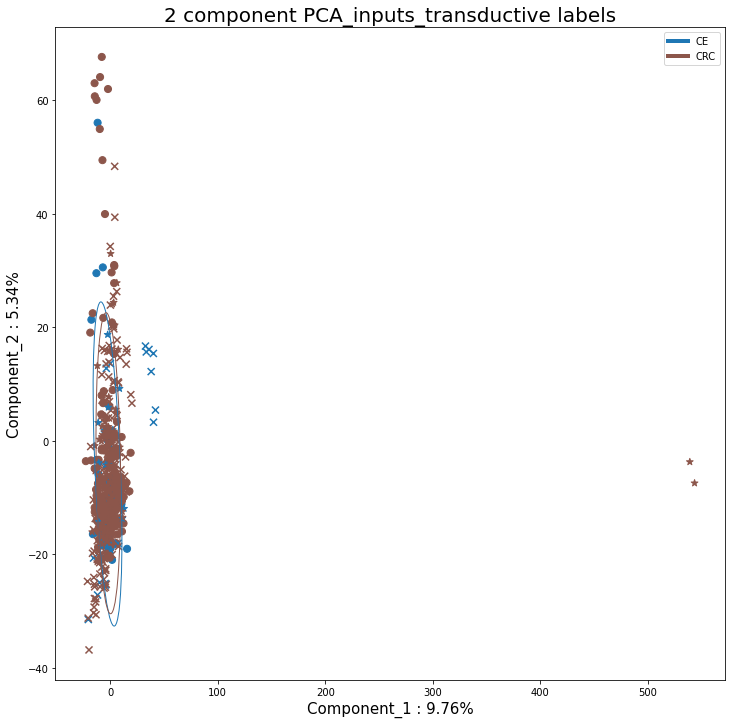

batches


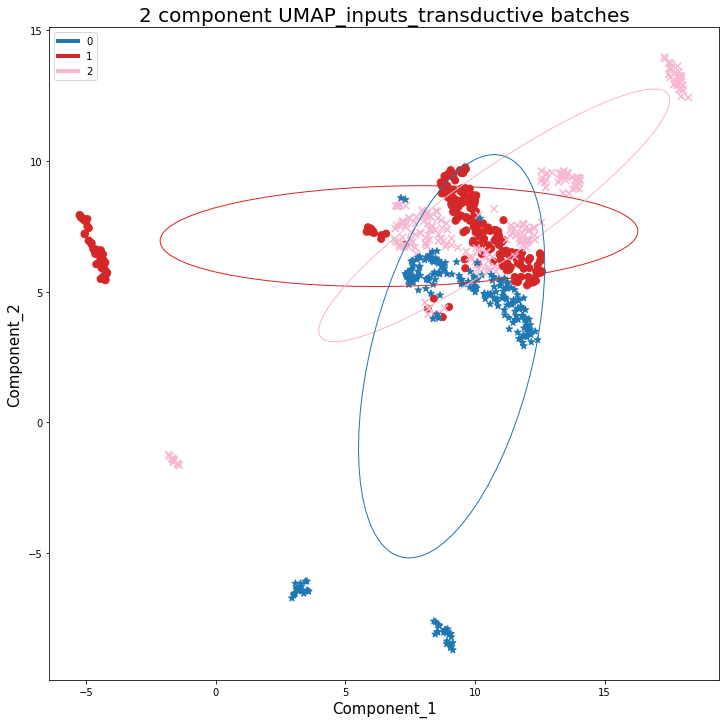

labels


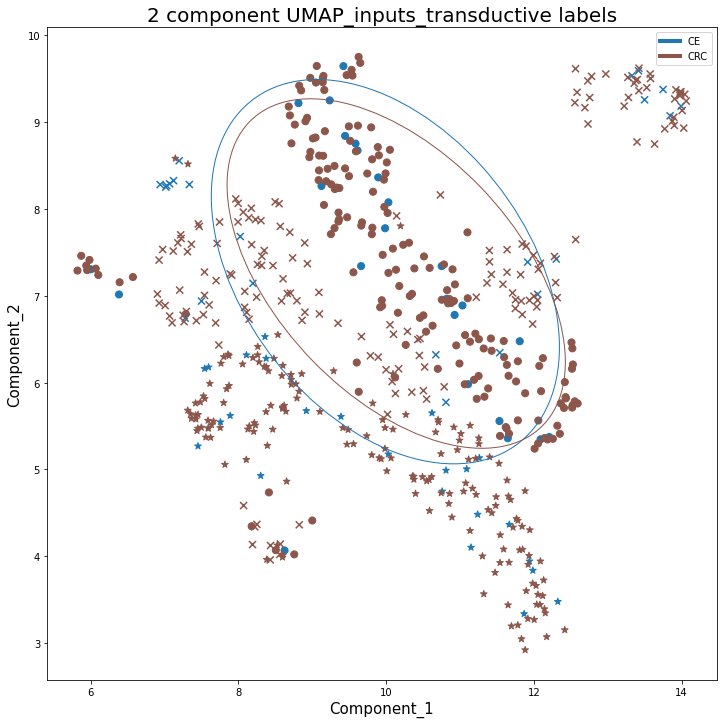

Iteration: 1
-1
valid_score: 0.10478305175574743 h_params: {'tol': 0.9744044165384433, 'max_iter': 933, 'penalty': 'l2', 'C': 9990.405154200935, 'class_weight': 'balanced'}
results/amide/robust_per_batch/linsvc/0
Iteration: 2
[0.1267731382092775, 0.10306059158511316, 0.08451542547285165]
valid_score: 0.13037341863037283 h_params: {'tol': 0.0038576507737700483, 'max_iter': 389, 'penalty': 'l2', 'C': 9355.39077252125, 'class_weight': 'balanced'}
results/amide/robust_per_batch/linsvc/0
Iteration: 3
[0.11345030265838622, 0.164219650574346, 0.11345030265838622]
valid_score: 0.13037341863037283 h_params: {'tol': 0.0017909937393907646, 'max_iter': 525, 'penalty': 'l2', 'C': 2295.7729077210424, 'class_weight': 'balanced'}
Iteration: 4
[0.11345030265838622, 0.164219650574346, 0.11345030265838622]
valid_score: 0.1347476275602291 h_params: {'tol': 0.4527391991788818, 'max_iter': 458, 'penalty': 'l2', 'C': 9391.27795510847, 'class_weight': 'balanced'}
results/amide/robust_per_batch/linsvc/0
Iterat

In [43]:
%matplotlib inline
metrics = log_fct(copy.deepcopy(data), unique_labels, 'robust_per_batch', metrics)
log_ord(copy.deepcopy(data), unique_labels, unique_batches)
train_fct(copy.deepcopy(data), n_meta, train_models, 'robust_per_batch')


# Combat

In [44]:
path = 'data'
data, _, _ = get_amide(path, args)
unique_labels = get_unique_labels(data['labels']['all'])
unique_batches = np.unique(data['batches']['all'])
unique_cats = np.unique(data['cats']['all'])
n_cats = len(unique_labels)
n_batches = len(unique_batches)

data, _ = scale_data('raw', data, device='cpu')
data = remove_batch_effect(get_berm('combat'), data)


Imputing zeros.
not with classes!


R[write to console]: Found3batches

R[write to console]: Adjusting for0covariate(s) or covariate level(s)

R[write to console]: Standardizing Data across genes

R[write to console]: Fitting L/S model and finding priors

R[write to console]: Finding parametric adjustments

R[write to console]: Adjusting the Data




train 0
valid 192
test 376
train_pool 568
valid_pool 593
test_pool 618


Mann      pval min    n pvals < 0.05
------  -  -
CE_CRC  0  1
------  -  -
ttests
------  --------  -
CE_CRC  0.291206  0
------  --------  -
batches


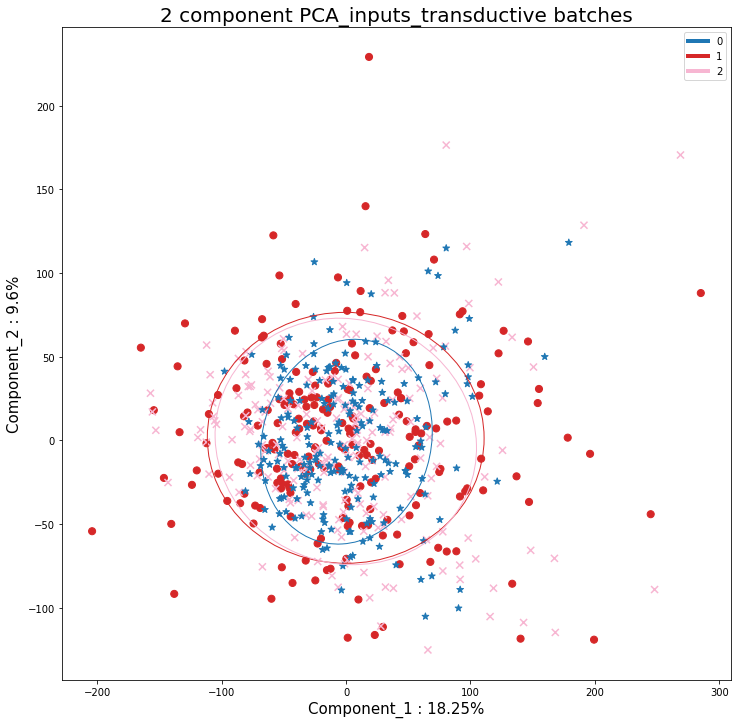

labels


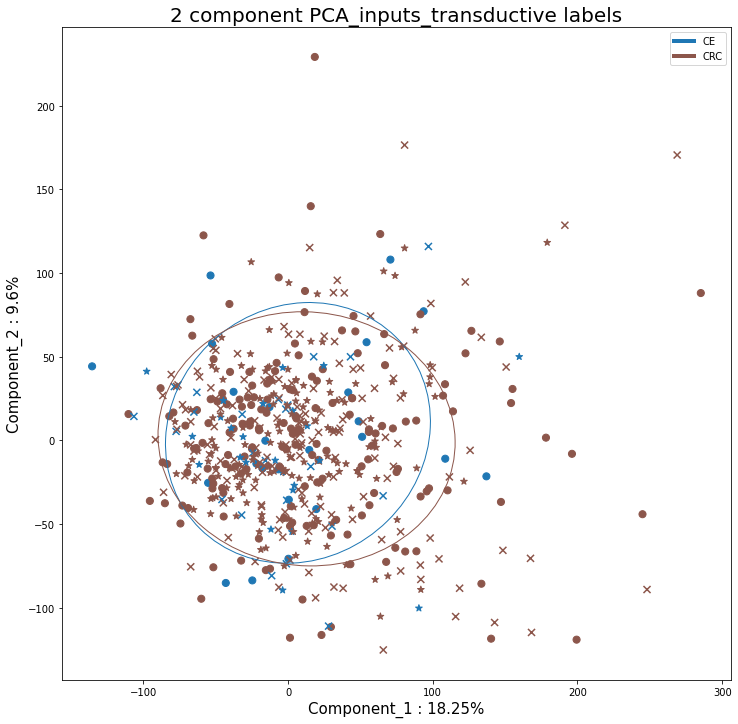

batches


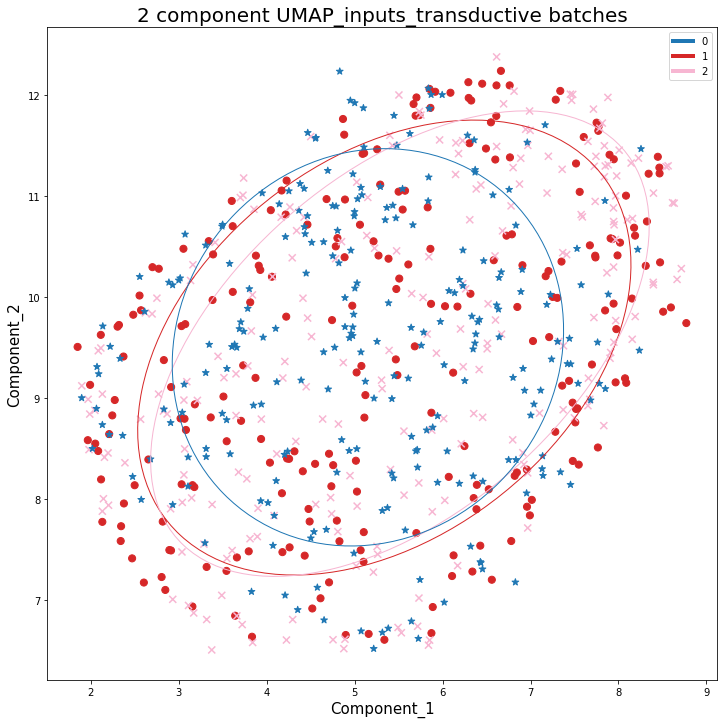

labels


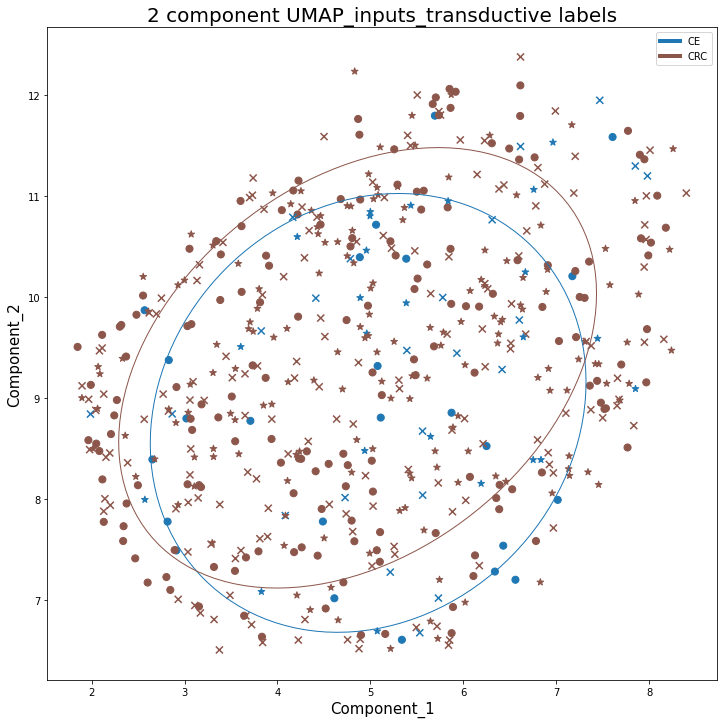

Iteration: 1
-1
valid_score: 0.08047560086346331 h_params: {'tol': 0.9744044165384433, 'max_iter': 933, 'penalty': 'l2', 'C': 9990.405154200935, 'class_weight': 'balanced'}
results/amide/combat/linsvc/0
Iteration: 2
[0.11633501014942219, 0.008756782291545563, 0.11633501014942219]
valid_score: 0.05304951936315453 h_params: {'tol': 0.0038576507737700483, 'max_iter': 389, 'penalty': 'l2', 'C': 9355.39077252125, 'class_weight': 'balanced'}
Iteration: 3
[0.11633501014942219, 0.008756782291545563, 0.11633501014942219]
valid_score: 0.01224736902487116 h_params: {'tol': 0.0017909937393907646, 'max_iter': 525, 'penalty': 'l2', 'C': 2295.7729077210424, 'class_weight': 'balanced'}
Iteration: 4
[0.11633501014942219, 0.008756782291545563, 0.11633501014942219]
valid_score: 0.051286326558311425 h_params: {'tol': 0.4527391991788818, 'max_iter': 458, 'penalty': 'l2', 'C': 9391.27795510847, 'class_weight': 'balanced'}
Iteration: 5
[0.11633501014942219, 0.008756782291545563, 0.11633501014942219]
valid_sc

In [45]:
%matplotlib inline
metrics = log_fct(copy.deepcopy(data), unique_labels, 'combat', metrics)
log_ord(copy.deepcopy(data), unique_labels, unique_batches)
train_fct(copy.deepcopy(data), n_meta, train_models, 'combat')


# pyCombat

In [46]:
from combat.pycombat import pycombat
path = 'data'
data, _, _ = get_amide(path, args)
unique_labels = get_unique_labels(data['labels']['all'])
unique_batches = np.unique(data['batches']['all'])
unique_cats = np.unique(data['cats']['all'])
n_cats = len(unique_labels)
n_batches = len(unique_batches)

data, _ = scale_data('raw', data, device='cpu')
data = use_pycombat(pycombat, data)


Imputing zeros.
Found 3 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data


Mann      pval min    n pvals < 0.05
------  -  -
CE_CRC  0  1
------  -  -
ttests
------  -----------  ---
CE_CRC  1.28575e-07  379
------  -----------  ---
batches


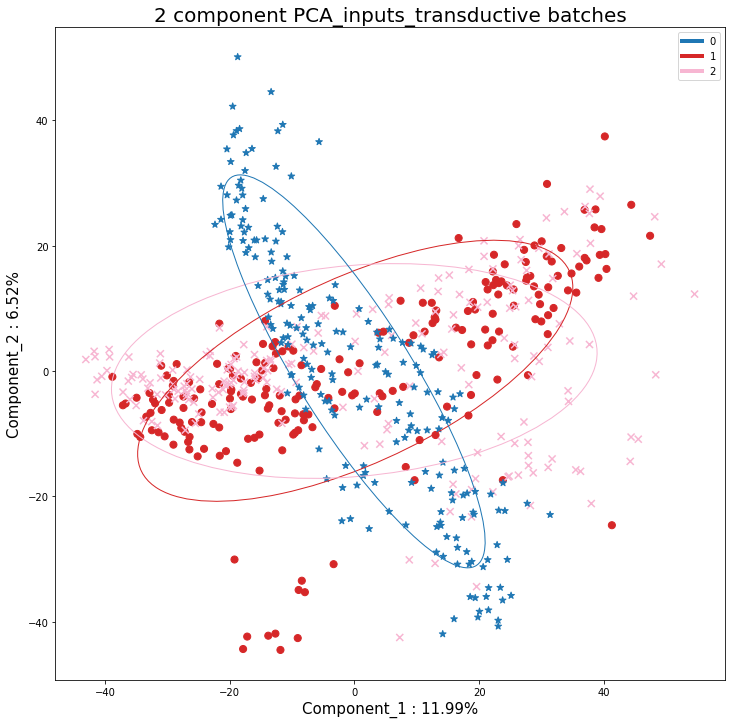

labels


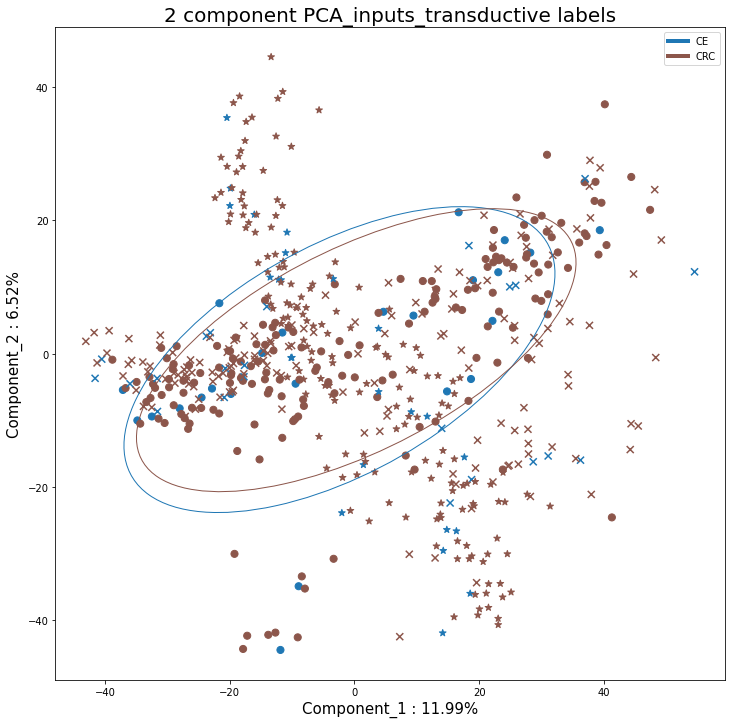

batches


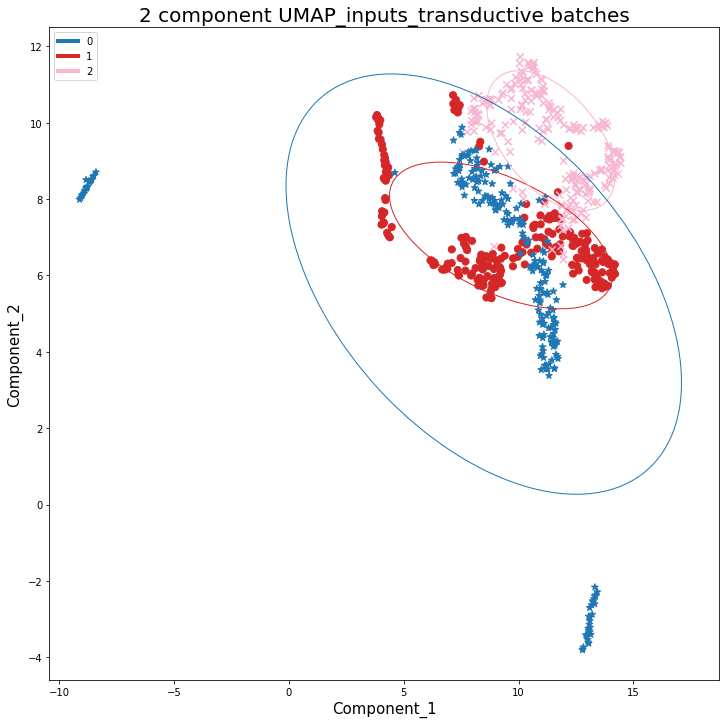

labels


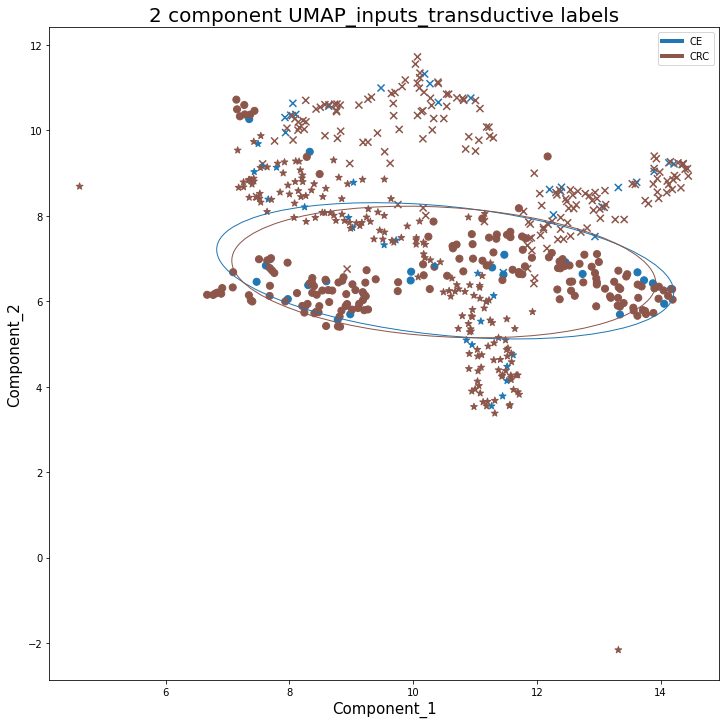

Iteration: 1
-1
valid_score: 0.04503811230593638 h_params: {'tol': 0.9744044165384433, 'max_iter': 933, 'penalty': 'l2', 'C': 9990.405154200935, 'class_weight': 'balanced'}
results/amide/pycombat/linsvc/0
Iteration: 2
[0.09452759426920385, -0.038778336716474064, 0.07936507936507936]
valid_score: 0.04464490432300371 h_params: {'tol': 0.0038576507737700483, 'max_iter': 389, 'penalty': 'l2', 'C': 9355.39077252125, 'class_weight': 'balanced'}
Iteration: 3
[0.09452759426920385, -0.038778336716474064, 0.07936507936507936]
valid_score: 0.10434966217185754 h_params: {'tol': 0.0017909937393907646, 'max_iter': 525, 'penalty': 'l2', 'C': 2295.7729077210424, 'class_weight': 'balanced'}
results/amide/pycombat/linsvc/0
Iteration: 4
[0.055131784641997125, 0.17855212250849614, 0.07936507936507936]
valid_score: 0.04483228800235883 h_params: {'tol': 0.4527391991788818, 'max_iter': 458, 'penalty': 'l2', 'C': 9391.27795510847, 'class_weight': 'balanced'}
Iteration: 5
[0.055131784641997125, 0.1785521225084

In [47]:
%matplotlib inline
metrics = log_fct(copy.deepcopy(data), unique_labels, 'pycombat', metrics)
log_ord(copy.deepcopy(data), unique_labels, unique_batches)
train_fct(copy.deepcopy(data), n_meta, train_models, 'pycombat')


# Harmony

In [48]:
path = 'data'
data, _, _ = get_amide(path, args)
unique_labels = get_unique_labels(data['labels']['all'])
unique_batches = np.unique(data['batches']['all'])
unique_cats = np.unique(data['cats']['all'])
n_cats = len(unique_labels)
n_batches = len(unique_batches)
data = remove_batch_effect(get_berm('harmony'), data)


Imputing zeros.


R[write to console]: Transposing data matrix

R[write to console]: Hard k-means centroids initialization
R[write to console]: 

R[write to console]: Harmony 1/10

R[write to console]: 0%   10   20   30   40   50   60   70   80   90   100%

R[write to console]: [----|----|----|----|----|----|----|----|----|----|

R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]

train 0
valid 192
test 376
train_pool 568
valid_pool 593
test_pool 618


Mann      pval min    n pvals < 0.05
------  -  -
CE_CRC  0  1
------  -  -
ttests
------  --------  -
CE_CRC  0.998512  0
------  --------  -
batches


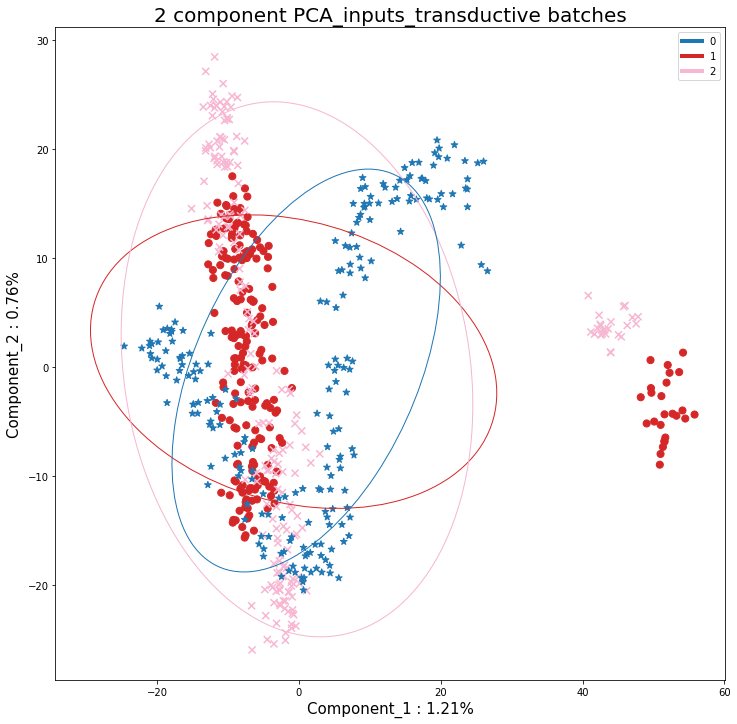

labels


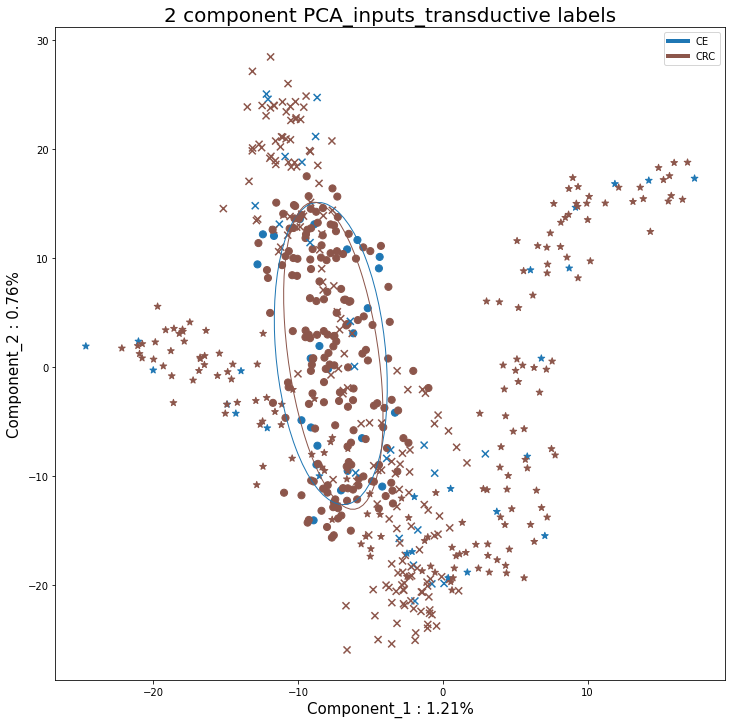

batches


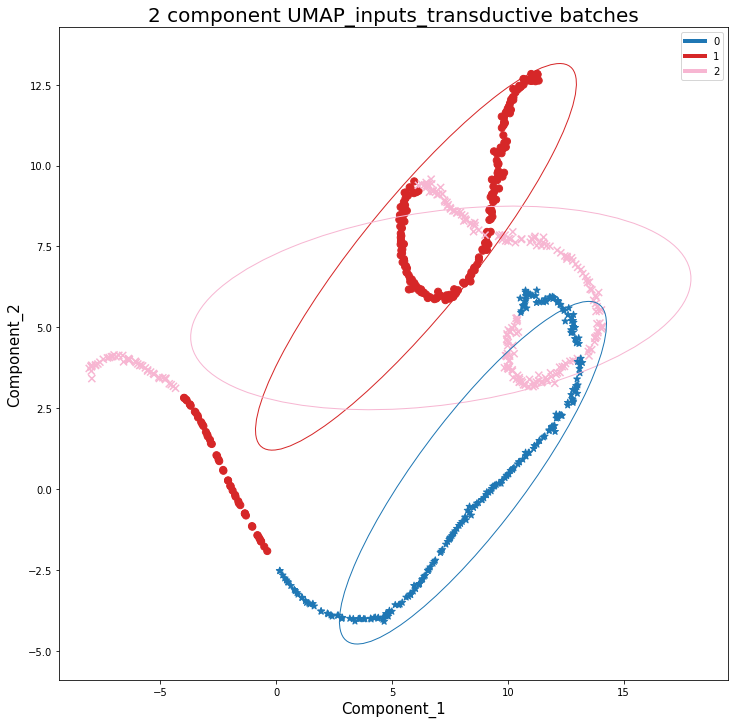

labels


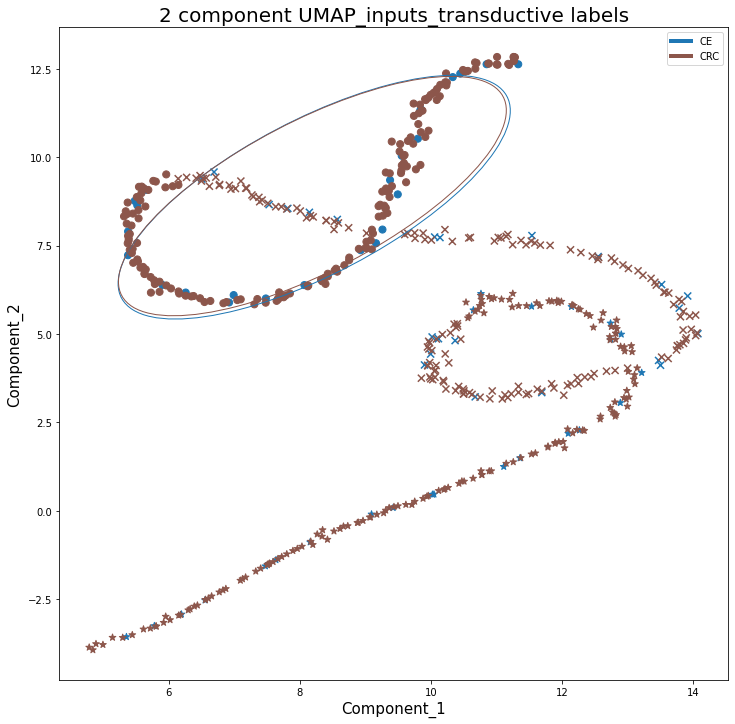

Iteration: 1
-1
valid_score: 0.0 h_params: {'tol': 0.9744044165384433, 'max_iter': 933, 'penalty': 'l2', 'C': 9990.405154200935, 'class_weight': 'balanced'}
results/amide/harmony/linsvc/0
Iteration: 2
[0.0, 0.0, 0.0]
valid_score: 0.0 h_params: {'tol': 0.0038576507737700483, 'max_iter': 389, 'penalty': 'l2', 'C': 9355.39077252125, 'class_weight': 'balanced'}
Iteration: 3
[0.0, 0.0, 0.0]
valid_score: 0.0 h_params: {'tol': 0.0017909937393907646, 'max_iter': 525, 'penalty': 'l2', 'C': 2295.7729077210424, 'class_weight': 'balanced'}
Iteration: 4
[0.0, 0.0, 0.0]
valid_score: 0.0 h_params: {'tol': 0.4527391991788818, 'max_iter': 458, 'penalty': 'l2', 'C': 9391.27795510847, 'class_weight': 'balanced'}
Iteration: 5
[0.0, 0.0, 0.0]
valid_score: 0.0 h_params: {'tol': 0.07309405637964052, 'max_iter': 803, 'penalty': 'l2', 'C': 5181.525971266342, 'class_weight': 'balanced'}
Iteration: 6
[0.0, 0.0, 0.0]
valid_score: 0.0 h_params: {'tol': 0.20729442842862017, 'max_iter': 830, 'penalty': 'l2', 'C': 59

In [49]:
%matplotlib inline
metrics = log_fct(copy.deepcopy(data), unique_labels, 'harmony', metrics)
log_ord(copy.deepcopy(data), unique_labels, unique_batches)
train_fct(copy.deepcopy(data), n_meta, train_models, 'harmony')


# WaveICA

In [50]:
import pandas as pd
import rpy2.robjects as robjects
from rpy2.robjects import pandas2ri
from rpy2.robjects.packages import importr
from rpy2.robjects.conversion import localconverter

def waveicaR(data, batches):
    with localconverter(robjects.default_converter + pandas2ri.converter):
        data_r = robjects.conversion.py2rpy(data)

    # data_r = robjects.r.matrix(robjects.FloatVector(df.values.reshape(-1)), nrow=df.shape[0])
    batches_r = robjects.IntVector(batches.reshape(-1))
    waveica = importr('WaveICA')
    # data_r.colnames = robjects.StrVector([str(x) for x in range(df.shape[1])])
    newdata = waveica.WaveICA(dat=data_r, batch=batches_r)
    with localconverter(robjects.default_converter + pandas2ri.converter):
        newdata = { key : np.array(robjects.conversion.rpy2py(newdata.rx2(key))) for key in newdata.names }
    return newdata['data_wave']


path = 'data'
data, _, _ = get_amide(path, args)
unique_labels = get_unique_labels(data['labels']['all'])
unique_batches = np.unique(data['batches']['all'])
unique_cats = np.unique(data['cats']['all'])
n_cats = len(unique_labels)
n_batches = len(unique_batches)
data = remove_batch_effect(waveicaR, data)


Imputing zeros.


R[write to console]: 
waveslim: Wavelet Method for 1/2/3D Signals (version = 1.8.4)




######Decomposition 1 ########
######Decomposition 2 ########
######Decomposition 3 ########
######Decomposition 4 ########
######Decomposition 5 ########
######Decomposition 6 ########
######Decomposition 7 ########
######Decomposition 8 ########
######Decomposition 9 ########
######Decomposition 10 ########
######Decomposition 11 ########
######Decomposition 12 ########
######Decomposition 13 ########
######Decomposition 14 ########
######Decomposition 15 ########
######Decomposition 16 ########
######Decomposition 17 ########
######Decomposition 18 ########
######Decomposition 19 ########
######Decomposition 20 ########
######Decomposition 21 ########
######Decomposition 22 ########
######Decomposition 23 ########
######Decomposition 24 ########
######Decomposition 25 ########
######Decomposition 26 ########
######Decomposition 27 ########
######Decomposition 28 ########
######Decomposition 29 ########
######Decomposition 30 ########
######Decomposition 31 ########
######Decompositi

Mann      pval min    n pvals < 0.05


------  -  -
CE_CRC  0  1
------  -  -
ttests
------  -----------  ---
CE_CRC  9.37539e-08  527
------  -----------  ---
batches


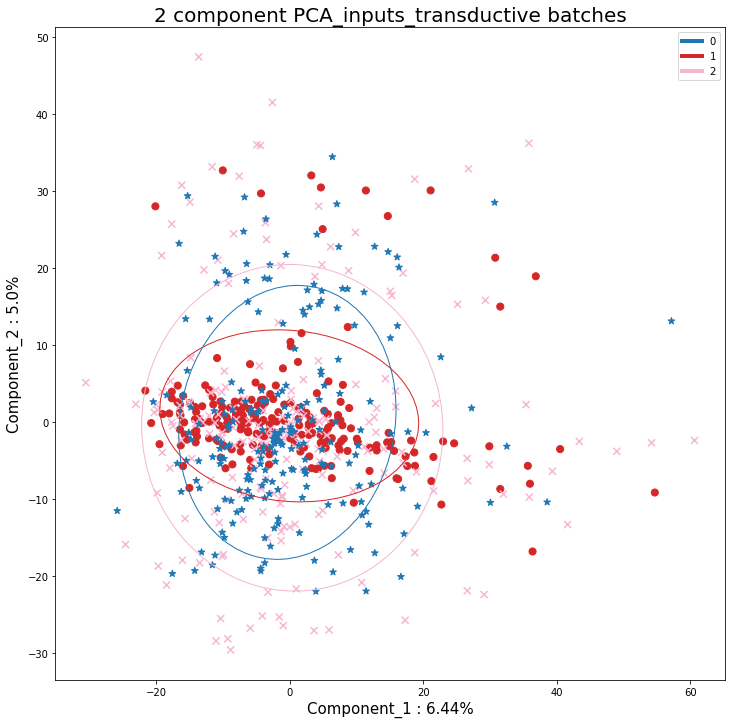

labels


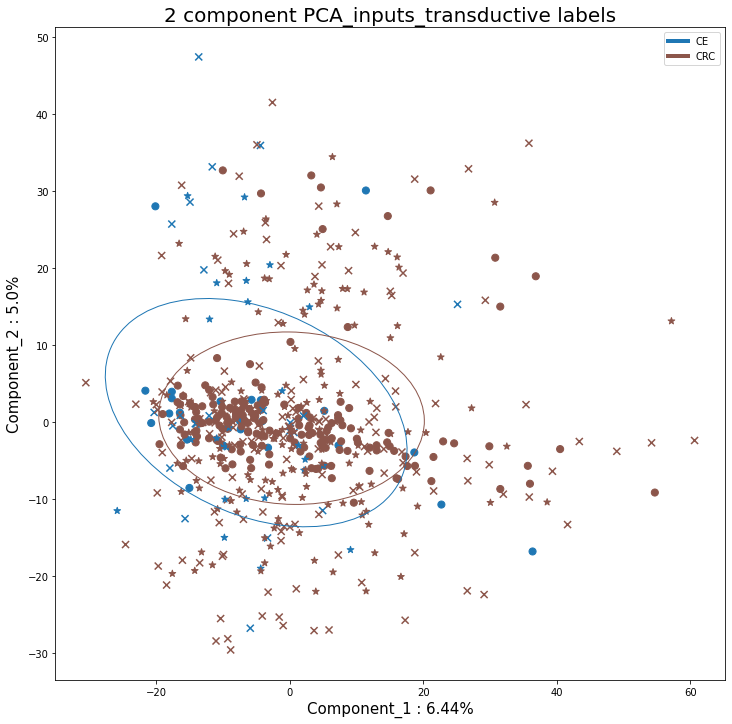

batches


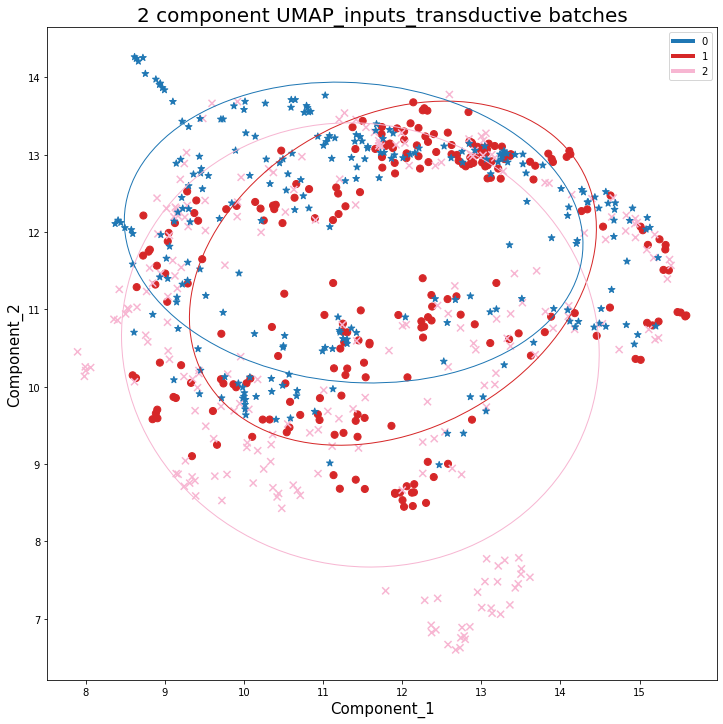

labels


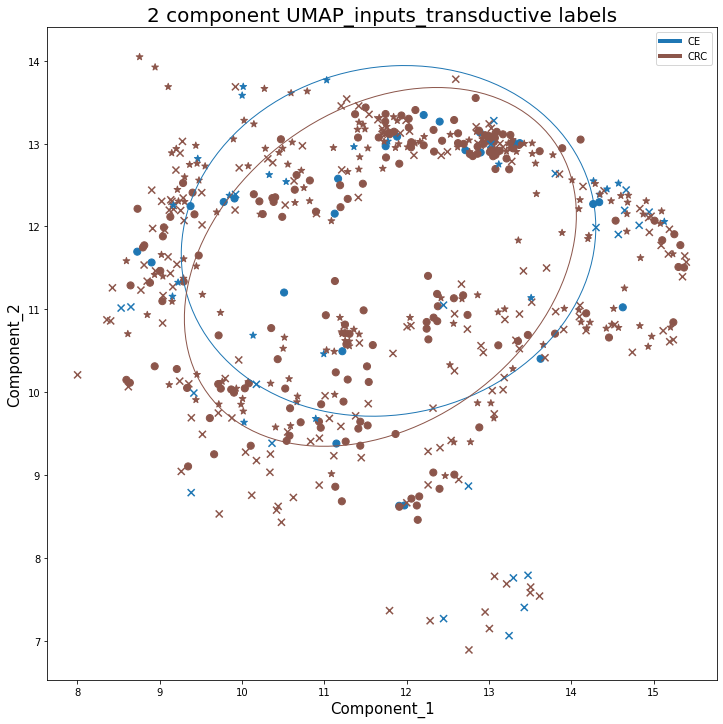

Iteration: 1
-1
valid_score: -0.015371216950689473 h_params: {'tol': 0.9744044165384433, 'max_iter': 933, 'penalty': 'l2', 'C': 9990.405154200935, 'class_weight': 'balanced'}
results/amide/waveica/linsvc/0
Iteration: 2
[-0.007335314135594359, -0.038778336716474064, 0.0]
valid_score: -0.009116183145740324 h_params: {'tol': 0.0038576507737700483, 'max_iter': 389, 'penalty': 'l2', 'C': 9355.39077252125, 'class_weight': 'balanced'}
results/amide/waveica/linsvc/0
Iteration: 3
[0.0, -0.027348549437220974, 0.0]
valid_score: -0.009116183145740324 h_params: {'tol': 0.0017909937393907646, 'max_iter': 525, 'penalty': 'l2', 'C': 2295.7729077210424, 'class_weight': 'balanced'}
Iteration: 4
[0.0, -0.027348549437220974, 0.0]
valid_score: -0.012926112238824687 h_params: {'tol': 0.4527391991788818, 'max_iter': 458, 'penalty': 'l2', 'C': 9391.27795510847, 'class_weight': 'balanced'}
Iteration: 5
[0.0, -0.027348549437220974, 0.0]
valid_score: 0.02585222447764937 h_params: {'tol': 0.07309405637964052, 'ma

In [51]:
%matplotlib inline
metrics = log_fct(copy.deepcopy(data), unique_labels, 'waveica', metrics)
log_ord(copy.deepcopy(data), unique_labels, unique_batches)
train_fct(copy.deepcopy(data), n_meta, train_models, 'waveica')


In [52]:
if log_stuff:
    # table = pd.DataFrame(columns=list(metrics['raw']['all'].keys()) + ['delta', 'delta_pool'], index=list(metrics.keys()))
    cols = ['qc_aPCC', '[qc_dist/tot_eucl]', 'lisi', 'silhouette', 'kbet', 'shannon', 'adjusted_rand_score', 'adjusted_mutual_info_score']
    cols_pool = ['pool lisi', 'pool silhouette', 'pool kbet', 'pool shannon', 'pool adjusted_rand_score', 'pool adjusted_mutual_info_score',]
    table = pd.DataFrame(columns=cols + cols_pool, index=list(metrics.keys()))
    # table = table.drop(['qc_dist', 'b_euclidean', 'euclidean', "[b_euclidean/tot_eucl]"], 1)
    for col in cols:
        for row in list(table.index):
            # if 'delta' in col:
            #     table[col][row] = metrics[row][col]
            # else:
            try:
                if isinstance(metrics[row]['all'][col], dict):
                    table[col][row] = metrics[row]['all'][col]["domains"]
                    try:
                        table[f'pool {col}'][row] = metrics[row]['all_pool'][col]["domains"]
                    except:
                        pass
                    # table[col][row]["domains"] = metrics[row]['all'][col]["domains"]
                    # table[col][row]["labels"] = metrics[row]['all'][col]["labels"]
                else:
                    try:
                        table[col][row] = metrics[row]['valid'][col]
                    except:
                        table[col][row] = metrics[row]['all'][col]

            except:
                try:
                    table[col][row] = metrics[row]['all_pool'][col]
                except:
                    table[col][row] = metrics[row]['valid'][col]

table

qc_aPCC [qc_dist/tot_eucl]      lisi silhouette  \
raw                 0.815415           0.838954  1.825332   0.232852   
minmax              0.480164           0.902304  2.131924   0.244783   
minmax_per_batch    0.325926           0.967037  2.384002    0.16348   
standard             0.18279           0.913505  1.904793   0.202406   
standard_per_batch  0.239696           0.961342  2.190061  -0.000819   
robust              0.310263           0.881791   2.12807   0.152401   
robust_per_batch    0.360971           1.035938  2.223215   0.005672   
combat              0.008655           1.181689  1.021349  -0.010799   
pycombat            0.887624           0.795018  1.822181  -0.004228   
harmony             0.178618           0.995316  2.442804  -0.001713   
waveica             0.980997           0.678352  1.854283  -0.024325   

                        kbet   shannon adjusted_rand_score  \
raw                      0.0      -0.0                 1.0   
minmax                   0.0      -0.0                 1.0   
minmax_per_batch         0.0      -0.0                 1.0   
standard                 0.0      -0.0                 1.0   
standard_per_batch       0.0  0.202112            0.958372   
robust              0.000004  0.009617                 1.0   
robust_per_batch    0.004641  0.335144            0.844217   
combat                   0.0  0.825778            0.008524   
pycombat                 0.0  0.280736            0.916851   
harmony             0.471068  0.115804            0.994752   
waveica                  0.0  0.670437            0.145158   

                   adjusted_mutual_info_score pool lisi pool silhouette  \
raw                                       1.0       NaN             NaN   
minmax                                    1.0       NaN             NaN   
minmax_per_batch                          1.0       NaN             NaN   
standard                                  1.0       NaN             NaN   
standard_per_batch                   0.929593       NaN             NaN   
robust                                    1.0       NaN             NaN   
robust_per_batch                     0.805306       NaN             NaN   
combat                               0.021677       NaN             NaN   
pycombat                              0.87915       NaN             NaN   
harmony                              0.989972       NaN             NaN   
waveica                              0.213696       NaN             NaN   

                   pool kbet pool shannon pool adjusted_rand_score  \
raw                      NaN          NaN                      NaN   
minmax                   NaN          NaN                      NaN   
minmax_per_batch         NaN          NaN                      NaN   
standard                 NaN          NaN                      NaN   
standard_per_batch       NaN          NaN                      NaN   
robust                   NaN          NaN                      NaN   
robust_per_batch         NaN          NaN                      NaN   
combat                   NaN          NaN                      NaN   
pycombat                 NaN          NaN                      NaN   
harmony                  NaN          NaN                      NaN   
waveica                  NaN          NaN                      NaN   

                   pool adjusted_mutual_info_score  
raw                                            NaN  
minmax                                         NaN  
minmax_per_batch                               NaN  
standard                                       NaN  
standard_per_batch                             NaN  
robust                                         NaN  
robust_per_batch                               NaN  
combat                                         NaN  
pycombat                                       NaN  
harmony                                        NaN  
waveica                                        NaN

# NORMAE

In [53]:
from src.dl.models.pytorch.aedann import AutoEncoder2 as AutoEncoder


## Encoded

In [54]:
path = 'data'
data, _, _ = get_amide(path, args)
unique_labels = get_unique_labels(data['labels']['all'])
unique_batches = np.unique(data['batches']['all'])
unique_cats = np.unique(data['cats']['all'])
n_cats = len(unique_labels)
n_batches = len(unique_batches)

data, _ = scale_data('robust', data, device='cpu')

if not best_correction:
    # Best score run Brain-1446
    path='logs/best_models/ae_classifier_holdout/adenocarcinoma/normae_vae0/model_1.pth'
else:
    # Run Brain-
    path='logs/ae_classifier_holdout/.../model_3.pth'
    
# best score is autoencoder0, best correction autoencoder3
best_ae2 = AutoEncoder(data['inputs']['all'].shape[1],
                    n_batches=3,
                    nb_classes=2,
                    layer1=663,
                    mapper=0,
                    layer2=464,
                    dropout=0,
                    n_meta=0,
                    n_emb=2,
                    n_layers=1,
                    variational=0, conditional=False, zinb=0,
                    add_noise=0, tied_weights=0, 
                    use_gnn=0, device='cpu').to('cpu')

best_ae2.mapper.to('cpu')
best_ae2.dec.to('cpu')

best_ae2.load_state_dict(torch.load(f'{path}'))
best_ae2.eval()
pass

Imputing zeros.


In [55]:
batches = torch.Tensor([np.argwhere(unique_batches == x)[0][0] for x in data['batches']['all']]).detach().cpu()
enc_data = data.copy()
enc_data['inputs']['all'], _, _, _ = best_ae2.cpu()(torch.Tensor(data['inputs']['all'].values), batches, sampling=True, mapping=False)
enc_data['inputs']['all_pool'], _, _, _ = best_ae2.cpu()(torch.Tensor(data['inputs']['all_pool'].values), batches, sampling=False, mapping=False)
enc_data['inputs']['train'], _, _, _ = best_ae2.cpu()(torch.Tensor(data['inputs']['train'].values), batches, sampling=True, mapping=False)
enc_data['inputs']['train_pool'], _, _, _ = best_ae2.cpu()(torch.Tensor(data['inputs']['train_pool'].values), batches, sampling=False, mapping=False)
enc_data['inputs']['valid'], _, _, _ = best_ae2.cpu()(torch.Tensor(data['inputs']['valid'].values), batches, sampling=True, mapping=False)
enc_data['inputs']['valid_pool'], _, _, _ = best_ae2.cpu()(torch.Tensor(data['inputs']['valid_pool'].values), batches, sampling=False, mapping=False)
enc_data['inputs']['test'], _, _, _ = best_ae2.cpu()(torch.Tensor(data['inputs']['test'].values), batches, sampling=True, mapping=False)
enc_data['inputs']['test_pool'], _, _, _ = best_ae2.cpu()(torch.Tensor(data['inputs']['test_pool'].values), batches, sampling=False, mapping=False)

for group in enc_data['inputs']:
    enc_data['inputs'][group] = pd.DataFrame(enc_data['inputs'][group].detach().cpu().numpy())


Mann      pval min    n pvals < 0.05
------  -  -
CE_CRC  0  1
------  -  -
ttests
------  -----------  ---
CE_CRC  3.25584e-09  184
------  -----------  ---
batches


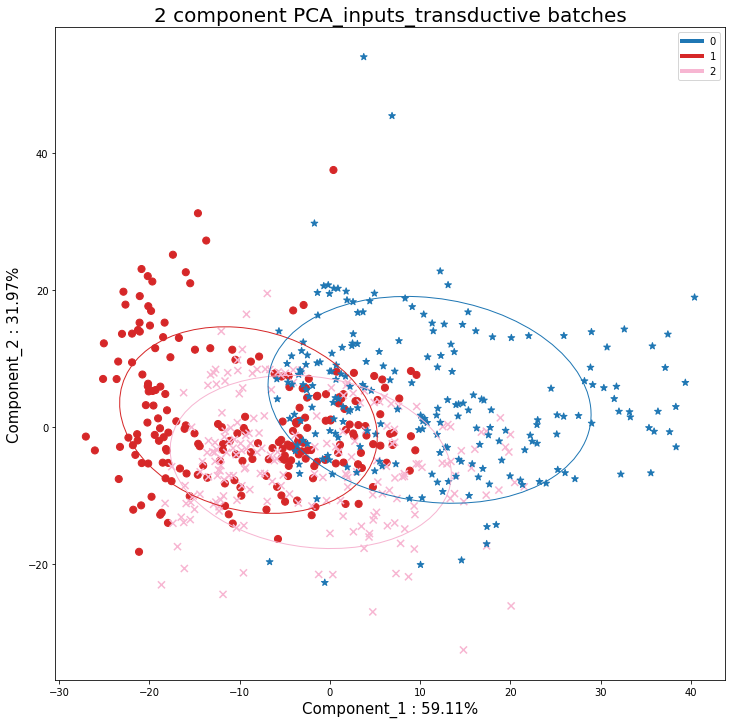

labels


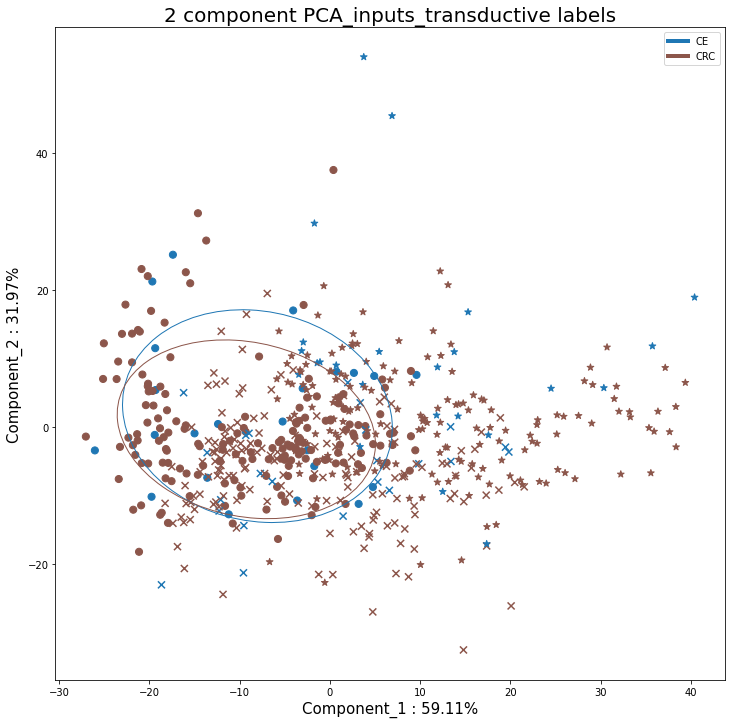

batches


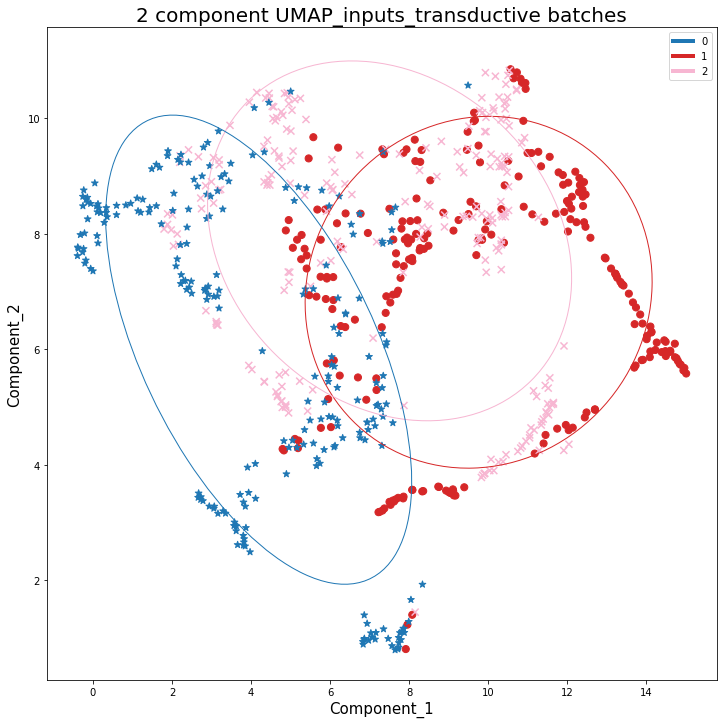

labels


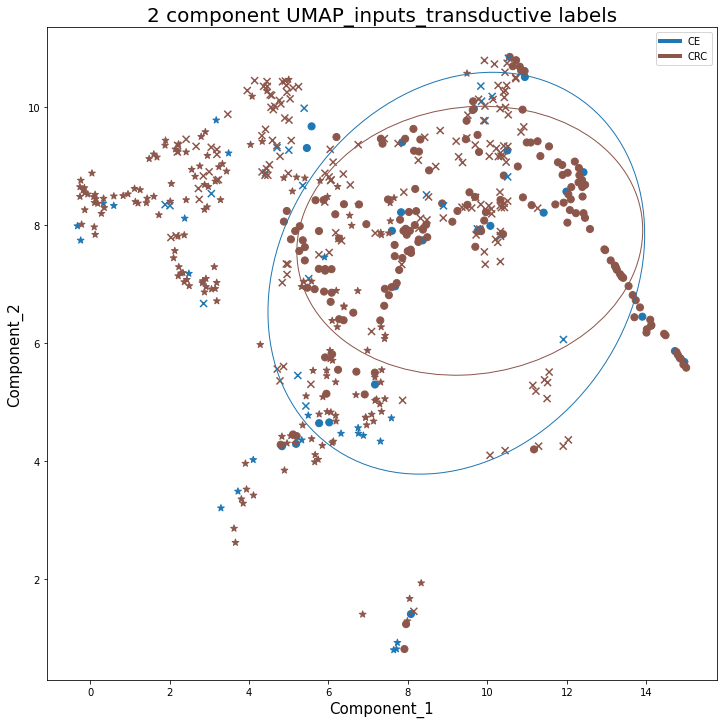

In [56]:
%matplotlib inline
metrics = log_fct(copy.deepcopy(data), unique_labels, 'ae', metrics)
log_ord(copy.deepcopy(data), unique_labels, unique_batches)
# train_fct(copy.deepcopy(data), n_meta, train_models, 'harmony')


In [57]:
if log_stuff:
    # table = pd.DataFrame(columns=list(metrics['raw']['all'].keys()) + ['delta', 'delta_pool'], index=list(metrics.keys()))
    cols = ['qc_aPCC', '[qc_dist/tot_eucl]', 'lisi', 'silhouette', 'kbet', 'shannon', 'adjusted_rand_score', 'adjusted_mutual_info_score']
    cols_pool = ['pool lisi', 'pool silhouette', 'pool kbet', 'pool shannon', 'pool adjusted_rand_score', 'pool adjusted_mutual_info_score',]
    table = pd.DataFrame(columns=cols + cols_pool, index=list(metrics.keys()))
    # table = table.drop(['qc_dist', 'b_euclidean', 'euclidean', "[b_euclidean/tot_eucl]"], 1)
    for col in cols:
        for row in list(table.index):
            # if 'delta' in col:
            #     table[col][row] = metrics[row][col]
            # else:
            try:
                if isinstance(metrics[row]['all'][col], dict):
                    table[col][row] = metrics[row]['all'][col]["domains"]
                    try:
                        table[f'pool {col}'][row] = metrics[row]['all_pool'][col]["domains"]
                    except:
                        pass
                    # table[col][row]["domains"] = metrics[row]['all'][col]["domains"]
                    # table[col][row]["labels"] = metrics[row]['all'][col]["labels"]
                else:
                    try:
                        table[col][row] = metrics[row]['valid'][col]
                    except:
                        table[col][row] = metrics[row]['all'][col]

            except:
                try:
                    table[col][row] = metrics[row]['all_pool'][col]
                except:
                    table[col][row] = metrics[row]['valid'][col]

table

qc_aPCC [qc_dist/tot_eucl]      lisi silhouette  \
raw                 0.815415           0.838954  1.825332   0.232852   
minmax              0.480164           0.902304  2.131924   0.244783   
minmax_per_batch    0.325926           0.967037  2.384002    0.16348   
standard             0.18279           0.913505  1.904793   0.202406   
standard_per_batch  0.239696           0.961342  2.190061  -0.000819   
robust              0.310263           0.881791   2.12807   0.152401   
robust_per_batch    0.360971           1.035938  2.223215   0.005672   
combat              0.008655           1.181689  1.021349  -0.010799   
pycombat            0.887624           0.795018  1.822181  -0.004228   
harmony             0.178618           0.995316  2.442804  -0.001713   
waveica             0.980997           0.678352  1.854283  -0.024325   
ae                  0.396323           0.839343  2.218976   0.052063   

                        kbet   shannon adjusted_rand_score  \
raw                      0.0      -0.0                 1.0   
minmax                   0.0      -0.0                 1.0   
minmax_per_batch         0.0      -0.0                 1.0   
standard                 0.0      -0.0                 1.0   
standard_per_batch       0.0  0.202112            0.958372   
robust              0.000004  0.009617                 1.0   
robust_per_batch    0.004641  0.335144            0.844217   
combat                   0.0  0.825778            0.008524   
pycombat                 0.0  0.280736            0.916851   
harmony             0.471068  0.115804            0.994752   
waveica                  0.0  0.670437            0.145158   
ae                  0.706534   0.43489            0.650547   

                   adjusted_mutual_info_score pool lisi pool silhouette  \
raw                                       1.0       NaN             NaN   
minmax                                    1.0       NaN             NaN   
minmax_per_batch                          1.0       NaN             NaN   
standard                                  1.0       NaN             NaN   
standard_per_batch                   0.929593       NaN             NaN   
robust                                    1.0       NaN             NaN   
robust_per_batch                     0.805306       NaN             NaN   
combat                               0.021677       NaN             NaN   
pycombat                              0.87915       NaN             NaN   
harmony                              0.989972       NaN             NaN   
waveica                              0.213696       NaN             NaN   
ae                                   0.574247       NaN             NaN   

                   pool kbet pool shannon pool adjusted_rand_score  \
raw                      NaN          NaN                      NaN   
minmax                   NaN          NaN                      NaN   
minmax_per_batch         NaN          NaN                      NaN   
standard                 NaN          NaN                      NaN   
standard_per_batch       NaN          NaN                      NaN   
robust                   NaN          NaN                      NaN   
robust_per_batch         NaN          NaN                      NaN   
combat                   NaN          NaN                      NaN   
pycombat                 NaN          NaN                      NaN   
harmony                  NaN          NaN                      NaN   
waveica                  NaN          NaN                      NaN   
ae                       NaN          NaN                      NaN   

                   pool adjusted_mutual_info_score  
raw                                            NaN  
minmax                                         NaN  
minmax_per_batch                               NaN  
standard                                       NaN  
standard_per_batch                             NaN  
robust                                         NaN  
robust_per_batch   

# AE 

## Encoded

In [58]:
path = 'data'
data, _, _ = get_amide(path, args)
unique_labels = get_unique_labels(data['labels']['all'])
unique_batches = np.unique(data['batches']['all'])
unique_cats = np.unique(data['cats']['all'])
n_cats = len(unique_labels)
n_batches = len(unique_batches)

data, _ = scale_data('robust', data, device='cpu')

if not best_correction:
    # Best score run Brain-1446
    path='logs/best_models/ae_then_classifier_holdout/adenocarcinoma/no_vae0/model_1.pth'
else:
    # Run Brain-
    path='logs/ae_classifier_holdout/.../model_3.pth'

scaler = Pipeline([('standard', RobustScaler()), ('minmax', MinMaxScaler())])
# scaler = Pipeline([('standard', StandardScaler()), ('minmax', MinMaxScaler())])
# scaler = MinMaxScaler()

data['inputs']['all'] = scaler.fit_transform(data['inputs']['all'])
data['inputs']['all_pool'] = scaler.transform(data['inputs']['all_pool'])
data['inputs']['train'] = scaler.transform(data['inputs']['train'])
data['inputs']['train_pool'] = scaler.transform(data['inputs']['train_pool'])
data['inputs']['valid'] = scaler.transform(data['inputs']['valid'])
data['inputs']['valid_pool'] = scaler.transform(data['inputs']['valid_pool'])
data['inputs']['test'] = scaler.transform(data['inputs']['test'])
data['inputs']['test_pool'] = scaler.transform(data['inputs']['test_pool'])


Imputing zeros.


In [59]:
print(data['inputs']['all'].shape)
# best score is autoencoder0, best correction autoencoder3
if not best_correction:
    best_ae2 = AutoEncoder0(data['inputs']['all'].shape[1],
                     n_batches=22,
                     nb_classes=2,
                     layer1=63,
                     mapper=0,
                     layer2=893,
                     dropout=0,
                     variational=0, conditional=False, zinb=0,
                     add_noise=0, tied_weights=0, n_meta=2,
                     use_gnn=0, device='cuda').to('cuda')
else:
    best_ae2 = AutoEncoder(data['inputs']['all'].shape[1],
                 n_batches=21,
                 nb_classes=2,
                 layer1=595,
                 mapper=0,
                 layer2=266,
                 dropout=0,
                 variational=0, conditional=False, zinb=0,
                 add_noise=0, tied_weights=0, n_meta=2,
                 use_gnn=0, device='cuda').to('cuda')

best_ae2.mapper.to('cuda')
best_ae2.dec.to('cuda')

best_ae2.load_state_dict(torch.load(f'{path}'))
best_ae2.eval()
pass

(568, 6461)


NameError: name 'AutoEncoder0' is not defined

In [ ]:
batches = torch.Tensor([np.argwhere(unique_batches == x)[0][0] for x in data['batches']['all']])
enc_data = data.copy()
enc_data['inputs']['all'], _, _, _ = best_ae2.cpu()(torch.Tensor(data['inputs']['all']), batches, sampling=True)
enc_data['inputs']['all_pool'], _, _, _ = best_ae2.cpu()(torch.Tensor(data['inputs']['all_pool']), batches, sampling=False)
enc_data['inputs']['train'], _, _, _ = best_ae2.cpu()(torch.Tensor(data['inputs']['train']), batches, sampling=True)
enc_data['inputs']['train_pool'], _, _, _ = best_ae2.cpu()(torch.Tensor(data['inputs']['train_pool']), batches, sampling=False)
enc_data['inputs']['valid'], _, _, _ = best_ae2.cpu()(torch.Tensor(data['inputs']['valid']), batches, sampling=True)
enc_data['inputs']['valid_pool'], _, _, _ = best_ae2.cpu()(torch.Tensor(data['inputs']['valid_pool']), batches, sampling=False)
enc_data['inputs']['test'], _, _, _ = best_ae2.cpu()(torch.Tensor(data['inputs']['test']), batches, sampling=True)
enc_data['inputs']['test_pool'], _, _, _ = best_ae2.cpu()(torch.Tensor(data['inputs']['test_pool']), batches, sampling=False)

for group in enc_data['inputs']:
    enc_data['inputs'][group] = enc_data['inputs'][group].detach().cpu().numpy()
    if n_meta == 2:
        enc_data['inputs'][group] = np.concatenate((enc_data['inputs'][group], enc_data['meta'][group]), 1)


# VAE

## Encoded

In [ ]:
from src.dl.models.pytorch.aedann import AutoEncoder2 as AutoEncoder

In [ ]:
path = 'data'
data, _, _ = get_amide(path, args)
unique_labels = get_unique_labels(data['labels']['all'])
unique_batches = np.unique(data['batches']['all'])
unique_cats = np.unique(data['cats']['all'])
n_cats = len(unique_labels)
n_batches = len(unique_batches)

data, _ = scale_data('robust', data, device='cpu')

# Best score run Brain-1446
path='logs/best_models/ae_classifier_holdout/adenocarcinoma/no_vae1/model_1.pth'

# best score is autoencoder0, best correction autoencoder3
best_ae2 = AutoEncoder(data['inputs']['all'].shape[1],
                    n_batches=3,
                    nb_classes=2,
                    layer1=663,
                    mapper=0,
                    layer2=464,
                    dropout=0,
                    n_meta=0,
                    n_emb=2,
                    n_layers=1,
                    variational=0, conditional=False, zinb=0,
                    add_noise=0, tied_weights=0, 
                    use_gnn=0, device='cpu').to('cpu')

best_ae2.mapper.to('cpu')
best_ae2.dec.to('cpu')

best_ae2.load_state_dict(torch.load(f'{path}'))
best_ae2.eval()
pass

In [ ]:
batches = torch.Tensor([np.argwhere(unique_batches == x)[0][0] for x in data['batches']['all']])
enc_data = data.copy()
enc_data['inputs']['all'], _, _, _ = best_ae2.cpu()(torch.Tensor(data['inputs']['all']), batches, sampling=False)
enc_data['inputs']['all_pool'], _, _, _ = best_ae2.cpu()(torch.Tensor(data['inputs']['all_pool']), batches, sampling=False)
enc_data['inputs']['train'], _, _, _ = best_ae2.cpu()(torch.Tensor(data['inputs']['train']), batches, sampling=False)
enc_data['inputs']['train_pool'], _, _, _ = best_ae2.cpu()(torch.Tensor(data['inputs']['train_pool']), batches, sampling=False)
enc_data['inputs']['valid'], _, _, _ = best_ae2.cpu()(torch.Tensor(data['inputs']['valid']), batches, sampling=False)
enc_data['inputs']['valid_pool'], _, _, _ = best_ae2.cpu()(torch.Tensor(data['inputs']['valid_pool']), batches, sampling=False)
enc_data['inputs']['test'], _, _, _ = best_ae2.cpu()(torch.Tensor(data['inputs']['test']), batches, sampling=False)
enc_data['inputs']['test_pool'], _, _, _ = best_ae2.cpu()(torch.Tensor(data['inputs']['test_pool']), batches, sampling=False)

for group in enc_data['inputs']:
    enc_data['inputs'][group] = enc_data['inputs'][group].detach().cpu().numpy()
    if n_meta == 2:
        enc_data['inputs'][group] = np.concatenate((enc_data['inputs'][group], enc_data['meta'][group]), 1)


In [ ]:
%matplotlib inline
metrics = log_fct(copy.deepcopy(data), unique_labels, 'vae', metrics)
log_ord(copy.deepcopy(data), unique_labels, unique_batches)
# train_fct(copy.deepcopy(data), n_meta, train_models, 'harmony')


# AE-revTriplet

In [ ]:
path = 'data'
data, _, _ = get_amide(path, args)
unique_labels = get_unique_labels(data['labels']['all'])
unique_batches = np.unique(data['batches']['all'])
unique_cats = np.unique(data['cats']['all'])
n_cats = len(unique_labels)
n_batches = len(unique_batches)

data, _ = scale_data('robust', data, device='cpu')

path='logs/best_models/ae_classifier_holdout/adenocarcinoma/revTriplet_vae0/model_1.pth'

# best score is autoencoder0, best correction autoencoder3
best_ae2 = AutoEncoder(data['inputs']['all'].shape[1],
                    n_batches=3,
                    nb_classes=2,
                    layer1=663,
                    mapper=0,
                    layer2=464,
                    dropout=0,
                    n_meta=0,
                    n_emb=2,
                    n_layers=1,
                    variational=0, conditional=False, zinb=0,
                    add_noise=0, tied_weights=0, 
                    use_gnn=0, device='cpu').to('cpu')

best_ae2.mapper.to('cpu')
best_ae2.dec.to('cpu')

best_ae2.load_state_dict(torch.load(f'{path}'))
best_ae2.eval()
pass

In [ ]:
batches = torch.Tensor([np.argwhere(unique_batches == x)[0][0] for x in data['batches']['all']])
enc_data = data.copy()
enc_data['inputs']['all'], _, _, _ = best_ae2.cpu()(torch.Tensor(data['inputs']['all']), batches, sampling=False)
enc_data['inputs']['all_pool'], _, _, _ = best_ae2.cpu()(torch.Tensor(data['inputs']['all_pool']), batches, sampling=False)
enc_data['inputs']['train'], _, _, _ = best_ae2.cpu()(torch.Tensor(data['inputs']['train']), batches, sampling=False)
enc_data['inputs']['train_pool'], _, _, _ = best_ae2.cpu()(torch.Tensor(data['inputs']['train_pool']), batches, sampling=False)
enc_data['inputs']['valid'], _, _, _ = best_ae2.cpu()(torch.Tensor(data['inputs']['valid']), batches, sampling=False)
enc_data['inputs']['valid_pool'], _, _, _ = best_ae2.cpu()(torch.Tensor(data['inputs']['valid_pool']), batches, sampling=False)
enc_data['inputs']['test'], _, _, _ = best_ae2.cpu()(torch.Tensor(data['inputs']['test']), batches, sampling=False)
enc_data['inputs']['test_pool'], _, _, _ = best_ae2.cpu()(torch.Tensor(data['inputs']['test_pool']), batches, sampling=False)

for group in enc_data['inputs']:
    enc_data['inputs'][group] = enc_data['inputs'][group].detach().cpu().numpy()
    if n_meta == 2:
        enc_data['inputs'][group] = np.concatenate((enc_data['inputs'][group], enc_data['meta'][group]), 1)


In [ ]:
%matplotlib inline
metrics = log_fct(copy.deepcopy(data), unique_labels, 'ae_revTriplet', metrics)
log_ord(copy.deepcopy(data), unique_labels, unique_batches)
# train_fct(copy.deepcopy(data), n_meta, train_models, 'harmony')


# VAE-revTriplet

## Encoded

In [ ]:
path = 'data'
data, _, _ = get_amide(path, args)
unique_labels = get_unique_labels(data['labels']['all'])
unique_batches = np.unique(data['batches']['all'])
unique_cats = np.unique(data['cats']['all'])
n_cats = len(unique_labels)
n_batches = len(unique_batches)

data, _ = scale_data('robust', data, device='cpu')

path='logs/best_models/ae_classifier_holdout/adenocarcinoma/revTriplet_vae1/model_1.pth'

# best score is autoencoder0, best correction autoencoder3
best_ae2 = AutoEncoder(data['inputs']['all'].shape[1],
                    n_batches=3,
                    nb_classes=2,
                    layer1=663,
                    mapper=0,
                    layer2=464,
                    dropout=0,
                    n_meta=0,
                    n_emb=2,
                    n_layers=1,
                    variational=0, conditional=False, zinb=0,
                    add_noise=0, tied_weights=0, 
                    use_gnn=0, device='cpu').to('cpu')

best_ae2.mapper.to('cpu')
best_ae2.dec.to('cpu')

best_ae2.load_state_dict(torch.load(f'{path}'))
best_ae2.eval()
pass

In [ ]:
batches = torch.Tensor([np.argwhere(unique_batches == x)[0][0] for x in data['batches']['all']])
enc_data = data.copy()
enc_data['inputs']['all'], _, _, _ = best_ae2.cpu()(torch.Tensor(data['inputs']['all']), batches, sampling=False)
enc_data['inputs']['all_pool'], _, _, _ = best_ae2.cpu()(torch.Tensor(data['inputs']['all_pool']), batches, sampling=False)
enc_data['inputs']['train'], _, _, _ = best_ae2.cpu()(torch.Tensor(data['inputs']['train']), batches, sampling=False)
enc_data['inputs']['train_pool'], _, _, _ = best_ae2.cpu()(torch.Tensor(data['inputs']['train_pool']), batches, sampling=False)
enc_data['inputs']['valid'], _, _, _ = best_ae2.cpu()(torch.Tensor(data['inputs']['valid']), batches, sampling=False)
enc_data['inputs']['valid_pool'], _, _, _ = best_ae2.cpu()(torch.Tensor(data['inputs']['valid_pool']), batches, sampling=False)
enc_data['inputs']['test'], _, _, _ = best_ae2.cpu()(torch.Tensor(data['inputs']['test']), batches, sampling=False)
enc_data['inputs']['test_pool'], _, _, _ = best_ae2.cpu()(torch.Tensor(data['inputs']['test_pool']), batches, sampling=False)

for group in enc_data['inputs']:
    enc_data['inputs'][group] = enc_data['inputs'][group].detach().cpu().numpy()
    if n_meta == 2:
        enc_data['inputs'][group] = np.concatenate((enc_data['inputs'][group], enc_data['meta'][group]), 1)


In [ ]:
%matplotlib inline
metrics = log_fct(copy.deepcopy(data), unique_labels, 'vae-revTriplet', metrics)
log_ord(copy.deepcopy(data), unique_labels, unique_batches)
# train_fct(copy.deepcopy(data), n_meta, train_models, 'harmony')


## Reconstruction

In [ ]:
path = 'data'
data, _, _ = get_amide(path, args)
unique_labels = get_unique_labels(data['labels']['all'])
unique_batches = np.unique(data['batches']['all'])
unique_cats = np.unique(data['cats']['all'])
n_cats = len(unique_labels)
n_batches = len(unique_batches)

data, _ = scale_data('robust', data, device='cpu')

path='logs/best_models/ae_classifier_holdout/adenocarcinoma/revTriplet_vae1/model_1.pth'

# best score is autoencoder0, best correction autoencoder3
best_ae2 = AutoEncoder(data['inputs']['all'].shape[1],
                    n_batches=3,
                    nb_classes=2,
                    layer1=663,
                    mapper=0,
                    layer2=464,
                    dropout=0,
                    n_meta=0,
                    n_emb=2,
                    n_layers=1,
                    variational=0, conditional=False, zinb=0,
                    add_noise=0, tied_weights=0, 
                    use_gnn=0, device='cpu').to('cpu')

best_ae2.mapper.to('cpu')
best_ae2.dec.to('cpu')

best_ae2.load_state_dict(torch.load(f'{path}'))
best_ae2.eval()
pass

In [ ]:
batches = torch.Tensor([np.argwhere(unique_batches == x)[0][0] for x in data['batches']['all']])
rec_data = data.copy()
_, rec_data['inputs']['all'], _, _ = best_ae2.cpu()(torch.Tensor(data['inputs']['all']), batches, sampling=False)
_, rec_data['inputs']['all_pool'], _, _ = best_ae2.cpu()(torch.Tensor(data['inputs']['all_pool']), batches, sampling=False)
_, rec_data['inputs']['train'], _, _ = best_ae2.cpu()(torch.Tensor(data['inputs']['train']), batches, sampling=False)
_, rec_data['inputs']['train_pool'], _, _ = best_ae2.cpu()(torch.Tensor(data['inputs']['train_pool']), batches, sampling=False)
_, rec_data['inputs']['valid'], _, _ = best_ae2.cpu()(torch.Tensor(data['inputs']['valid']), batches, sampling=False)
_, rec_data['inputs']['valid_pool'], _, _ = best_ae2.cpu()(torch.Tensor(data['inputs']['valid_pool']), batches, sampling=False)
_, rec_data['inputs']['test'], _, _ = best_ae2.cpu()(torch.Tensor(data['inputs']['test']), batches, sampling=False)
_, rec_data['inputs']['test_pool'], _, _ = best_ae2.cpu()(torch.Tensor(data['inputs']['test_pool']), batches, sampling=False)

for group in enc_data['inputs']:
    rec_data['inputs'][group] = rec_data['inputs'][group]['mean'][-1].detach().cpu().numpy()
    if n_meta == 2:
        rec_data['inputs'][group] = np.concatenate((rec_data['inputs'][group], rec_data['meta'][group]), 1)


# AE-invTriplet

## Encoded

In [ ]:
path = 'data'
data, _, _ = get_amide(path, args)
unique_labels = get_unique_labels(data['labels']['all'])
unique_batches = np.unique(data['batches']['all'])
unique_cats = np.unique(data['cats']['all'])
n_cats = len(unique_labels)
n_batches = len(unique_batches)

data, _ = scale_data('robust', data, device='cpu')

path='logs/best_models/ae_classifier_holdout/adenocarcinoma/inverseTriplet_vae0/model_1.pth'

# best score is autoencoder0, best correction autoencoder3
best_ae2 = AutoEncoder(data['inputs']['all'].shape[1],
                    n_batches=3,
                    nb_classes=2,
                    layer1=663,
                    mapper=0,
                    layer2=464,
                    dropout=0,
                    n_meta=0,
                    n_emb=2,
                    n_layers=1,
                    variational=0, conditional=False, zinb=0,
                    add_noise=0, tied_weights=0, 
                    use_gnn=0, device='cpu').to('cpu')

best_ae2.mapper.to('cpu')
best_ae2.dec.to('cpu')

best_ae2.load_state_dict(torch.load(f'{path}'))
best_ae2.eval()
pass

Imputing zeros.


RuntimeError: Error(s) in loading state_dict for AutoEncoder2:
	size mismatch for enc.linear1.0.weight: copying a param with shape torch.Size([1321, 6461]) from checkpoint, the shape in current model is torch.Size([663, 6461]).
	size mismatch for enc.linear1.0.bias: copying a param with shape torch.Size([1321]) from checkpoint, the shape in current model is torch.Size([663]).
	size mismatch for enc.linear1.1.weight: copying a param with shape torch.Size([1321]) from checkpoint, the shape in current model is torch.Size([663]).
	size mismatch for enc.linear1.1.bias: copying a param with shape torch.Size([1321]) from checkpoint, the shape in current model is torch.Size([663]).
	size mismatch for enc.linear1.1.running_mean: copying a param with shape torch.Size([1321]) from checkpoint, the shape in current model is torch.Size([663]).
	size mismatch for enc.linear1.1.running_var: copying a param with shape torch.Size([1321]) from checkpoint, the shape in current model is torch.Size([663]).
	size mismatch for enc.linear2.0.weight: copying a param with shape torch.Size([666, 1321]) from checkpoint, the shape in current model is torch.Size([464, 663]).
	size mismatch for enc.linear2.0.bias: copying a param with shape torch.Size([666]) from checkpoint, the shape in current model is torch.Size([464]).
	size mismatch for enc.linear2.1.weight: copying a param with shape torch.Size([666]) from checkpoint, the shape in current model is torch.Size([464]).
	size mismatch for enc.linear2.1.bias: copying a param with shape torch.Size([666]) from checkpoint, the shape in current model is torch.Size([464]).
	size mismatch for enc.linear2.1.running_mean: copying a param with shape torch.Size([666]) from checkpoint, the shape in current model is torch.Size([464]).
	size mismatch for enc.linear2.1.running_var: copying a param with shape torch.Size([666]) from checkpoint, the shape in current model is torch.Size([464]).
	size mismatch for dec.linear1.0.weight: copying a param with shape torch.Size([1321, 666]) from checkpoint, the shape in current model is torch.Size([663, 464]).
	size mismatch for dec.linear1.0.bias: copying a param with shape torch.Size([1321]) from checkpoint, the shape in current model is torch.Size([663]).
	size mismatch for dec.linear1.1.weight: copying a param with shape torch.Size([1321]) from checkpoint, the shape in current model is torch.Size([663]).
	size mismatch for dec.linear1.1.bias: copying a param with shape torch.Size([1321]) from checkpoint, the shape in current model is torch.Size([663]).
	size mismatch for dec.linear1.1.running_mean: copying a param with shape torch.Size([1321]) from checkpoint, the shape in current model is torch.Size([663]).
	size mismatch for dec.linear1.1.running_var: copying a param with shape torch.Size([1321]) from checkpoint, the shape in current model is torch.Size([663]).
	size mismatch for dec.linear2.0.weight: copying a param with shape torch.Size([6461, 1321]) from checkpoint, the shape in current model is torch.Size([6461, 663]).
	size mismatch for mapper.linear3.0.weight: copying a param with shape torch.Size([666, 4]) from checkpoint, the shape in current model is torch.Size([464, 4]).
	size mismatch for mapper.linear3.0.bias: copying a param with shape torch.Size([666]) from checkpoint, the shape in current model is torch.Size([464]).
	size mismatch for dann_discriminator.linear1.0.weight: copying a param with shape torch.Size([64, 666]) from checkpoint, the shape in current model is torch.Size([64, 464]).
	size mismatch for classifier.linear2.0.weight: copying a param with shape torch.Size([2, 668]) from checkpoint, the shape in current model is torch.Size([2, 466]).
	size mismatch for _dec_mean.0.weight: copying a param with shape torch.Size([6461, 1321]) from checkpoint, the shape in current model is torch.Size([6461, 663]).
	size mismatch for _dec_disp.0.weight: copying a param with shape torch.Size([6461, 1321]) from checkpoint, the shape in current model is torch.Size([6461, 663]).
	size mismatch for _dec_pi.0.weight: copying a param with shape torch.Size([6461, 1321]) from checkpoint, the shape in current model is torch.Size([6461, 663]).

: 

In [ ]:
batches = torch.Tensor([np.argwhere(unique_batches == x)[0][0] for x in data['batches']['all']])
enc_data = data.copy()
enc_data['inputs']['all'], _, _, _ = best_ae2.cpu()(torch.Tensor(data['inputs']['all']), batches, sampling=False)
enc_data['inputs']['all_pool'], _, _, _ = best_ae2.cpu()(torch.Tensor(data['inputs']['all_pool']), batches, sampling=False)
enc_data['inputs']['train'], _, _, _ = best_ae2.cpu()(torch.Tensor(data['inputs']['train']), batches, sampling=False)
enc_data['inputs']['train_pool'], _, _, _ = best_ae2.cpu()(torch.Tensor(data['inputs']['train_pool']), batches, sampling=False)
enc_data['inputs']['valid'], _, _, _ = best_ae2.cpu()(torch.Tensor(data['inputs']['valid']), batches, sampling=False)
enc_data['inputs']['valid_pool'], _, _, _ = best_ae2.cpu()(torch.Tensor(data['inputs']['valid_pool']), batches, sampling=False)
enc_data['inputs']['test'], _, _, _ = best_ae2.cpu()(torch.Tensor(data['inputs']['test']), batches, sampling=False)
enc_data['inputs']['test_pool'], _, _, _ = best_ae2.cpu()(torch.Tensor(data['inputs']['test_pool']), batches, sampling=False)

for group in enc_data['inputs']:
    enc_data['inputs'][group] = enc_data['inputs'][group].detach().cpu().numpy()
    if n_meta == 2:
        enc_data['inputs'][group] = np.concatenate((enc_data['inputs'][group], enc_data['meta'][group]), 1)


In [ ]:
%matplotlib inline
metrics = log_fct(copy.deepcopy(data), unique_labels, 'ae_invTriplet', metrics)
log_ord(copy.deepcopy(data), unique_labels, unique_batches)
# train_fct(copy.deepcopy(data), n_meta, train_models, 'harmony')


# VAE-invTriplet

In [ ]:
from src.dl.models.pytorch.aedann import AutoEncoder2 as AutoEncoder

## Encoded

In [ ]:
path = 'data'
data, _, _ = get_amide(path, args)
unique_labels = get_unique_labels(data['labels']['all'])
unique_batches = np.unique(data['batches']['all'])
unique_cats = np.unique(data['cats']['all'])
n_cats = len(unique_labels)
n_batches = len(unique_batches)

data, _ = scale_data('robust', data, device='cpu')

# Best score run Brain-1446
path='logs/best_models/ae_classifier_holdout/adenocarcinoma/inverseTriplet_vae1/model_1.pth'

# best score is autoencoder0, best correction autoencoder3
best_ae2 = AutoEncoder(data['inputs']['all'].shape[1],
                    n_batches=3,
                    nb_classes=2,
                    layer1=663,
                    mapper=0,
                    layer2=464,
                    dropout=0,
                    n_meta=0,
                    n_emb=2,
                    n_layers=1,
                    variational=0, conditional=False, zinb=0,
                    add_noise=0, tied_weights=0, 
                    use_gnn=0, device='cpu').to('cpu')

best_ae2.mapper.to('cpu')
best_ae2.dec.to('cpu')

best_ae2.load_state_dict(torch.load(f'{path}'))
best_ae2.eval()
pass

In [ ]:
batches = torch.Tensor([np.argwhere(unique_batches == x)[0][0] for x in data['batches']['all']])
enc_data = data.copy()
enc_data['inputs']['all'], _, _, _ = best_ae2.cpu()(torch.Tensor(data['inputs']['all']), batches, sampling=False)
enc_data['inputs']['all_pool'], _, _, _ = best_ae2.cpu()(torch.Tensor(data['inputs']['all_pool']), batches, sampling=False)
enc_data['inputs']['train'], _, _, _ = best_ae2.cpu()(torch.Tensor(data['inputs']['train']), batches, sampling=False)
enc_data['inputs']['train_pool'], _, _, _ = best_ae2.cpu()(torch.Tensor(data['inputs']['train_pool']), batches, sampling=False)
enc_data['inputs']['valid'], _, _, _ = best_ae2.cpu()(torch.Tensor(data['inputs']['valid']), batches, sampling=False)
enc_data['inputs']['valid_pool'], _, _, _ = best_ae2.cpu()(torch.Tensor(data['inputs']['valid_pool']), batches, sampling=False)
enc_data['inputs']['test'], _, _, _ = best_ae2.cpu()(torch.Tensor(data['inputs']['test']), batches, sampling=False)
enc_data['inputs']['test_pool'], _, _, _ = best_ae2.cpu()(torch.Tensor(data['inputs']['test_pool']), batches, sampling=False)

for group in enc_data['inputs']:
    enc_data['inputs'][group] = enc_data['inputs'][group].detach().cpu().numpy()
    if n_meta == 2:
        enc_data['inputs'][group] = np.concatenate((enc_data['inputs'][group], enc_data['meta'][group]), 1)


In [ ]:
%matplotlib inline
metrics = log_fct(copy.deepcopy(data), unique_labels, 'vae_revTriplet', metrics)
log_ord(copy.deepcopy(data), unique_labels, unique_batches)
# train_fct(copy.deepcopy(data), n_meta, train_models, 'harmony')


# AEDANN

## Encoded

In [ ]:
path = 'data'
data, _, _ = get_amide(path, args)
unique_labels = get_unique_labels(data['labels']['all'])
unique_batches = np.unique(data['batches']['all'])
unique_cats = np.unique(data['cats']['all'])
n_cats = len(unique_labels)
n_batches = len(unique_batches)

data, _ = scale_data('robust', data, device='cpu')

# Best score run Brain-1446
path='logs/best_models/ae_classifier_holdout/adenocarcinoma/DANN_vae0/model_1.pth'

# best score is autoencoder0, best correction autoencoder3
best_ae2 = AutoEncoder(data['inputs']['all'].shape[1],
                    n_batches=3,
                    nb_classes=2,
                    layer1=663,
                    mapper=0,
                    layer2=464,
                    dropout=0,
                    n_meta=0,
                    n_emb=2,
                    n_layers=1,
                    variational=0, conditional=False, zinb=0,
                    add_noise=0, tied_weights=0, 
                    use_gnn=0, device='cpu').to('cpu')

best_ae2.mapper.to('cpu')
best_ae2.dec.to('cpu')

best_ae2.load_state_dict(torch.load(f'{path}'))
best_ae2.eval()
pass

In [ ]:
batches = torch.Tensor([np.argwhere(unique_batches == x)[0][0] for x in data['batches']['all']])
enc_data = data.copy()
enc_data['inputs']['all'], _, _, _ = best_ae2.cpu()(torch.Tensor(data['inputs']['all'].values), batches, sampling=False)
enc_data['inputs']['all_pool'], _, _, _ = best_ae2.cpu()(torch.Tensor(data['inputs']['all_pool'].values), batches, sampling=False)
enc_data['inputs']['train'], _, _, _ = best_ae2.cpu()(torch.Tensor(data['inputs']['train'].values), batches, sampling=False)
enc_data['inputs']['train_pool'], _, _, _ = best_ae2.cpu()(torch.Tensor(data['inputs']['train_pool'].values), batches, sampling=False)
enc_data['inputs']['valid'], _, _, _ = best_ae2.cpu()(torch.Tensor(data['inputs']['valid'].values), batches, sampling=False)
enc_data['inputs']['valid_pool'], _, _, _ = best_ae2.cpu()(torch.Tensor(data['inputs']['valid_pool'].values), batches, sampling=False)
enc_data['inputs']['test'], _, _, _ = best_ae2.cpu()(torch.Tensor(data['inputs']['test'].values), batches, sampling=False)
enc_data['inputs']['test_pool'], _, _, _ = best_ae2.cpu()(torch.Tensor(data['inputs']['test_pool'].values), batches, sampling=False)

for group in enc_data['inputs']:
    enc_data['inputs'][group] = enc_data['inputs'][group].detach().cpu().numpy()
    if n_meta == 2:
        enc_data['inputs'][group] = np.concatenate((enc_data['inputs'][group], enc_data['meta'][group]), 1)
for group in enc_data['inputs']:
    enc_data['inputs'][group] = pd.DataFrame(enc_data['inputs'][group])


In [ ]:
%matplotlib inline
metrics = log_fct(copy.deepcopy(data), unique_labels, 'aedann', metrics)
log_ord(copy.deepcopy(data), unique_labels, unique_batches)
# train_fct(copy.deepcopy(data), n_meta, train_models, 'harmony')


# VAEDANN

## Encoded

In [ ]:
path = 'data'
data, _, _ = get_amide(path, args)
unique_labels = get_unique_labels(data['labels']['all'])
unique_batches = np.unique(data['batches']['all'])
unique_cats = np.unique(data['cats']['all'])
n_cats = len(unique_labels)
n_batches = len(unique_batches)

data, _ = scale_data('robust', data, device='cpu')

path='logs/best_models/ae_classifier_holdout/adenocarcinoma/DANN_vae1/model_1.pth'

# best score is autoencoder0, best correction autoencoder3
best_ae2 = AutoEncoder(data['inputs']['all'].shape[1],
                    n_batches=3,
                    nb_classes=2,
                    layer1=663,
                    mapper=0,
                    layer2=464,
                    dropout=0,
                    n_meta=0,
                    n_emb=2,
                    n_layers=1,
                    variational=0, conditional=False, zinb=0,
                    add_noise=0, tied_weights=0, 
                    use_gnn=0, device='cpu').to('cpu')

best_ae2.mapper.to('cpu')
best_ae2.dec.to('cpu')

best_ae2.load_state_dict(torch.load(f'{path}'))
best_ae2.eval()
pass

In [ ]:
batches = torch.Tensor([np.argwhere(unique_batches == x)[0][0] for x in data['batches']['all']])
enc_data = data.copy()
enc_data['inputs']['all'], _, _, _ = best_ae2.cpu()(torch.Tensor(data['inputs']['all'].values), batches, sampling=False)
enc_data['inputs']['all_pool'], _, _, _ = best_ae2.cpu()(torch.Tensor(data['inputs']['all_pool'].values), batches, sampling=False)
enc_data['inputs']['train'], _, _, _ = best_ae2.cpu()(torch.Tensor(data['inputs']['train'].values), batches, sampling=False)
enc_data['inputs']['train_pool'], _, _, _ = best_ae2.cpu()(torch.Tensor(data['inputs']['train_pool'].values), batches, sampling=False)
enc_data['inputs']['valid'], _, _, _ = best_ae2.cpu()(torch.Tensor(data['inputs']['valid'].values), batches, sampling=False)
enc_data['inputs']['valid_pool'], _, _, _ = best_ae2.cpu()(torch.Tensor(data['inputs']['valid_pool'].values), batches, sampling=False)
enc_data['inputs']['test'], _, _, _ = best_ae2.cpu()(torch.Tensor(data['inputs']['test'].values), batches, sampling=False)
enc_data['inputs']['test_pool'], _, _, _ = best_ae2.cpu()(torch.Tensor(data['inputs']['test_pool'].values), batches, sampling=False)

for group in enc_data['inputs']:
    enc_data['inputs'][group] = enc_data['inputs'][group].detach().cpu().numpy()
    if n_meta == 2:
        enc_data['inputs'][group] = np.concatenate((enc_data['inputs'][group], enc_data['meta'][group]), 1)
for group in enc_data['inputs']:
    enc_data['inputs'][group] = pd.DataFrame(enc_data['inputs'][group])


In [ ]:
%matplotlib inline
metrics = log_fct(copy.deepcopy(data), unique_labels, 'vaedann', metrics)
log_ord(copy.deepcopy(data), unique_labels, unique_batches)
# train_fct(copy.deepcopy(data), n_meta, train_models, 'harmony')


# Table

In [ ]:
if log_stuff:
    # table = pd.DataFrame(columns=list(metrics['raw']['all'].keys()) + ['delta', 'delta_pool'], index=list(metrics.keys()))
    cols = ['qc_aPCC', 'qc_dist', '[qc_dist/tot_eucl]', 'lisi', 'silhouette', 'kbet', 'shannon', 'adjusted_rand_score', 'adjusted_mutual_info_score']
    # cols_pool = ['pool lisi', 'pool silhouette', 'pool kbet', 'pool shannon', 'pool adjusted_rand_score', 'pool adjusted_mutual_info_score',]
    table = pd.DataFrame(columns=cols, index=list(metrics.keys()))
    # table = table.drop(['qc_dist', 'b_euclidean', 'euclidean', "[b_euclidean/tot_eucl]"], 1)
    for col in cols:
        for row in list(table.index):
            # if 'delta' in col:
            #     table[col][row] = metrics[row][col]
            # else:
            try:
                if isinstance(metrics[row]['all'][col], dict):
                    table[col][row] = metrics[row]['all'][col]["domains"]
                    try:
                        table[f'pool {col}'][row] = metrics[row]['all_pool'][col]["domains"]
                    except:
                        pass
                    # table[col][row]["domains"] = metrics[row]['all'][col]["domains"]
                    # table[col][row]["labels"] = metrics[row]['all'][col]["labels"]
                else:
                    try:
                        table[col][row] = metrics[row]['valid'][col]
                    except:
                        table[col][row] = metrics[row]['all'][col]

            except:
                try:
                    table[col][row] = metrics[row]['all_pool'][col]
                except:
                    table[col][row] = metrics[row]['valid'][col]

table

qc_aPCC     qc_dist [qc_dist/tot_eucl]      lisi  \
raw                 0.815415   93.766194           0.838954  1.825332   
minmax              0.480164   17.478582           0.902304  2.131924   
minmax_per_batch    0.325926   23.105922           0.967037  2.384002   
standard             0.18279   103.20065           0.913505  1.904793   
standard_per_batch  0.239696  105.406473           0.961342  2.190061   
robust              0.310263   96.056239           0.881791   2.12807   
robust_per_batch    0.360971  129.532757           1.035938  2.223215   
combat              0.007842  224.930419           1.124378  1.019799   
pycombat            0.946891   47.232986           0.781819  1.807862   

                   silhouette      kbet   shannon adjusted_rand_score  \
raw                  0.232852       0.0      -0.0                 1.0   
minmax               0.244783       0.0      -0.0                 1.0   
minmax_per_batch      0.16348  0.000831  0.000349                 1.0   
standard             0.202406       0.0      -0.0                 1.0   
standard_per_batch  -0.000819       0.0  0.404963            0.942709   
robust               0.152401       0.0  0.011446                 1.0   
robust_per_batch     0.005672  0.005882  0.541351            0.737838   
combat              -0.012343       0.0   0.85594            0.008774   
pycombat            -0.024452       0.0  0.400091            0.127534   

                   adjusted_mutual_info_score pool lisi pool silhouette  \
raw                                       1.0       NaN             NaN   
minmax                                    1.0       NaN             NaN   
minmax_per_batch                          1.0       NaN             NaN   
standard                                  1.0       NaN             NaN   
standard_per_batch                   0.913184       NaN             NaN   
robust                                    1.0       NaN             NaN   
robust_per_batch                     0.703037       NaN             NaN   
combat                                0.02677       NaN             NaN   
pycombat                             0.295676       NaN             NaN   

                   pool kbet pool shannon pool adjusted_rand_score  \
raw                      NaN          NaN                      NaN   
minmax                   NaN          NaN                      NaN   
minmax_per_batch         NaN          NaN                      NaN   
standard                 NaN          NaN                      NaN   
standard_per_batch       NaN          NaN                      NaN   
robust                   NaN          NaN                      NaN   
robust_per_batch         NaN          NaN                      NaN   
combat                   NaN          NaN                      NaN   
pycombat                 NaN          NaN                      NaN   

                   pool adjusted_mutual_info_score  
raw                                            NaN  
minmax                                         NaN  
minmax_per_batch                               NaN  
standard                                       NaN  
standard_per_batch                             NaN  
robust                                         NaN  
robust_per_batch                               NaN  
combat                                         NaN  
pycombat                                       NaN

In [ ]:
table.to_csv('logs/adenocarcinoma_metrics.csv')

'vaedann-rec'